In [ ]:
import os
import pandas as pd
import numpy as np

import sys
from datetime import datetime
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('./ukb_func')
import plot_results
import importlib
import ukb_utils
import icd
import utils
import ml_utils
import df_utils
import dementia_utils

from sklearn.metrics import f1_score, fbeta_score, recall_score, brier_score_loss, log_loss, matthews_corrcoef
from sklearn.calibration import calibration_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_validate, cross_val_score
from flaml import AutoML
from flaml.automl.data import get_output_from_log

import seaborn as sns
import ptitprince as pt
import scipy.stats as st 

# Set font properties
plt.rcParams.update({
    'font.size': 12,       # Set font size
    'font.weight': 'bold'  # Set font weight to bold
})

%load_ext autoreload
%autoreload 2

/n/groups/patel/randy/rfb/code/ukb_func/plot_results.py:249: SyntaxWarning: invalid escape sequence '\p'
  label = f'{title}\nAUC: {mean_auc:.3f} $\pm$ {std_auc:.3f}'
/n/groups/patel/randy/rfb/code/ukb_func/plot_results.py:309: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(mean_recall, mean_precision, color='blue', label=f'AP: {mean_ap:.3f} $\pm$ {std_ap:.3f})', lw=2, alpha=0.8)
/n/groups/patel/randy/rfb/code/ukb_func/plot_results.py:352: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(mean_recall, mean_precision, color=colors[i], label=f'{title}\nAP: {mean_ap:.3f} $\pm$ {std_ap:.3f}', lw=2, alpha=0.8)
/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir('../../../adithya/Log_Dir/')

In [22]:
df = pd.read_csv('./Ast_V1_output_log.csv')

In [18]:
df = pd.read_csv('./Output_files/Opc_combined_metrics.csv')

In [19]:
max(df.test_roc_auc)

0.3980879370003579

In [15]:
train_results, test_results = ml_utils.probas_to_results('../results/dementia/proteomics/demographics_and_modality/log_loss/agecutoff_65')

In [16]:
np.mean(test_results.auroc), np.std(test_results.auroc)

(0.7711263912587379, 0.03816737444694611)

In [13]:
np.mean(test_results.auroc), np.std(test_results.auroc)

(0.7567419289708371, 0.02887530310908728)

In [3]:
os.chdir('./proteomics/')

In [4]:
df = pd.read_parquet('../../tidy_data/dementia/proteomics/X.parquet')

In [7]:
df.columns[:40]

Index(['eid', '21003-0.0', '54-0.0', '845-0.0', '4700-0.0', '5901-0.0',
       '30780-0.0', 'head_injury', '22038-0.0', '20161-0.0',
       'alcohol_consumption', 'hypertension', 'obesity', 'diabetes',
       'hearing_loss', 'depression', 'freq_friends_family_visit', '24012-0.0',
       '24018-0.0', '24019-0.0', '24006-0.0', '24015-0.0', '24011-0.0',
       '2738-0', '2737-0', '2736-0', '2735-0', '2734-0', '2733-0', '2732-0',
       '2731-0', '2739-0', '2740-0', '2741-0', '2742-0', '2743-0', '2744-0',
       '2745-0', '2746-0', '2747-0'],
      dtype='object')

In [6]:
df.columns[-50:]

Index(['2359-0', '2360-0', '2361-0', '732-0', '134-0', '37-0', '1738-0',
       '1173-0', '31-0.0_1.0', '2020-0.0_-3.0', '2020-0.0_-1.0',
       '2020-0.0_0.0', '2020-0.0_1.0', '2020-0.0_nan', '21000-0.0_-3.0',
       '21000-0.0_-1.0', '21000-0.0_1.0', '21000-0.0_2.0', '21000-0.0_3.0',
       '21000-0.0_4.0', '21000-0.0_5.0', '21000-0.0_6.0', '21000-0.0_1001.0',
       '21000-0.0_1002.0', '21000-0.0_1003.0', '21000-0.0_2001.0',
       '21000-0.0_2002.0', '21000-0.0_2003.0', '21000-0.0_2004.0',
       '21000-0.0_3001.0', '21000-0.0_3002.0', '21000-0.0_3003.0',
       '21000-0.0_3004.0', '21000-0.0_4001.0', '21000-0.0_4002.0',
       '21000-0.0_4003.0', '21000-0.0_nan', 'apoe_polymorphism_0.0',
       'apoe_polymorphism_1.0', 'apoe_polymorphism_2.0',
       'apoe_polymorphism_nan', 'max_educ_complete_-7.0',
       'max_educ_complete_-3.0', 'max_educ_complete_1.0',
       'max_educ_complete_2.0', 'max_educ_complete_3.0',
       'max_educ_complete_4.0', 'max_educ_complete_5.0',
       'max

In [3]:
data_modality = 'proteomics'
data_instance = 0
# experiment = 'demographics_and_modality'
# metric = 'log_loss'
# age_cutoff = 0
# region_index = 0

X = pd.read_parquet(f'../../tidy_data/dementia/{data_modality}/X.parquet')
y = np.load(f'../../tidy_data/dementia/{data_modality}/y.npy')

data_path = '../../../proj_idp/tidy_data/'
demo = ukb_utils.load_demographics(data_path)
df = X.merge(demo.loc[:, ['eid', f'53-{data_instance}.0']], on='eid')
df[f'53-{data_instance}.0'] = pd.to_datetime(df[f'53-{data_instance}.0'])

acd = pd.read_parquet(data_path + 'acd/allcausedementia.parquet')
acd = dementia_utils.get_first_diagnosis(acd)

controls = df.iloc[y == 0]
cases = df.iloc[y == 1]

cases = pd.merge(cases, acd.loc[:, ['eid', 'first_dx']], on='eid')

controls.loc[:, 'first_dx'] = 'control'

cases['time2event'] = (cases['first_dx'] - cases[f'53-{data_instance}.0']).dt.days
# controls['time2event'] = pd.Timestamp('2022-10-31') - controls[f'53-{data_instance}.0']

from sksurv.nonparametric import kaplan_meier_estimator
# case_y_train = y_train[y_train.label == 1]
time_cases, survival_prob_cases = kaplan_meier_estimator([True]*len(cases), cases["time2event"])


/tmp/ipykernel_28660/2294842637.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  controls.loc[:, 'first_dx'] = 'control'


In [4]:

np.random.seed(100)
bit_gen = np.random.PCG64(42)
rng = np.random.Generator(bit_gen)
sampled_times = np.interp(rng.uniform(0, 1, size=len(controls)), survival_prob_cases[::-1], time_cases[::-1])
controls['time2event'] = sampled_times

# t2e_days = cases.time2event
# control_t2e = np.random.choice(t2e_days, size=len(controls))
# controls['time2event'] = control_t2e

X = pd.concat([controls, cases]).reset_index(drop=True)
y = [0] * len(controls) + [1] * len(cases)

X = X[X['21003-0.0'] >= 65]

# y = y[X.loc[:,'21003-0.0'] >= 65]
y = [label for i, label in enumerate(y) if i in X.index]

df_y = pd.DataFrame({'label': y, 'time2event': X.time2event})
X.drop(columns=['time2event'], inplace=True)


/tmp/ipykernel_28660/4011752280.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  controls['time2event'] = sampled_times


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, df_y, test_size=0.2, random_state=42)

3225.826565726084 1246.3271950603423


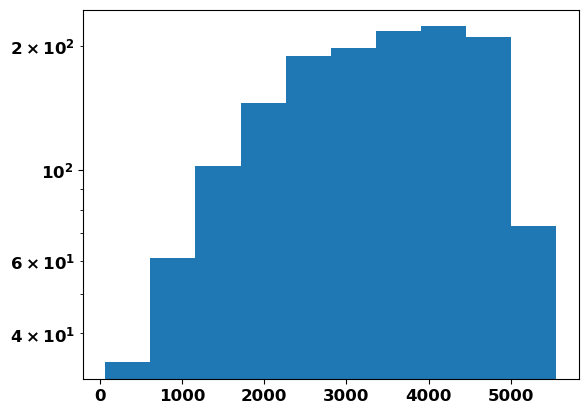

In [48]:
# print(np.mean(t2e_days), np.std(t2e_days))
# plt.hist(t2e_days, log=True)
# plt.show()

(array([1219., 2159., 3589., 5220., 6739., 7113., 7588., 7854., 7437.,
        2584.]),
 array([  64.        ,  612.86747235, 1161.7349447 , 1710.60241705,
        2259.4698894 , 2808.33736175, 3357.2048341 , 3906.07230645,
        4454.93977879, 5003.80725114, 5552.67472349]),
 <BarContainer object of 10 artists>)

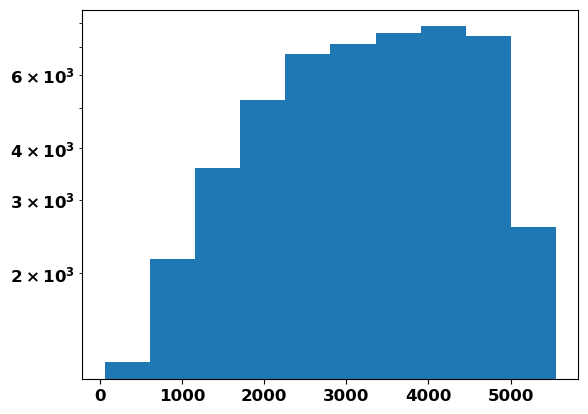

In [12]:
plt.hist(sampled_times, log=True)

In [13]:
import pandas as pd

# Assuming df is your DataFrame
percent_na = X.isna().mean() * 100

print(percent_na)


eid                       0.000000
21003-0.0                 0.000000
54-0.0                    0.000000
845-0.0                  22.768260
2738-0                    1.803427
                           ...    
max_educ_complete_5.0     0.000000
max_educ_complete_6.0     0.000000
max_educ_complete_nan     0.000000
53-0.0                    0.000000
first_dx                  0.000000
Length: 2966, dtype: float64


In [13]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

def impute_data(X_train,X_test):
    # Identify columns
    num_cols = ['21003-0.0', '845-0.0', '1141-0', '1840-0', '2854-0', '2610-0', '154-0', '242-0', '521-0', '1288-0']
    cat_cols = ['apoe_polymorphism_2.0', 'apoe_polymorphism_0.0', '31-0.0_1.0', '21000-0.0_-3.0', '21000-0.0_-1.0',
       '21000-0.0_1.0', '21000-0.0_2.0', '21000-0.0_3.0', '21000-0.0_4.0',
       '21000-0.0_5.0', '21000-0.0_6.0', '21000-0.0_1001.0',
       '21000-0.0_1002.0', '21000-0.0_1003.0', '21000-0.0_2001.0',
       '21000-0.0_2002.0', '21000-0.0_2003.0', '21000-0.0_2004.0',
       '21000-0.0_3001.0', '21000-0.0_3002.0', '21000-0.0_3003.0',
       '21000-0.0_3004.0', '21000-0.0_4001.0', '21000-0.0_4002.0',
       '21000-0.0_4003.0', '21000-0.0_nan', 
       'apoe_polymorphism_1.0', 
       'apoe_polymorphism_nan', 'max_educ_complete_-7.0',
       'max_educ_complete_-3.0', 'max_educ_complete_1.0',
       'max_educ_complete_2.0', 'max_educ_complete_3.0',
       'max_educ_complete_4.0', 'max_educ_complete_5.0',
       'max_educ_complete_6.0', 'max_educ_complete_nan']

    # Define preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='mean'), num_cols),
            ('cat', SimpleImputer(strategy='most_frequent'), cat_cols)
        ])

    # Optionally, use a pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    # Fit and transform the data
    pipeline = pipeline.fit(X_train.loc[:, num_cols + cat_cols])
    X_train = pipeline.transform(X_train.loc[:, num_cols + cat_cols])
    X_train = pd.DataFrame(X_train, columns=num_cols + cat_cols)

    X_test = pipeline.transform(X_test.loc[:, num_cols + cat_cols])
    X_test = pd.DataFrame(X_test, columns=num_cols + cat_cols)


    return X_train, X_test
    # from sklearn.impute import SimpleImputer
    # imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

    # incl_feats = ['21003-0.0', '1141-0', '1840-0', '2854-0', '2610-0', '154-0', 'apoe_polymorphism_2.0', '242-0', '521-0', '1288-0']
    # imp_mean.fit(X_train.loc[:,incl_feats])

    # imp_X_train = imp_mean.transform(X_train.loc[:,incl_feats])
    # imp_X_test = imp_mean.transform(X_test.loc[:,incl_feats])

In [15]:
X_train, X_test = impute_data(X_train, X_test)

In [25]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

est = LogisticRegression(penalty=None).fit(X_train#[:,0].reshape(-1,1)
                            , y_train.iloc[:,0]#.values.reshape(-1,1))
                            )
print(est.score(X_train#[:,0].reshape(-1,1)
                    , y_train.iloc[:,0]#.values.reshape(-1,1)
                    )
                  ,      
est.score(X_test#[:,0].reshape(-1,1)
                , y_test.iloc[:,0]#.values.reshape(-1,1))
                ))

# print(est.coef_)

0.9192966636609559 0.9107303877366997


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
ml_utils.calc_results(y_test.iloc[:,0], est.predict_proba(X_test)[:,1])

auroc           0.753281
avg_prec        0.305959
threshold       0.193875
TP             81.000000
TN           1861.000000
FP            156.000000
FN            120.000000
accuracy        0.875564
bal_acc         0.662821
prec_n          0.939425
prec_p          0.341772
recall_n        0.922657
recall_p        0.402985
f1_n            0.930965
f1_p            0.369863
mcc             0.302605
dtype: float64

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

# ['21003-0.0', '1141-0', '1840-0']#, '2854-0', '2610-0', '154-0', 'apoe_polymorphism_2.0', '242-0', '521-0', '1288-0']

def filter_na(X, y):
    # Sample DataFrame
    df = X.loc[:, ['21003-0.0', '1141-0', '1840-0', '2854-0', '2610-0', '154-0', 'apoe_polymorphism_2.0', 'apoe_polymorphism_0.0', '242-0', '521-0', '1288-0']].reset_index(drop=True)
    y = y.reset_index(drop=True)
    # Drop rows with any NaN values
    df_clean = df.dropna()

    # Get the indices of the rows that were dropped
    dropped_indices = df.index.difference(df_clean.index)

    # Drop corresponding labels
    # labels_clean = [label for i, label in enumerate(y) if i not in dropped_indices]
    y = y.iloc[[label for i, label in enumerate(y.index) if i not in dropped_indices], :]
    df_clean.reset_index(drop=True, inplace=True)

    return df_clean, y

In [53]:
X_train, y_train = filter_na(X_train, y_train)
X_test, y_test = filter_na(X_test, y_test)

In [54]:
X_train.shape, X_test.shape

((6364, 10), (1570, 10))

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

from sklearn.model_selection import train_test_split
from sksurv.datasets import load_breast_cancer
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import IPCRidge
from sksurv.metrics import concordance_index_ipcw, as_concordance_index_ipcw_scorer, concordance_index_censored, cumulative_dynamic_auc

# Define the data types for the structured array
dtype = [('label', 'bool'), ('time2event', 'int16')]  # U10 for strings of length up to 10 characters

# max_t2e_cases = max(y_train.loc[y_train.label == 1]['time2event'])
# y_train.loc[y_train['time2event'] == max_t2e_cases, 'time2event'] += 1

# Convert the DataFrame to a NumPy structured array
y_train_sa = np.array(list(y_train.itertuples(index=False, name=None)), dtype=dtype)
y_test_sa = np.array(list(y_test.itertuples(index=False, name=None)), dtype=dtype)

In [17]:
est_aft_ls = IPCRidge(
    random_state=0
).fit(X_train.loc[:,['21003-0.0']], y_train_sa)
cindex = est_aft_ls.score(X_test.loc[:,['21003-0.0']], y_test_sa)
print(round(cindex, 3))

print(concordance_index_ipcw(y_train_sa, y_train_sa, est_aft_ls.predict(X_train.loc[:, ['21003-0.0']])))
print(concordance_index_ipcw(y_train_sa, y_test_sa, est_aft_ls.predict(X_test.loc[:, ['21003-0.0']])))
print(concordance_index_censored([x[0] for x in y_train_sa], [x[1] for x in y_train_sa], est_aft_ls.predict(X_train.loc[:, ['21003-0.0']])))
print(concordance_index_censored([x[0] for x in y_test_sa], [x[1] for x in y_test_sa], est_aft_ls.predict(X_test.loc[:, ['21003-0.0']])))

aucs_age = cumulative_dynamic_auc(y_train_sa, y_test_sa, est_aft_ls.predict(X_test.loc[:, ['21003-0.0']]),
            np.arange(min([x[1] for x in y_test_sa]), max([x[1] for x in y_test_sa]), 30))

0.407
(0.5333145364101817, 1587718, 1029392, 584220, 2110)
(0.5878187583200737, 107818, 67872, 38599, 170)
(0.5872021940880822, 1587718, 1029392, 584220, 2110)
(0.593205904176136, 107818, 67872, 38599, 170)


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


In [18]:
feat_set = ['21003-0.0', '845-0.0', '31-0.0_1.0', '21000-0.0_-3.0', '21000-0.0_-1.0',
       '21000-0.0_1.0', '21000-0.0_2.0', '21000-0.0_3.0', '21000-0.0_4.0',
       '21000-0.0_5.0', '21000-0.0_6.0', '21000-0.0_1001.0',
       '21000-0.0_1002.0', '21000-0.0_1003.0', '21000-0.0_2001.0',
       '21000-0.0_2002.0', '21000-0.0_2003.0', '21000-0.0_2004.0',
       '21000-0.0_3001.0', '21000-0.0_3002.0', '21000-0.0_3003.0',
       '21000-0.0_3004.0', '21000-0.0_4001.0', '21000-0.0_4002.0',
       '21000-0.0_4003.0', '21000-0.0_nan', 'apoe_polymorphism_0.0',
       'apoe_polymorphism_1.0', 'apoe_polymorphism_2.0',
       'apoe_polymorphism_nan', 'max_educ_complete_-7.0',
       'max_educ_complete_-3.0', 'max_educ_complete_1.0',
       'max_educ_complete_2.0', 'max_educ_complete_3.0',
       'max_educ_complete_4.0', 'max_educ_complete_5.0',
       'max_educ_complete_6.0', 'max_educ_complete_nan']

est_aft_ls = IPCRidge(
    random_state=0
).fit(X_train.loc[:,feat_set], y_train_sa)
cindex = est_aft_ls.score(X_test.loc[:,feat_set], y_test_sa)
print(round(cindex, 3))

print(concordance_index_ipcw(y_train_sa, y_train_sa, est_aft_ls.predict(X_train.loc[:, feat_set])))
print(concordance_index_ipcw(y_train_sa, y_test_sa, est_aft_ls.predict(X_test.loc[:, feat_set])))
print(concordance_index_censored([x[0] for x in y_train_sa], [x[1] for x in y_train_sa], est_aft_ls.predict(X_train.loc[:, feat_set])))
print(concordance_index_censored([x[0] for x in y_test_sa], [x[1] for x in y_test_sa], est_aft_ls.predict(X_test.loc[:, feat_set])))

aucs_demo = cumulative_dynamic_auc(y_train_sa, y_test_sa, est_aft_ls.predict(X_test.loc[:, feat_set]),
            np.arange(min([x[1] for x in y_test_sa]), max([x[1] for x in y_test_sa]), 30))

0.56
(0.4781100955120015, 1310404, 1883481, 7445, 2110)
(0.4923059661852955, 94064, 119750, 475, 170)
(0.4104939197146186, 1310404, 1883481, 7445, 2110)
(0.4400669189739091, 94064, 119750, 475, 170)


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


In [158]:
from itertools import combinations

num_cols = ['21003-0.0', '1141-0', '1840-0', '2854-0', '2610-0', '154-0', '242-0', '521-0']
cat_cols = ['apoe_polymorphism_2.0', 'apoe_polymorphism_0.0']

feat_combos = list(combinations(num_cols + cat_cols, 2))

In [142]:
len(feat_combos)

120

In [22]:
prot_annot = pd.read_csv('../../../proj_idp/tidy_data/proteomics/coding143.tsv', sep='\t')

In [30]:
prot_annot.loc[(prot_annot.meaning.str.contains('GFAP|NEFL|BCAN|SYT1|APOE|VGF|CEND1|CST5')) | (prot_annot.coding.isin([1288]))]

coding                                            meaning
153      154                              APOE;Apolipoprotein E
241      242                         BCAN;Brevican core protein
520      521  CEND1;Cell cycle exit and neuronal differentia...
710      711                                    CST5;Cystatin-D
1140    1141               GFAP;Glial fibrillary acidic protein
1287    1288       HPGDS;Hematopoietic prostaglandin D synthase
1839    1840               NEFL;Neurofilament light polypeptide
2609    2610                               SYT1;Synaptotagmin-1
2853    2854                     VGF;Neurosecretory protein VGF

In [159]:
c_ipcw_train = []
c_ipcw_test = []
c_train = []
c_test = []
auc_feat_list = []

for fc in feat_combos:
    est_aft_ls = IPCRidge(
        random_state=0
    ).fit(X_train.loc[:, fc], y_train_sa)
    cindex = est_aft_ls.score(X_test.loc[:, fc], y_test_sa)
    print(round(cindex, 3))

    c_ipcw_train.append(concordance_index_ipcw(y_train_sa, y_train_sa, est_aft_ls.predict(X_train.loc[:, fc])))
    c_ipcw_test.append(concordance_index_ipcw(y_train_sa, y_test_sa, est_aft_ls.predict(X_test.loc[:, fc])))
    c_train.append(concordance_index_censored([x[0] for x in y_train_sa], [x[1] for x in y_train_sa], est_aft_ls.predict(X_train.loc[:, fc])))
    c_test.append(concordance_index_censored([x[0] for x in y_test_sa], [x[1] for x in y_test_sa], est_aft_ls.predict(X_test.loc[:, fc])))

    auc_feat_list.append(cumulative_dynamic_auc(y_train_sa, y_test_sa, est_aft_ls.predict(X_test.loc[:, fc]),
                np.arange(min([x[1] for x in y_test_sa]), max([x[1] for x in y_test_sa]), 30)))
    

0.339


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.635


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.389


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.423


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.434


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.433


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.505


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.529


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.323


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.605


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.372


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.37


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.368


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.394


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.519


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.501


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.303


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.61


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.63


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.637


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.62


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.629


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.675


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.633


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.372


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.388


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.401


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.449


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.509


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.4


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.543


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.418


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.553


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.638


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.33


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.412


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.536


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.52


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.407


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.484


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.522


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.453


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.608


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.456


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


0.517


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


Text(0, 0.5, 'Time-dependent AUROC')

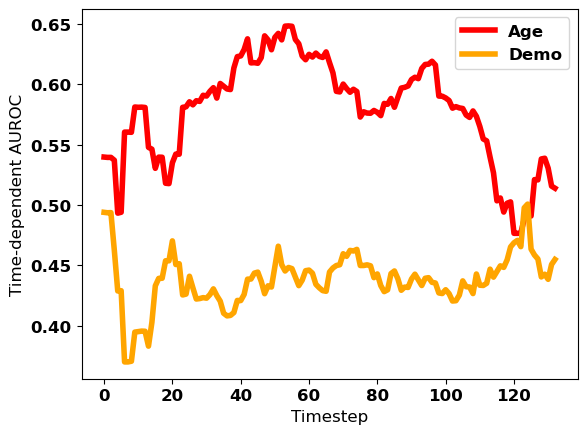

In [19]:

lag = 40
end_lag = 10
# for i in range(len(auc_feat_list)):
#     plt.plot(range(len(auc_feat_list[i][0])-(lag + end_lag)), auc_feat_list[i][0][lag:-end_lag])#, label='Top Vars')
plt.plot(range(len(aucs_age[0])-(lag + end_lag)), aucs_age[0][lag:-end_lag], label='Age', color='red', linewidth=4)
plt.plot(range(len(aucs_demo[0])-(lag + end_lag)), aucs_demo[0][lag:-end_lag], label='Demo', color='orange', linewidth=4)
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Time-dependent AUROC')

In [162]:
age_mean = np.mean(aucs_age[0][lag:-end_lag])

fl_means = []
for i in range(len(auc_feat_list)):
    fl_means.append(np.mean(auc_feat_list[i][0][lag:-end_lag]))

In [157]:
print(age_mean)

0.577776218063892


In [146]:
def get_top(arr):
    best = np.array(arr)[fl_means >= age_mean][:,0]
    print(min(best), max(best))
# c_ipcw_test
# c_train 
# c_test 
# auc_feat_list 

In [148]:
get_top(c_ipcw_train)

0.5324069424483621 0.6864780624259142


In [164]:
best_means = np.array(fl_means)[fl_means >= age_mean]
higher_than_age = np.array(feat_combos)[fl_means >= age_mean]
sorted_top_combos = higher_than_age[np.argsort(best_means)][::-1]
sorted_means = best_means[np.argsort(best_means)][::-1]
for i, c in enumerate(sorted_top_combos):
    print(c, 'mean AUC:', round(sorted_means[i], 3))
print(len(higher_than_age))

['1141-0' 'apoe_polymorphism_0.0'] mean AUC: 0.691
['2610-0' 'apoe_polymorphism_0.0'] mean AUC: 0.665
['21003-0.0' 'apoe_polymorphism_0.0'] mean AUC: 0.656
['21003-0.0' '1141-0'] mean AUC: 0.655
['1141-0' '154-0'] mean AUC: 0.639
['2854-0' '2610-0'] mean AUC: 0.638
['1141-0' '2854-0'] mean AUC: 0.636
['1141-0' '2610-0'] mean AUC: 0.635
['2854-0' '154-0'] mean AUC: 0.619
['21003-0.0' '2854-0'] mean AUC: 0.617
['2854-0' 'apoe_polymorphism_0.0'] mean AUC: 0.61
['1141-0' '242-0'] mean AUC: 0.602
['2854-0' '242-0'] mean AUC: 0.601
['2610-0' '242-0'] mean AUC: 0.583
['154-0' 'apoe_polymorphism_0.0'] mean AUC: 0.581
15


(array([ 5.,  6.,  4.,  0.,  4.,  5.,  7.,  3.,  5.,  1.,  0.,  0.,  4.,
         2.,  3.,  0., 10.,  2.,  7., 10.,  7.,  4.,  5.,  2.,  1.,  2.,
         2.,  0.,  1.,  2.,  3.,  3.,  1.,  6.,  2.,  1.,  0.,  0.,  0.]),
 array([0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ,
        0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51,
        0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62,
        0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69]),
 <BarContainer object of 39 artists>)

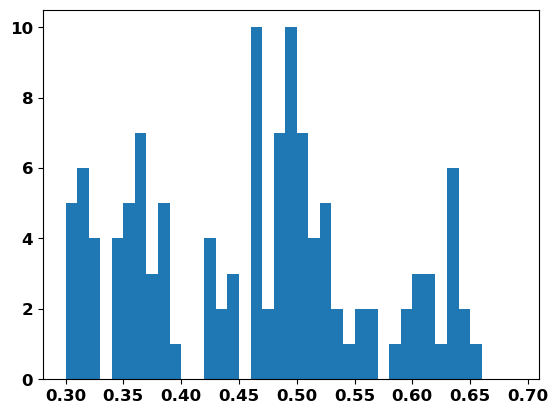

In [46]:
plt.hist(fl_means, bins=np.arange(0.3,0.7,0.01))

In [45]:
auc_feat_list[i][0]

array([       nan,        nan,        nan, 0.39254884, 0.39326354,
       0.39230064, 0.3921659 , 0.27718492, 0.27840295, 0.27820964,
       0.3990863 , 0.33806157, 0.23176417, 0.22586397, 0.26197801,
       0.29818499, 0.30878304, 0.3079613 , 0.30295416, 0.28647994,
       0.29632341, 0.29698269, 0.28146106, 0.29750355, 0.32387286,
       0.33100203, 0.3281924 , 0.3326271 , 0.33052831, 0.33329012,
       0.34544958, 0.34661298, 0.33413774, 0.35219763, 0.37205889,
       0.39433796, 0.38998554, 0.40354913, 0.41691812, 0.40771169,
       0.40884305, 0.41382565, 0.42957449, 0.42326149, 0.44136813,
       0.42362388, 0.42812727, 0.3876057 , 0.43105479, 0.45506883,
       0.46833815, 0.44679959, 0.41522097, 0.35809635, 0.56928608])

In [13]:

# Calculate the point density
xy = np.vstack([df_clean['21003-0.0'], df_clean['1840-0']])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = df_clean['21003-0.0'][idx], df_clean['1840-0'][idx], z[idx]


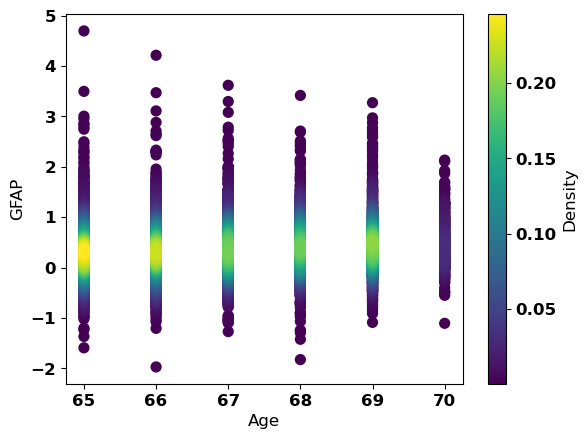

In [17]:
# Create the scatter plot
plt.scatter(x, y, c=z, s=50,  cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('Age')
plt.ylabel('GFAP')
plt.show()


In [18]:
import numpy as np
from scipy.stats import spearmanr

def permutation_test(data, n_iterations=1000, random_state=None):
    np.random.seed(random_state)
    observed_corr, _ = spearmanr(data['21003-0.0'], data['1840-0'])
    permuted_corrs = []

    for _ in range(n_iterations):
        permuted_data = data.copy()
        permuted_data['1840-0'] = np.random.permutation(permuted_data['1840-0'])
        perm_corr, _ = spearmanr(permuted_data['21003-0.0'], permuted_data['1840-0'])
        permuted_corrs.append(perm_corr)

    p_value = np.mean(np.abs(permuted_corrs) >= np.abs(observed_corr))
    return observed_corr, p_value

# Run permutation test
observed_corr, p_value = permutation_test(df_clean, n_iterations=1000, random_state=42)

print("Spearman Correlation Coefficient:", observed_corr)
print("P-value:", p_value)


Spearman Correlation Coefficient: 0.1357822918203708
P-value: 0.0


In [52]:
# X_train, X_test, y_train, y_test = train_test_split(
# df_clean, labels_clean, test_size=0.3, random_state=10000)

In [84]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- 1-0
- 10-0
- 100-0
- 1000-0
- 1001-0
- ...


In [30]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

est = LogisticRegression(penalty=None).fit(X_train#[:,0].reshape(-1,1)
                            , y_train#.values.reshape(-1,1))
                            )
print(est.score(X_train#[:,0].reshape(-1,1)
                    , y_train#.values.reshape(-1,1)
                    )
                  ,      
est.score(X_test#[:,0].reshape(-1,1)
                , y_test#.values.reshape(-1,1))
                ))

print(est.coef_)

0.9153543307086615 0.9153543307086615
[[0.22941715 0.28559653 0.45570258]]


In [31]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

est = LogisticRegression(penalty=None).fit(X_train[:,0].reshape(-1,1)
                            , y_train#.values.reshape(-1,1))
                            )
print(est.score(X_train[:,0].reshape(-1,1)
                    , y_train#.values.reshape(-1,1)
                    )
                  ,      
est.score(X_test[:,0].reshape(-1,1)
                , y_test#.values.reshape(-1,1))
                ))

print(est.coef_)

0.9166197975253093 0.9166666666666666
[[0.30223251]]


In [43]:
fi = pd.read_parquet('../../results/dementia/proteomics/demographics_and_modality/log_loss/feature_importance_region_0.parquet')

In [45]:
fi.head(10)

feature  importance
0                 1141-0          19
1              21003-0.0          13
2                 1840-0          12
3                 2854-0          10
4                 2610-0           9
5                  154-0           9
6  apoe_polymorphism_2.0           9
7                  242-0           7
8                  521-0           5
9                 1288-0           5

In [46]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')

incl_feats = ['21003-0.0', '1141-0', '1840-0']#, '2854-0', '2610-0', '154-0', 'apoe_polymorphism_2.0', '242-0', '521-0', '1288-0']
imp_mean.fit(X_train.loc[:,incl_feats])

imp_X_train = imp_mean.transform(X_train.loc[:,incl_feats])
imp_X_test = imp_mean.transform(X_test.loc[:,incl_feats])

In [27]:
est_aft_ls = IPCRidge(
    random_state=0
).fit(imp_X_train, y_train_sa)
cindex = est_aft_ls.score(imp_X_test, y_test_sa)
print(round(cindex, 3))

print(concordance_index_ipcw(y_train_sa, y_train_sa, est_aft_ls.predict(imp_X_train)))
print(concordance_index_ipcw(y_train_sa, y_test_sa, est_aft_ls.predict(imp_X_test)))
print(concordance_index_censored([x[0] for x in y_train_sa], [x[1] for x in y_train_sa], est_aft_ls.predict(imp_X_train)))
print(concordance_index_censored([x[0] for x in y_test_sa], [x[1] for x in y_test_sa], est_aft_ls.predict(imp_X_test)))

aucs_imp = cumulative_dynamic_auc(y_train_sa, y_test_sa, est_aft_ls.predict(imp_X_test), np.arange(min([x[1] for x in y_test_sa]), max([x[1] for x in y_test_sa]), 100))

NameError: name 'imp_X_train' is not defined

In [50]:
X_train.shape

(8872, 2966)

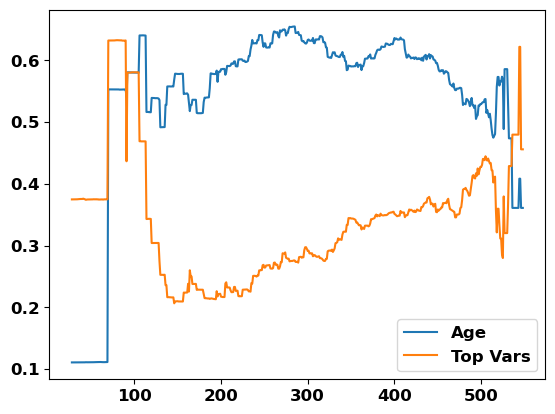

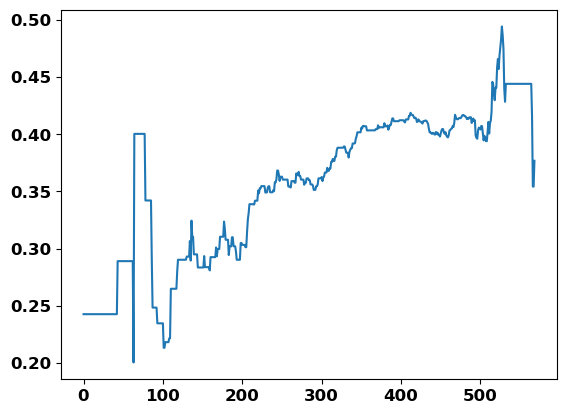

In [48]:
plt.plot(range(len(aucs_imp[0])),aucs_imp[0])

In [27]:
y_train_sa

array([(False, 5317), (False, 4794), (False, 4491), ..., (False, 5214),
       (False, 4912), (False, 5184)],
      dtype=[('label', '?'), ('time2event', '<i2')])

In [ ]:
est_aft_ls = rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=0
).fit(X_train.loc[:,['21003-0.0']], y_train_sa)
cindex = est_aft_ls.score(X_test.loc[:,['21003-0.0']], y_test_sa)
print(round(cindex, 3))

print(concordance_index_ipcw(y_train_sa, y_test_sa, est_aft_ls.predict(X_test.loc[:, ['21003-0.0']])))

In [13]:
est_aft_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    n_estimators=300, learning_rate=0.2, random_state=0
).fit(X_train.loc[:,['21003-0.0']], y_train_sa)
cindex = est_aft_ls.score(X_test.loc[:,['21003-0.0']], y_test_sa)
print(round(cindex, 3))

print(concordance_index_ipcw(y_train_sa, y_train_sa, est_aft_ls.predict(X_train.loc[:, ['21003-0.0']])))
print(concordance_index_ipcw(y_train_sa, y_test_sa, est_aft_ls.predict(X_test.loc[:, ['21003-0.0']])))
print(concordance_index_censored([x[0] for x in y_train_sa], [x[1] for x in y_train_sa], est_aft_ls.predict(X_train.loc[:, ['21003-0.0']])))
print(concordance_index_censored([x[0] for x in y_test_sa], [x[1] for x in y_test_sa], est_aft_ls.predict(X_test.loc[:, ['21003-0.0']])))

0.794
(0.8020771238530491, 35060358, 8360427, 1764500, 9011)
(0.8068575855588097, 2310351, 555572, 115009, 393)
(0.7954494034949652, 35060358, 8360427, 1764500, 9011)
(0.7943339532736742, 2310351, 555572, 115009, 393)


In [20]:
est_aft_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    loss='squared', n_estimators=300, learning_rate=0.2, random_state=0
).fit(X_train.loc[:,['21003-0.0']], y_train_sa)
cindex = est_aft_ls.score(X_test.loc[:,['21003-0.0']], y_test_sa)
print(round(cindex, 3))

print(concordance_index_ipcw(y_train_sa, y_train_sa, est_aft_ls.predict(X_train.loc[:, ['21003-0.0']])))
print(concordance_index_ipcw(y_train_sa, y_test_sa, est_aft_ls.predict(X_test.loc[:, ['21003-0.0']])))
print(concordance_index_censored([x[0] for x in y_train_sa], [x[1] for x in y_train_sa], est_aft_ls.predict(X_train.loc[:, ['21003-0.0']])))
print(concordance_index_censored([x[0] for x in y_test_sa], [x[1] for x in y_test_sa], est_aft_ls.predict(X_test.loc[:, ['21003-0.0']])))

0.794
(0.1979228761469513, 8360427, 35060358, 1764500, 9011)
(0.193142414441191, 555572, 2310351, 115009, 393)
(0.20455059650503477, 8360427, 35060358, 1764500, 9011)
(0.20566604672632585, 555572, 2310351, 115009, 393)


In [22]:
est_aft_ls = GradientBoostingSurvivalAnalysis(
    loss="coxph", n_estimators=300, learning_rate=0.1, random_state=0
).fit(X_train.loc[:, ['21003-0.0']], y_train_sa)
cindex = est_aft_ls.score(X_test.loc[:, ['21003-0.0']], y_test_sa)
print(round(cindex, 3))

print(concordance_index_ipcw(y_train_sa, y_train_sa, est_aft_ls.predict(X_train.loc[:, ['21003-0.0']])))
print(concordance_index_ipcw(y_train_sa, y_test_sa, est_aft_ls.predict(X_test.loc[:, ['21003-0.0']])))
print(concordance_index_censored([x[0] for x in y_train_sa], [x[1] for x in y_train_sa], est_aft_ls.predict(X_train.loc[:, ['21003-0.0']])))
print(concordance_index_censored([x[0] for x in y_test_sa], [x[1] for x in y_test_sa], est_aft_ls.predict(X_test.loc[:, ['21003-0.0']])))

KeyboardInterrupt: 

In [8]:
from sklearn.metrics import confusion_matrix, roc_auc_score, \
     precision_recall_fscore_support
     
yj = []
unique_ages = list(set(X_train['21003-0.0']))
for age in unique_ages:
    pred = (X_train['21003-0.0'] >= age).astype(int)

    prfs = precision_recall_fscore_support(y_train.label,
                                           pred)
    yj.append( prfs[1][0] + prfs[1][1] - 1 )

/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
print(unique_ages[np.argmax(yj)],
max(yj))

63.0 0.4662391010708855


In [10]:
pred = (X_train['21003-0.0'] >= 63).astype(int)

precision_recall_fscore_support(y_train.label, pred)


(array([0.99046814, 0.06808044]),
 array([0.71103077, 0.75520833]),
 array([0.82780344, 0.1249013 ]),
 array([41212,  1152]))

In [11]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

con = X_train[X_train['21003-0.0'] < 63]
con_df_y = y_train.iloc[X_train['21003-0.0'].values < 63]
dem = X_train[X_train['21003-0.0'] >= 63]
dem_df_y = y_train.iloc[X_train['21003-0.0'].values >= 63]


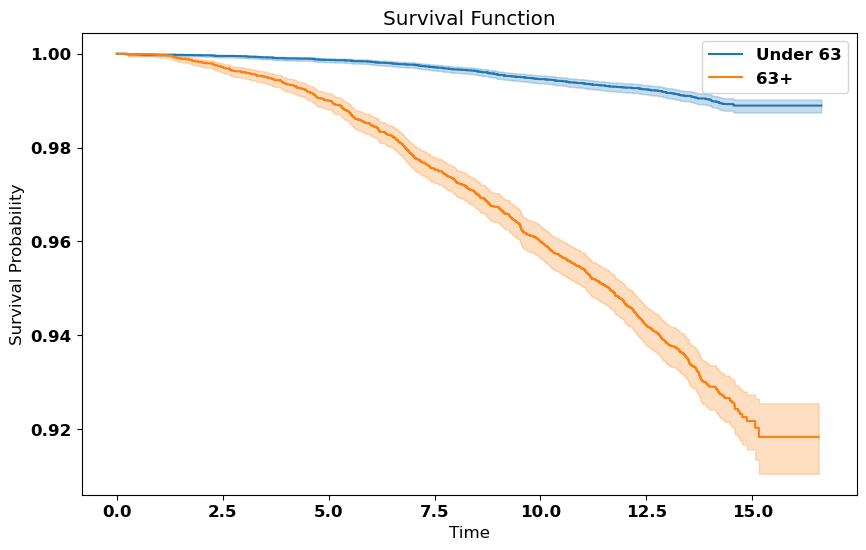

In [16]:
kmf = KaplanMeierFitter()
kmf.fit(con_df_y['time2event'] / 365.25, event_observed=con_df_y['label'], label='Under 63')

plt.figure(figsize=(10, 6))
kmf.plot_survival_function()

kmf = KaplanMeierFitter()
kmf.fit(dem_df_y['time2event']/ 365.25, event_observed=dem_df_y['label'], label='63+')

kmf.plot_survival_function()

plt.title('Survival Function')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()


In [71]:
wdf = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
wdf.rename(columns={"21003-0.0": "age"}, inplace=True)

In [67]:
wdf.shape, X_train.shape, y_train.shape

((42364, 2968), (42364, 2966), (42364, 2))

In [72]:
wdf.tail()

eid   age   54-0.0  845-0.0   2738-0   2737-0   2736-0  2735-0  \
42359  2092261  65.0  11014.0     15.0 -0.11505  0.22365  0.18325 -0.4650   
42360  5349304  43.0  11012.0     -1.0 -0.23145 -0.39540 -0.19900 -0.4190   
42361  4709725  67.0  11006.0     18.0  0.19435  0.30220  0.27260 -0.2995   
42362  1084226  62.0  11013.0     15.0  0.03185  0.34580 -0.22950 -1.1163   
42363  2522605  45.0  11009.0      NaN -0.11305 -0.08060 -0.17320  0.1299   

        2734-0   2733-0  ...  max_educ_complete_2.0  max_educ_complete_3.0  \
42359 -0.39485 -0.25695  ...                    0.0                    0.0   
42360 -0.15210 -0.64390  ...                    0.0                    0.0   
42361 -0.06160  0.25730  ...                    0.0                    0.0   
42362  0.16360  0.40340  ...                    0.0                    0.0   
42363 -0.47210 -0.14820  ...                    0.0                    0.0   

       max_educ_complete_4.0  max_educ_complete_5.0  max_educ_complete_6.0  \
42359                    0.0                    0.0                    1.0   
42360                    0.0                    0.0                    0.0   
42361                    0.0                    1.0                    0.0   
42362                    0.0                    0.0                    0.0   
42363                    0.0                    0.0                    1.0   

       max_educ_complete_nan     53-0.0  first_dx  label  time2event  
42359                    0.0 2010-06-23   control      0        4513  
42360                    0.0 2009-07-30   control      0        4841  
42361                    0.0 2008-07-22   control      0        5214  
42362                    0.0 2009-05-20   control      0        4912  
42363                    0.0 2008-08-21   control      0        5184  

[5 rows x 2968 columns]

In [73]:
# Fit Weibull AFT model
aft_model = WeibullAFTFitter()
aft_model.fit(wdf, duration_col='time2event', event_col='label', formula="age")

# Print the summary of the model
print(aft_model.summary)

                        coef     exp(coef)  se(coef)  coef lower 95%  \
param   covariate                                                      
lambda_ Intercept  16.714803  1.816129e+07  0.328025       16.071885   
        age        -0.101654  9.033418e-01  0.004575       -0.110621   
rho_    Intercept   0.612066  1.844237e+00  0.029042        0.555145   

                   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
param   covariate                                                             
lambda_ Intercept       17.357720         9.548411e+06         3.454317e+07   
        age             -0.092687         8.952778e-01         9.114784e-01   
rho_    Intercept        0.668986         1.742193e+00         1.952258e+00   

                   cmp to          z              p    -log2(p)  
param   covariate                                                
lambda_ Intercept     0.0  50.955849   0.000000e+00         inf  
        age           0.0 -22.219310  2.23479

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

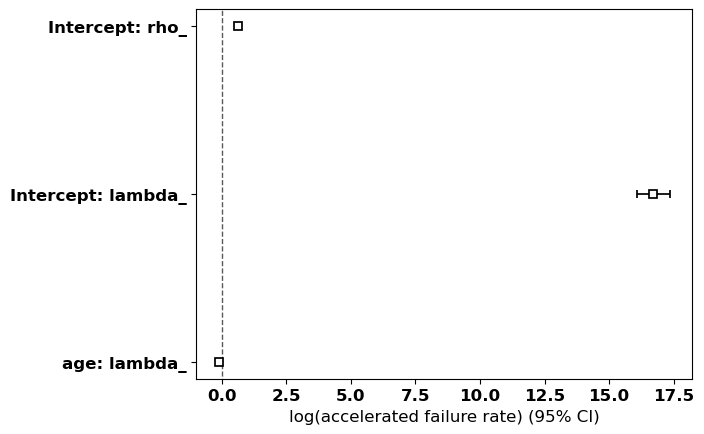

In [75]:
aft_model.plot()

In [77]:
aft_model.plot_survival_function(X_train.iloc[0:3])
plt.title('Survival Function for Selected Individuals')
plt.show()

AttributeError: 'WeibullAFTFitter' object has no attribute 'plot_survival_function'

<Axes: >

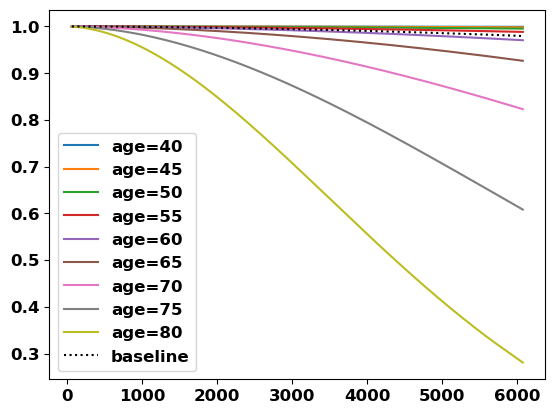

In [82]:
aft_model.plot_covariate_groups(covariates='age', values=np.arange(40,85,5))

0         22252.197161
1         27268.965853
2         20101.340251
3        188138.844313
4         30186.763517
             ...      
42359     20101.340251
42360    188138.844313
42361     16403.225149
42362     27268.965853
42363    153526.271582
Length: 42364, dtype: float64


(array([19121.,  7419.,  5024.,  2294.,  2052.,  2125.,  1020.,  1000.,
         1820.,   489.]),
 array([ 12091.65069622,  36404.92172815,  60718.19276008,  85031.463792  ,
        109344.73482393, 133658.00585586, 157971.27688778, 182284.54791971,
        206597.81895164, 230911.08998356, 255224.36101549]),
 <BarContainer object of 10 artists>)

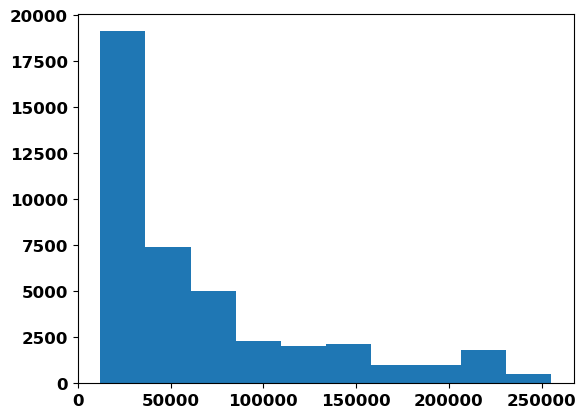

In [80]:
quantiles = aft_model.predict_percentile(wdf, p=0.5)  # Predicting the median survival time (50th percentile)
print(quantiles)
plt.hist(quantiles)


<Axes: >

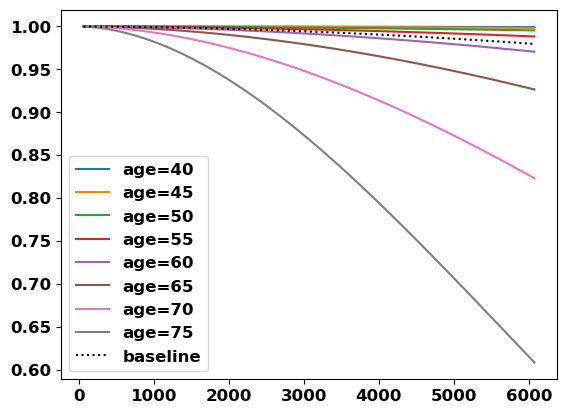

In [83]:
aft_model.plot_partial_effects_on_outcome('age', values=np.arange(40,80,5))


In [51]:
from sksurv.datasets import load_whas500
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
import numpy as np

# Load dataset
data_x, data_y = load_whas500()

# One-hot encode categorical variables
data_x_enc = OneHotEncoder().fit_transform(data_x)

# Split data into training and testing sets
n_samples = len(data_y)
np.random.seed(0)
indices = np.random.permutation(n_samples)
train_size = int(n_samples * 0.8)
train_indices = indices[:train_size]
test_indices = indices[train_size:]


KeyError: "None of [Index([ 90, 254, 283, 445, 461,  15, 316, 489, 159, 153,\n       ...\n       305,  48, 341, 373, 207, 279, 227, 148, 143, 334],\n      dtype='int64', length=400)] are in the [columns]"

In [57]:

x_train = data_x_enc.iloc[train_indices]
x_test = data_x_enc.iloc[test_indices]
y_train = data_y[train_indices]
y_test = data_y[test_indices]

# Fit Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=5)
rsf.fit(x_train, y_train)

df_ytest = pd.DataFrame(y_test)
# Evaluate model performance
c_index = concordance_index_censored(df_ytest['fstat'], df_ytest['lenfol'], rsf.predict(x_test))
print("Concordance Index:", c_index[0])


Concordance Index: 0.761521580102414


In [58]:
x_train

afb=1   age  av3=1       bmi  chf=1  cvd=1  diasbp  gender=1     hr  \
90     1.0  82.0    0.0  18.79667    0.0    1.0   109.0       0.0   73.0   
254    0.0  72.0    0.0  25.49755    0.0    1.0    82.0       0.0   73.0   
283    0.0  46.0    0.0  32.57132    1.0    0.0   104.0       0.0   94.0   
445    0.0  80.0    0.0  27.91060    1.0    1.0    71.0       1.0   78.0   
461    0.0  45.0    0.0  34.14385    0.0    1.0    98.0       0.0   77.0   
..     ...   ...    ...       ...    ...    ...     ...       ...    ...   
279    0.0  71.0    0.0  23.43605    0.0    0.0    84.0       1.0   80.0   
227    1.0  71.0    0.0  39.19180    1.0    1.0    64.0       0.0   72.0   
148    0.0  68.0    0.0  31.63788    1.0    0.0    93.0       0.0  150.0   
143    1.0  54.0    0.0  34.84510    1.0    1.0    84.0       0.0  100.0   
334    1.0  56.0    0.0  25.94995    0.0    0.0    80.0       1.0   80.0   

      los  miord=1  mitype=1  sho=1  sysbp  
90    2.0      0.0       0.0    0.0  207.0  
254   2.0      0.0       1.0    0.0  142.0  
283   3.0      0.0       0.0    0.0  160.0  
445  12.0      0.0       0.0    0.0  137.0  
461   3.0      0.0       0.0    0.0  162.0  
..    ...      ...       ...    ...    ...  
279   8.0      0.0       1.0    0.0  118.0  
227  22.0      0.0       0.0    0.0  160.0  
148  18.0      1.0       1.0    0.0  138.0  
143   2.0      0.0       1.0    0.0  139.0  
334   8.0      0.0       1.0    0.0  130.0  

[400 rows x 14 columns]

In [53]:
data_x.head()

afb   age av3       bmi chf cvd  diasbp gender    hr   los miord mitype sho  \
0   1  83.0   0  25.54051   0   1    78.0      0  89.0   5.0     1      0   0   
1   0  49.0   0  24.02398   0   1    60.0      0  84.0   5.0     0      1   0   
2   0  70.0   0  22.14290   0   0    88.0      1  83.0   5.0     0      1   0   
3   0  70.0   0  26.63187   1   1    76.0      0  65.0  10.0     0      1   0   
4   0  70.0   0  24.41255   0   1    85.0      0  63.0   6.0     0      1   0   

   sysbp  
0  152.0  
1  120.0  
2  147.0  
3  123.0  
4  135.0

NameError: name 'OneHotEncoder' is not defined

In [46]:
def extract_demo_for_table(df):

    sample_size.append(df.shape[0])
    
    age_data = df[f'21003-{data_instance}.0']
    age.append(f"{int(np.median(age_data))} [{int(np.percentile(age_data, 25))}-{int(np.percentile(age_data, 75))}]")

    num_female = sum(df['31-0.0_1.0'] == 0)
    sex.append(f"{num_female} ({round(100 * (num_female / df.shape[0]), 2)})")

    white_cols = ['21000-0.0_1.0', '21000-0.0_1001.0', '21000-0.0_1002.0', '21000-0.0_1003.0']
    num_white = np.sum(df.loc[:, white_cols].values)
    ethnicity.append(f'{num_white} ({round(100 * (num_white / df.shape[0]), 2)})')

    age_complete_fulltime_educ_data = df[f'845-0.0'].dropna()
    age_complete_fulltime_educ.append(f"{int(np.median(age_complete_fulltime_educ_data))} [{int(np.percentile(age_complete_fulltime_educ_data, 25))}-{int(np.percentile(age_complete_fulltime_educ_data, 75))}]")

    apoe4_single_data = sum(df['apoe_polymorphism_1.0'] == 1)
    apoe4_single.append(f'{apoe4_single_data} ({round(100 * (apoe4_single_data / df.shape[0]), 2)})')

    apoe4_double_data = sum(df['apoe_polymorphism_2.0'])
    apoe4_double.append(f'{apoe4_double_data} ({round(100 * (apoe4_double_data / df.shape[0]), 2)})')


In [47]:
sample_size = []
age = []
sex = []
ethnicity = []
age_complete_fulltime_educ = []
apoe4_single = []
apoe4_double = []

extract_demo_for_table(X)
extract_demo_for_table(controls)
extract_demo_for_table(acd)

df = pd.DataFrame([sample_size, age, sex, ethnicity, age_complete_fulltime_educ, apoe4_double, apoe4_single], columns=['Total', 'Controls', 'All-cause Dementia'])
df['Measure'] = ['Sample Size', 'Age', 'Sex (female)', 'Ethnicity (White)', 'Age at completed full-time education', 'APOE\u03B54, 2 alleles', 'APOE\u03B54, 1 allele']

In [48]:
df.set_index('Measure').to_latex()

'\\begin{tabular}{llll}\n\\toprule\n & Total & Controls & All-cause Dementia \\\\\nMeasure &  &  &  \\\\\n\\midrule\nSample Size & 213106 & 212009 & 1097 \\\\\nAge & 56 [50-62] & 56 [50-62] & 65 [61-67] \\\\\nSex (female) & 120137 (56.37) & 119644 (56.43) & 493 (44.94) \\\\\nEthnicity (White) & 205720.0 (96.53) & 204650.0 (96.53) & 1070.0 (97.54) \\\\\nAge at completed full-time education & 16 [16-18] & 16 [16-18] & 16 [15-17] \\\\\nAPOEε4, 2 alleles & 3773.0 (1.77) & 3688.0 (1.74) & 85.0 (7.75) \\\\\nAPOEε4, 1 allele & 45135 (21.18) & 44750 (21.11) & 385 (35.1) \\\\\n\\bottomrule\n\\end{tabular}\n'

# MCI

In [154]:
data_modality = 'cognitive_tests'
data_instance = 0
experiment = 'demographics_and_modality'
metric = 'log_loss'
age_cutoff = 0
region_index = 0

X = pd.read_parquet(f'../../tidy_data/dementia/{data_modality}/X.parquet')
y = np.load(f'../../tidy_data/dementia/{data_modality}/y.npy')
mci = pd.read_parquet('../../tidy_data/dementia/mci/mci_data.parquet')


X_train = X[~X.eid.isin(mci.eid)]
X_test = X[X.eid.isin(mci.eid)]
y_train = y[X_train.index]
y_test = y[X_test.index]

X_train = X_train.drop(columns=['eid'])
X_test = X_test.drop(columns=['eid'])

In [119]:
X_train.shape, X_test.shape, sum(y_train), sum(y_test)

((212942, 123), (164, 123), 1050, 47)

In [168]:
import sys
sys.path.append('../ukb_func')
import icd
import ml_utils
import df_utils
import ukb_utils
import utils
import f3
import plot_results

import pickle
import argparse
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_validate, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, fbeta_score, RocCurveDisplay, auc, roc_curve, precision_recall_fscore_support, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, roc_auc_score, precision_recall_fscore_support, accuracy_score, balanced_accuracy_score
from lightgbm import LGBMClassifier
from flaml import AutoML

import sys
from datetime import datetime
import pickle
import matplotlib.pyplot as plt

'''
Proteomics experiments for:
Age alone
All demographics
All proteins
All demographics + all proteins

Input arguments:
experiment - age_only, all_demographics, proteins_only, demographics_and_proteins
time_budget - number of seconds for AutoML training
metric - roc_auc or f3
file_suffix - other information to add to the output directory path so that things don't get overwritten
'''


data_modality = 'cognitive_tests'
data_instance = 0
experiment = 'demographics_and_modality'
metric = 'log_loss'
age_cutoff = 0
region_index = 0

# # Create the argument parser
# parser = argparse.ArgumentParser(
#     description='Run AutoML on chosen feature sets')

# # Add arguments
# # parser.add_argument('njobs', type=str, help='Number of cores')
# parser.add_argument('--modality', type=str,
#                     help='options: cognitive_tests, neuroimaging, proteomics')
# parser.add_argument('--experiment', type=str,
#                     help='options: age_only, all_demographics, modality_only, demographics_and_modality')
# parser.add_argument('--time_budget', type=int, default=3600,
#                     help='options: seconds to allow FLAML to optimize')
# parser.add_argument('--metric', type=str, default='roc_auc',
#                     help='options: roc_auc, f3, ap')
# parser.add_argument('--age_cutoff', type=int, default=None,
#                     help='age cutoff')
# # parser.add_argument('--region_index', type=int, default=None,
# #                     help='region index')
# # parser.add_argument('--file_suffix', type=str, default='',
# #                     help='extra information to put in the filename')

# # Parse the arguments
# args = parser.parse_args()
# data_modality = args.modality
# experiment = args.experiment
# time_budget = args.time_budget
# metric = args.metric
# age_cutoff = args.age_cutoff
# file_suffix = args.file_suffix
# region_index = args.region_index

# if region_index == None:
#     print('NEED REGION INDEX')
#     sys.exit()

# Specify the directory path
directory_path = f'../../results/dementia/{data_modality}/{experiment}/mci_test_set/{metric}/'

# Load datasets
X = pd.read_parquet(f'../../tidy_data/dementia/{data_modality}/X.parquet')
y = np.load(f'../../tidy_data/dementia/{data_modality}/y.npy')
mci = pd.read_parquet('../../tidy_data/dementia/mci/mci_data.parquet')

if data_modality == 'neuroimaging':
    data_instance = 2
else:
    data_instance = 0
    region_indices = pickle.load(open(f'../../tidy_data/dementia/{data_modality}/region_cv_indices.pickle', 'rb'))

if age_cutoff == 65:
    over_age_idx = X[f'21003-{data_instance}.0'] >= age_cutoff
    X = X[over_age_idx].reset_index(drop=True)
    y = y[over_age_idx]
    
    # cv indices based on region (for not neuroimaging because it doesn't use regions)
    if data_modality != 'neuroimaging':
        region_lookup = pd.read_csv('../../metadata/coding10.tsv', sep='\t')
        region_indices = ukb_utils.group_assessment_center(X, data_instance, region_lookup)

    directory_path = f'{directory_path}/agecutoff_{age_cutoff}'

# check if output folder exists
utils.check_folder_existence(directory_path)

if data_modality=='proteomics':
    proteomics_vars = df_utils.pull_columns_by_suffix(X, ['-0']).columns.tolist()
elif data_modality=='neuroimaging':
    idp_vars = pickle.load(open('../../tidy_data/dementia/neuroimaging/idp_variables.pkl', 'rb'))
elif data_modality=='cognitive_tests':
    cog_vars = pickle.load(open(f'../../tidy_data/dementia/{data_modality}/cognitive_columns.pkl', 'rb'))

if experiment == 'age_only':
    X = X.loc[:, ['eid', f'21003-{data_instance}.0']]
    time_budget = 400
elif experiment == 'all_demographics':
    X = X.loc[:, ['eid'] + df_utils.pull_columns_by_prefix(X, [f'21003-{data_instance}.0', '31-0.0', 'apoe', 'max_educ_complete', '845-0.0', '21000-0.0']).columns.tolist()]
    time_budget = 500
elif experiment == 'modality_only':
    if data_modality=='proteomics':
        X = X.loc[:, ['eid'] + proteomics_vars]
    elif data_modality=='neuroimaging':
        X = X.loc[:, ['eid'] + idp_vars]
    elif data_modality=='cognitive_tests':
        X = X.loc[:, ['eid'] + cog_vars]
    time_budget = 9500
elif experiment == 'demographics_and_modality':
    if data_modality=='proteomics':
        X = X.loc[:, ['eid'] + df_utils.pull_columns_by_prefix(X, [f'21003-{data_instance}.0', '31-0.0', 'apoe', 'max_educ_complete', '845-0.0', '21000-0.0']).columns.tolist() + proteomics_vars]
    elif data_modality=='neuroimaging':
        X = X.loc[:, ['eid'] + df_utils.pull_columns_by_prefix(X, [f'21003-{data_instance}.0', '31-0.0', 'apoe', 'max_educ_complete', '845-0.0', '21000-0.0']).columns.tolist() + idp_vars]
    elif data_modality=='cognitive_tests':
        X = X.loc[:, ['eid'] + df_utils.pull_columns_by_prefix(X, [f'21003-{data_instance}.0', '31-0.0', 'apoe', 'max_educ_complete', '845-0.0', '21000-0.0']).columns.tolist() + cog_vars]     
    time_budget = 14000

if age_cutoff == 65:
    print('Modifying time budget by dividing by 3 for age cutoff of 65') 
    time_budget = time_budget/2

print(f'Running {experiment} experiment, MCI test set, autoML time budget of {time_budget} seconds, {metric} as the metric, and an age cutoff of {age_cutoff} years')

# if metric == 'roc_auc':
#     pass
# elif metric == 'f3':
#     metric = f3.f3_metric

train_labels_l = []
train_probas_l = []

test_labels_l = []
test_probas_l = []

train_res_l = []
test_res_l = []

print(f'Dimensionality of the dataset: {X.shape}')

X_train = X[~X.eid.isin(mci.eid)]
X_test = X[X.eid.isin(mci.eid)]
y_train = y[X_train.index]
y_test = y[X_test.index]

X_train = X_train.drop(columns=['eid'])
X_test = X_test.drop(columns=['eid'])

current_time = datetime.now().time()
print(f'{current_time}')
print('made train and test split')


Running demographics_and_modality experiment, MCI test set, autoML time budget of 14000 seconds, log_loss as the metric, and an age cutoff of 0 years
Dimensionality of the dataset: (213106, 123)
12:10:06.550595
made train and test split


In [169]:

automl = AutoML()
automl.retrain_from_log(log_file_name=f'{directory_path}/results_log.json',
                        X_train=X_train, y_train=y_train, task='classification', 
                        train_full=True, n_jobs=-1,
                        #eval_method='cv', n_splits=10, split_type='stratified',
                        train_best=True)

print('Done fitting model')



Done fitting model


In [170]:
if len(automl.feature_importances_) == 1:
    top_feature_names = np.array(automl.feature_names_in_)[np.argsort(abs(automl.feature_importances_[0]))[::-1]][:100]
else:
    top_feature_names = np.array(automl.feature_names_in_)[np.argsort(abs(automl.feature_importances_))[::-1]][:100]

In [128]:
protein_code = pd.read_csv('../../../proj_idp/tidy_data/proteomics/coding143.tsv', sep='\t')

import pandas as pd


# Split the column by semicolon and expand into separate columns
split_columns = protein_code['meaning'].str.split(';', expand=True)

# Rename the new columns (optional)
split_columns.columns = [f'part_{i+1}' for i in range(split_columns.shape[1])]

# Concatenate the new columns with the original DataFrame (optional)
protein_code = pd.concat([protein_code, split_columns], axis=1)

# Drop the original column if no longer needed
protein_code = protein_code.drop('meaning', axis=1)

ticks = []

for f in top_feature_names[:20]:
    if f[-2:] == '-0':
        hyphen_idx = f.index('-')
        prot_id = f[:hyphen_idx]
        sym = protein_code.loc[protein_code.coding == int(prot_id), 'part_1'].values[0]
        
        ticks.append(sym)
    elif '21003' in f:
        ticks.append('Age')
    elif 'apoe_' in f:
        allele_num = f[-3]
        ticks.append(f'APOE$\epsilon$4, {allele_num} alleles')
    else:
        ticks.append(f)

<>:31: SyntaxWarning: invalid escape sequence '\e'
<>:31: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_22275/2758127124.py:31: SyntaxWarning: invalid escape sequence '\e'
  ticks.append(f'APOE$\epsilon$4, {allele_num} alleles')


<>:33: SyntaxWarning: invalid escape sequence '\e'
<>:43: SyntaxWarning: invalid escape sequence '\e'
<>:48: SyntaxWarning: invalid escape sequence '\e'
<>:33: SyntaxWarning: invalid escape sequence '\e'
<>:43: SyntaxWarning: invalid escape sequence '\e'
<>:48: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_22275/805277836.py:33: SyntaxWarning: invalid escape sequence '\e'
  'Global mean thickness (R)', f'APOE$\epsilon$4, 1 allele', 'Area, G-front-inf-Triangul (L)', 'Area, S-orbital-lateral (L)', 'rfMRI component amplitudes, dim 100']
/tmp/ipykernel_22275/805277836.py:43: SyntaxWarning: invalid escape sequence '\e'
  cognitive_ticks = ['Age', 'Number of symbol digit matches made correctly', 'Duration to complete alphanumeric path (trail #2)', f'APOE$\epsilon$4, 2 alleles',
/tmp/ipykernel_22275/805277836.py:48: SyntaxWarning: invalid escape sequence '\e'
  f'APOE$\epsilon$4, 2 alleles', 'Age completed full time education']


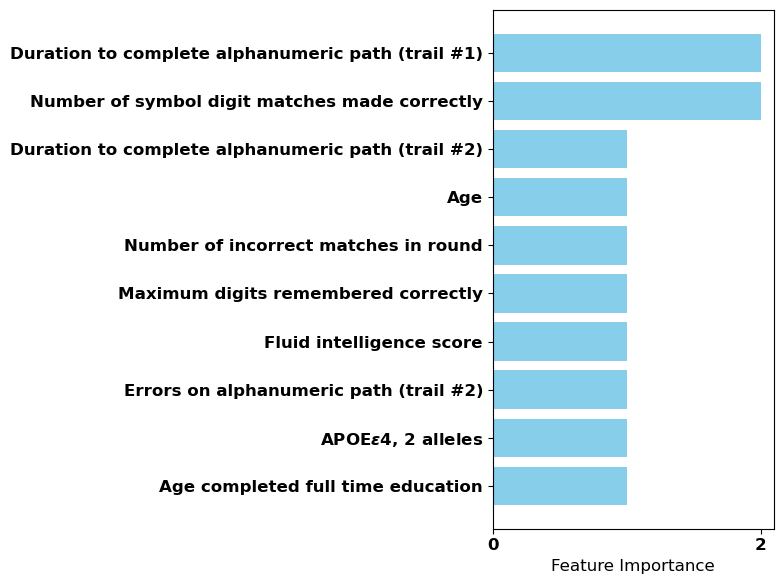

In [174]:
import matplotlib.pyplot as plt

# 26521	Volume of EstimatedTotalIntraCranial (whole brain)

# 26755	Mean thickness of GlobalMeanMean thickness (left hemisphere)
# 26856	Mean thickness of GlobalMeanMean thickness (right hemisphere)

# 26641	Volume of Whole-hippocampus (left hemisphere)	Freesurfer subsegmentation  
# 26663	Volume of Whole-hippocampus (right hemisphere)	Freesurfer subsegmentation  

# 25381	Mean ICVF in cingulum hippocampus on FA skeleton (left)	dMRI skeleton  
# 25380	Mean ICVF in cingulum hippocampus on FA skeleton (right)	dMRI skeleton  

# Sample data
categories = top_feature_names[:10][::-1]
values = top_feature_importances[:10][::-1]

# Create a figure and axis
plt.figure(figsize=(8, 6))

    
# Create a horizontal bar plot
plt.barh(categories, values, color='skyblue')

# Add custom y-ticks
# idp_ticks = ['Vol. GM, Amyg (R)', 'Vol. Inf-Lat-Vent (L)', 'Vol. GM (Head-norm)', 'Vol. GM, Lat-Occipital Ctx, inf. div. (L)', 'rfMRI par. corr. mtx, dim 100', 'Vol. CA1-body (L)',
#         'Mean thickness, inf-parietal (R)', 'Inverted SNR, T1', 'rfMRI par. corr. mtx, dim 100','rfMRI par. corr. mtx, dim 100' ]
idp_age65_ticks = ['Discrepancy, T1 brain <-> standard-space brain template', 'Vol. GM, Amyg (R)', 'rfMRI component amplitudes, dim 100',
    'rfMRI par. corr. mtx, dim 100', 'Area, sup. temp. (R)', 'rfMRI par. corr. mtx, dim 100', 'G-W contrast in LOF (L)', 'Weighted-mean MD in tract parahipp. cingulum (R)', 
    'Weighted-mean MD in tract parahipp. cingulum (L)', 'G-W contrast in trans. VT (R)']

mci_idp_ticks = ['Vol. Inf-Lat-Vent (L)', 'Inv. CNR, T1', 'rfMRI par. corr. mtx, dim 100', 'Inverted SNR, T1', 'Intensity scaling for dMRI', 
                'Global mean thickness (R)', f'APOE$\epsilon$4, 1 allele', 'Area, G-front-inf-Triangul (L)', 'Area, S-orbital-lateral (L)', 'rfMRI component amplitudes, dim 100']


if data_modality == 'proteomics':
    plt.yticks(ticks=categories, labels=ticks[:10][::-1])

if data_modality == 'neuroimaging':
    plt.yticks(ticks=categories, labels=mci_idp_ticks[:10][::-1])

if data_modality == 'cognitive_tests':
    cognitive_ticks = ['Age', 'Number of symbol digit matches made correctly', 'Duration to complete alphanumeric path (trail #2)', f'APOE$\epsilon$4, 2 alleles',
                    'Number of incorrect matches in round', 'Maximum digits remembered correctly', 'Fluid intelligence score', 'Very nervous mood over last week',
                    'Downhearted and depressed over last week', 'Number of correct matches in round']
    mci_cognitive_ticks = ['Duration to complete alphanumeric path (trail #1)', 'Number of symbol digit matches made correctly', 'Duration to complete alphanumeric path (trail #2)',
                            'Age', 'Number of incorrect matches in round', 'Maximum digits remembered correctly', 'Fluid intelligence score', 'Errors on alphanumeric path (trail #2)',
                            f'APOE$\epsilon$4, 2 alleles', 'Age completed full time education']
    plt.yticks(ticks=categories, labels=mci_cognitive_ticks[::-1])

# Set custom x-ticks with a frequency of 2
x_ticks = np.arange(0, max(values) + 2, 2)  # Adjust the range and step as needed
plt.xticks(ticks=x_ticks)

plt.xlabel('Feature Importance')
plt.tight_layout()
# plt.show()
# Show the plot
plt.savefig(f'MCI_feature_importance_{data_modality}_{age_cutoff}.pdf', dpi=300)
# plt.close()

# regular experiments

In [2]:
data_modality = 'proteomics'
data_instance = 0
experiment = 'demographics_and_modality'
metric = 'log_loss'
age_cutoff = 0
region_index = 0

X = pd.read_parquet(f'../../tidy_data/dementia/{data_modality}/X.parquet')
X = X.iloc[:,1:]
y = np.load(f'../../tidy_data/dementia/{data_modality}/y.npy')
region_indices = pickle.load(open(f'../../tidy_data/dementia/{data_modality}/region_cv_indices.pickle', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '../../tidy_data/dementia/proteomics/X.parquet'

In [32]:
X.shape, sum(y)

((11090, 2963), 917)

In [40]:
y = y[X[f'21003-{data_instance}.0'] >= 65]

X = X[X[f'21003-{data_instance}.0'] >= 65]
subX.shape, sum(suby)

((28849, 123), 552)

In [33]:
X.columns[-40:]

Index(['37-0', '1738-0', '1173-0', '31-0.0_1.0', '21000-0.0_-3.0',
       '21000-0.0_-1.0', '21000-0.0_1.0', '21000-0.0_2.0', '21000-0.0_3.0',
       '21000-0.0_4.0', '21000-0.0_5.0', '21000-0.0_6.0', '21000-0.0_1001.0',
       '21000-0.0_1002.0', '21000-0.0_1003.0', '21000-0.0_2001.0',
       '21000-0.0_2002.0', '21000-0.0_2003.0', '21000-0.0_2004.0',
       '21000-0.0_3001.0', '21000-0.0_3002.0', '21000-0.0_3003.0',
       '21000-0.0_3004.0', '21000-0.0_4001.0', '21000-0.0_4002.0',
       '21000-0.0_4003.0', '21000-0.0_nan', 'apoe_polymorphism_0.0',
       'apoe_polymorphism_1.0', 'apoe_polymorphism_2.0',
       'apoe_polymorphism_nan', 'max_educ_complete_-7.0',
       'max_educ_complete_-3.0', 'max_educ_complete_1.0',
       'max_educ_complete_2.0', 'max_educ_complete_3.0',
       'max_educ_complete_4.0', 'max_educ_complete_5.0',
       'max_educ_complete_6.0', 'max_educ_complete_nan'],
      dtype='object')

/tmp/ipykernel_22275/1686776588.py:8: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim((0,4000))


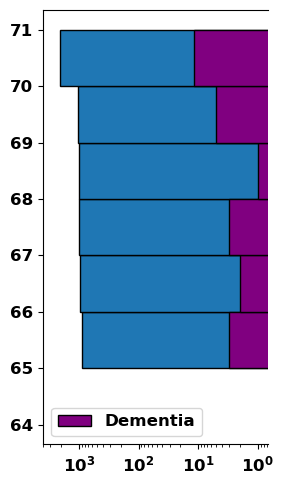

In [46]:
plt.figure(figsize=(3,5))
age_min = 64
age_max = 72
plt.hist(X.loc[X['31-0.0_1.0'] == 1][f'21003-{data_instance}.0'], bins=np.arange(age_min,age_max,1), orientation='horizontal', edgecolor='black', log=True)
plt.hist(X.loc[(X['31-0.0_1.0'] == 1) & (y==1)][f'21003-{data_instance}.0'], bins=np.arange(age_min,age_max,1), color='purple', orientation='horizontal', edgecolor='black', label='Dementia')
plt.legend(loc='lower left')

plt.xlim((0,4000))
plt.gca().invert_xaxis()
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
# plt.show()
plt.savefig(f'65+_males_{data_modality}_age.pdf')

/tmp/ipykernel_22275/3148044830.py:9: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim((0,4000))


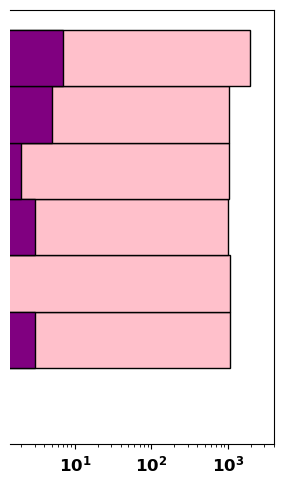

In [45]:
plt.figure(figsize=(3,5))
age_min = 64
age_max = 72
plt.hist(X.loc[X['31-0.0_1.0'] == 0][f'21003-{data_instance}.0'], bins=np.arange(age_min,age_max,1), color='pink', orientation='horizontal', edgecolor='black', log=True)
plt.hist(X.loc[(X['31-0.0_1.0'] == 0) & (y==1)][f'21003-{data_instance}.0'], bins=np.arange(age_min,age_max,1), color='purple', orientation='horizontal', edgecolor='black', label='Dementia')

plt.yticks([])
plt.gca().spines['left'].set_visible(False)
plt.xlim((0,4000))

plt.tight_layout()
plt.savefig(f'65+_females_{data_modality}_age.pdf')

In [5]:
region_list = list(region_indices.keys())

for i in range(10):
    
    r = region_list[i]
    # print(f'Starting region {i+1} of {len(region_list)}: {r}')

    # for i,r in enumerate(region_list):
    current_time = datetime.now().time()
    # print(f'{r}, {current_time}')
    indices = region_indices[r]
    X_test = X.iloc[indices, :]
    y_test = y[indices]

    print(X_test.shape, sum(y_test), (sum(y_test) / X_test.shape[0]))

(4129, 2963) 121 0.029304916444659723
(7525, 2963) 160 0.0212624584717608
(6269, 2963) 182 0.029031743499760728
(8384, 2963) 273 0.032562022900763356
(3712, 2963) 97 0.026131465517241378
(3950, 2963) 105 0.026582278481012658
(3925, 2963) 106 0.02700636942675159
(2173, 2963) 51 0.023469857340082834
(4560, 2963) 104 0.02280701754385965
(8328, 2963) 254 0.030499519692603266


In [7]:
data_modality = 'proteomics'
data_instance = 0
experiment = 'demographics_and_modality'
metric = 'log_loss'
age_cutoff = 0
region_index = 0

X = pd.read_parquet(f'../../tidy_data/dementia/{data_modality}/X.parquet')
X = X.iloc[:,1:]
y = np.load(f'../../tidy_data/dementia/{data_modality}/y.npy')
region_indices = pickle.load(open(f'../../tidy_data/dementia/{data_modality}/region_cv_indices.pickle', 'rb'))

# # Create the argument parser
# parser = argparse.ArgumentParser(
#     description='Run AutoML on chosen feature sets')

# # Add arguments
# # parser.add_argument('njobs', type=str, help='Number of cores')
# parser.add_argument('--experiment', type=str,
#                     help='options: proteins_only, demographics_and_proteins')
# parser.add_argument('--time_budget', type=int, default=3600,
#                     help='options: seconds to allow FLAML to optimize')
# parser.add_argument('--metric', type=str, default='roc_auc',
#                     help='options: roc_auc, f3, ap')
# parser.add_argument('--age_cutoff', type=int, default=None,
#                     help='age cutoff')
# parser.add_argument('--region_index', type=int, default=None,
#                     help='region index')
# # parser.add_argument('--file_suffix', type=str, default='',
# #                     help='extra information to put in the filename')

# # Parse the arguments
# args = parser.parse_args()
# experiment = args.experiment
# time_budget = args.time_budget
# metric = args.metric
# age_cutoff = args.age_cutoff
# region_index = args.region_index
if age_cutoff == 0:
    age_cutoff = None
# file_suffix = args.file_suffix


if region_index == None:
    print('NEED REGION INDEX')
    sys.exit()

# Specify the directory path
original_results_directory_path = f'../../results/dementia/{data_modality}/{experiment}/{metric}/'
directory_path = f'../../results/dementia/{data_modality}/{experiment}/feature_selection/{metric}/'

if age_cutoff is not None:
    over_age_idx = X[f'21003-{data_instance}.0'] >= age_cutoff
    X = X[over_age_idx].reset_index(drop=True)
    y = y[over_age_idx]
    
    # cv indices based on region
    region_lookup = pd.read_csv('../../metadata/coding10.tsv', sep='\t')
    region_indices = ukb_utils.group_assessment_center(X, data_instance, region_lookup)

    original_results_directory_path = f'{original_results_directory_path}/agecutoff_{age_cutoff}'
    directory_path = f'{directory_path}/agecutoff_{age_cutoff}'

# check if output folder exists
utils.check_folder_existence(directory_path)

if experiment == 'modality_only':
    X = X.loc[:, df_utils.pull_columns_by_suffix(X, ['-0']).columns.tolist()]
    time_budget = 8500
elif experiment == 'demographics_and_modality':
    X = X.loc[:, df_utils.pull_columns_by_prefix(X, [f'21003-{data_instance}.0', '31-0.0', 'apoe', 'max_educ_complete', '845-0.0', '21000-0.0']).columns.tolist() + df_utils.pull_columns_by_suffix(X, ['-0']).columns.tolist()]
    time_budget = 9000

if age_cutoff == 65:
    print('Modifying time budget by dividing by 2 for age cutoff of 65') 
    time_budget = time_budget/2

print(f'Running {experiment} experiment, autoML time budget of {time_budget} seconds, {metric} as the metric, and an age cutoff of {age_cutoff} years')

if metric == 'f3':
    metric = f3.f3_metric


print(f'Dimensionality of the dataset: {X.shape}')

region_list = list(region_indices.keys())
# del region_list[1]

i = region_index
r = region_list[i]
print(f'Starting region {i+1} of {len(region_list)}: {r}')

# for i,r in enumerate(region_list):
current_time = datetime.now().time()
print(f'{r}, {current_time}')
indices = region_indices[r]
X_test = X.iloc[indices, :]
y_test = y[indices]

# Create a mask to select all indices not in indices
mask = np.ones(len(y), dtype=bool)
mask[indices] = False

# Step 4: Subset the main array using the mask
X_train = X.iloc[mask, :]
y_train = y[mask]
print(f'Made train and test split for region {i+1}')


Running demographics_and_modality experiment, autoML time budget of 9000 seconds, log_loss as the metric, and an age cutoff of None years
Dimensionality of the dataset: (52955, 2962)
Starting region 1 of 10: East Midlands
East Midlands, 11:05:31.985295
Made train and test split for region 1


TypeError: LGBMClassifier.fit() got an unexpected keyword argument 'model_history'

In [8]:

automl = AutoML()
automl.retrain_from_log(log_file_name=f'{original_results_directory_path}/results_log_{i}.json',
                        X_train=X_train, y_train=y_train, task='classification', 
                        train_full=True, n_jobs=-1, preserve_checkpoint=True,
                        #eval_method='cv', n_splits=10, split_type='stratified',
                        train_best=True)

time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = get_output_from_log(filename=f'{original_results_directory_path}/results_log_{i}.json', time_budget=time_budget)

train_labels_l = []
train_probas_l = []

test_labels_l = []
test_probas_l = []

train_res_l = []
test_res_l = []


In [11]:

if len(automl.feature_importances_) == 1:
    feature_names = np.array(automl.feature_names_in_)[np.argsort(abs(automl.feature_importances_[0]))[::-1]]
    fi = automl.feature_importances_[0][np.argsort(abs(automl.feature_importances_[0]))[::-1]]
else:
    feature_names = np.array(automl.feature_names_in_)[np.argsort(abs(automl.feature_importances_))[::-1]]
    fi = automl.feature_importances_[np.argsort(abs(automl.feature_importances_))[::-1]]

In [59]:
dd_l = []

for i in range(10):
    dd = pd.read_parquet(f'../../results/dementia/proteomics/all_demographics/log_loss/feature_importance_region_{i}.parquet')
    dd_l.append(dd)

In [60]:
# Concatenate all DataFrames
concatenated_df = pd.concat(dd_l, ignore_index=True)

# Group by column 'A' and calculate the mean and standard deviation of column 'B'
result = concatenated_df.groupby('feature')['importance'].agg(['mean', 'std']).reset_index()

# Rename columns for clarity
result.columns = ['feature', 'Mean_importance', 'Std_importance']

In [61]:
plot_df = result[result.Mean_importance > 0].sort_values('Mean_importance', ascending=False).iloc[:10]

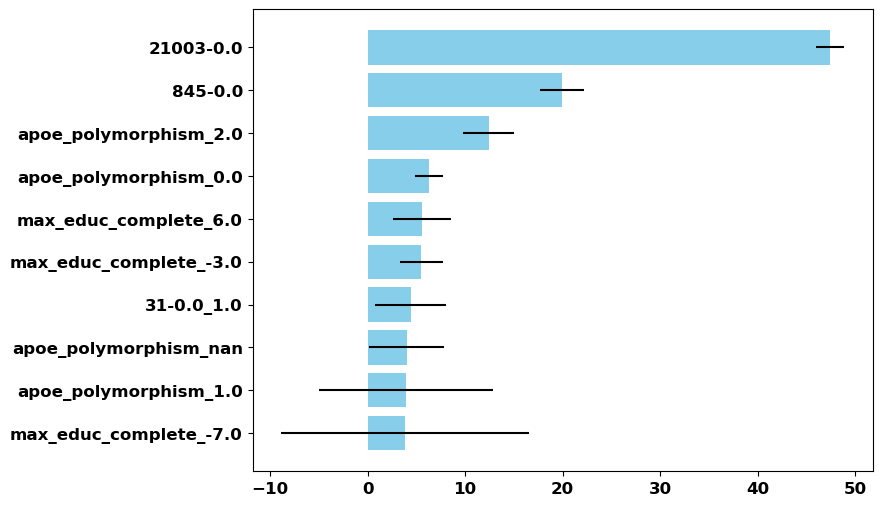

In [62]:
# Create a figure and axis
plt.figure(figsize=(8, 6))

    
# Create a horizontal bar plot
plt.barh(plot_df.feature[::-1], plot_df.Mean_importance[::-1], xerr=plot_df.Std_importance, color='skyblue')
plt.show()

In [32]:
dd.head()

feature  importance
0       25889-2.0           2
1       26555-2.0           2
2       25005-2.0           2
3       25826-2.0           1
4  25753_2_0_1384           1

In [96]:
top_feature_importances, top_feature_names

(array([2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array(['25731-2.0', '25889-2.0', '25755_2_0_55', '25753_2_0_1066',
        '26985-2.0', '25753_2_0_995', '27000-2.0', '25522-2.0',
        '25521-2.0', '27057-2.0', '27061-2.0', '27077-2.0', '25603-2.0',
        '25434-2.0', '27211-2.0', '25752_2_0_103', '25188-2.0',
        '25753_2_0_1346', '25185-2.0', '27343-2.0', '25753_2_0_1384',
        '27413-2.0', '25602-2.0', '25753_2_0_842', '25639-2.0',
        '26641-2.0', '25753_2_0_541', '25753_2_0_539', '26551-2.0',
        '26586-2.0', '26546-2.0', '26604-2.0', '26528-2.0', '25928-2.0',
        '25919-2.0', '27463-2.0', '26643-2.0', '25888-2.0', '25869-2.0',
        '26718-2.0', '25826-

In [76]:
protein_code = pd.read_csv('../../../proj_idp/tidy_data/proteomics/coding143.tsv', sep='\t')

import pandas as pd


# Split the column by semicolon and expand into separate columns
split_columns = protein_code['meaning'].str.split(';', expand=True)

# Rename the new columns (optional)
split_columns.columns = [f'part_{i+1}' for i in range(split_columns.shape[1])]

# Concatenate the new columns with the original DataFrame (optional)
protein_code = pd.concat([protein_code, split_columns], axis=1)

# Drop the original column if no longer needed
protein_code = protein_code.drop('meaning', axis=1)

ticks = []

for f in top_feature_names[:20]:
    if f[-2:] == '-0':
        hyphen_idx = f.index('-')
        prot_id = f[:hyphen_idx]
        sym = protein_code.loc[protein_code.coding == int(prot_id), 'part_1'].values[0]
        
        ticks.append(sym)
    elif '21003' in f:
        ticks.append('Age')
    elif 'apoe_' in f:
        allele_num = f[-3]
        ticks.append(f'APOE$\epsilon$4, {allele_num} alleles')
    else:
        ticks.append(f)

<>:31: SyntaxWarning: invalid escape sequence '\e'
<>:31: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_22275/2758127124.py:31: SyntaxWarning: invalid escape sequence '\e'
  ticks.append(f'APOE$\epsilon$4, {allele_num} alleles')


In [77]:
ticks

['GFAP',
 'NEFL',
 'BCAN',
 'SYT1',
 'APOE',
 'VGF',
 'CST5',
 'CEND1',
 'APOE$\\epsilon$4, 2 alleles',
 'APOE$\\epsilon$4, 0 alleles',
 'MENT',
 'Age',
 'NPTXR',
 'HPGDS',
 'TPSG1',
 'PTPRN2',
 'HSPB6',
 'TG',
 'SERPINA9',
 'CHAC2']

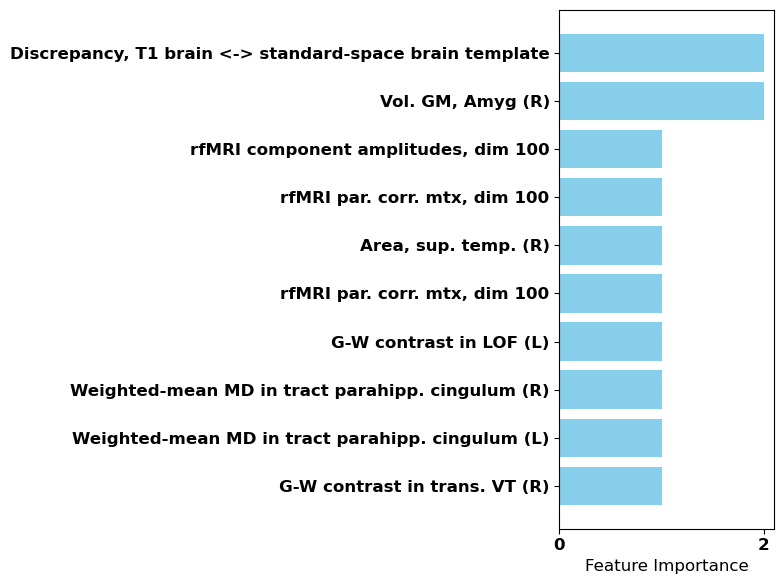

In [104]:
import matplotlib.pyplot as plt

# 26521	Volume of EstimatedTotalIntraCranial (whole brain)

# 26755	Mean thickness of GlobalMeanMean thickness (left hemisphere)
# 26856	Mean thickness of GlobalMeanMean thickness (right hemisphere)

# 26641	Volume of Whole-hippocampus (left hemisphere)	Freesurfer subsegmentation  
# 26663	Volume of Whole-hippocampus (right hemisphere)	Freesurfer subsegmentation  

# 25381	Mean ICVF in cingulum hippocampus on FA skeleton (left)	dMRI skeleton  
# 25380	Mean ICVF in cingulum hippocampus on FA skeleton (right)	dMRI skeleton  

# Sample data
categories = top_feature_names[:10][::-1]
values = top_feature_importances[:10][::-1]

# Create a figure and axis
plt.figure(figsize=(8, 6))

    
# Create a horizontal bar plot
plt.barh(categories, values, color='skyblue')

# Add custom y-ticks
# idp_ticks = ['Vol. GM, Amyg (R)', 'Vol. Inf-Lat-Vent (L)', 'Vol. GM (Head-norm)', 'Vol. GM, Lat-Occipital Ctx, inf. div. (L)', 'rfMRI par. corr. mtx, dim 100', 'Vol. CA1-body (L)',
#         'Mean thickness, inf-parietal (R)', 'Inverted SNR, T1', 'rfMRI par. corr. mtx, dim 100','rfMRI par. corr. mtx, dim 100' ]
idp_age65_ticks = ['Discrepancy, T1 brain <-> standard-space brain template', 'Vol. GM, Amyg (R)', 'rfMRI component amplitudes, dim 100',
    'rfMRI par. corr. mtx, dim 100', 'Area, sup. temp. (R)', 'rfMRI par. corr. mtx, dim 100', 'G-W contrast in LOF (L)', 'Weighted-mean MD in tract parahipp. cingulum (R)', 
    'Weighted-mean MD in tract parahipp. cingulum (L)', 'G-W contrast in trans. VT (R)']




# if data_modality == 'proteomics':
#     plt.yticks(ticks=categories, labels=ticks[:10][::-1])

if data_modality == 'neuroimaging':
    plt.yticks(ticks=categories, labels=idp_age65_ticks[:10][::-1])

# if data_modality == 'cognitive_tests':
#     cognitive_ticks = ['Age', 'Number of symbol digit matches made correctly', 'Duration to complete alphanumeric path (trail #2)', f'APOE$\epsilon$4, 2 alleles',
#                     'Number of incorrect matches in round', 'Maximum digits remembered correctly', 'Fluid intelligence score', 'Very nervous mood over last week',
#                     'Downhearted and depressed over last week', 'Number of correct matches in round']
#     plt.yticks(ticks=categories, labels=cognitive_ticks[::-1])

# Set custom x-ticks with a frequency of 2
x_ticks = np.arange(0, max(values) + 2, 2)  # Adjust the range and step as needed
plt.xticks(ticks=x_ticks)

plt.xlabel('Feature Importance')
plt.tight_layout()
# Show the plot
plt.savefig(f'feature_importance_{data_modality}_{age_cutoff}.pdf', dpi=300)
# plt.close()

In [90]:
os.getcwd()

'/n/groups/patel/randy/rfb/code/proteomics'

<Axes: ylabel='Density'>

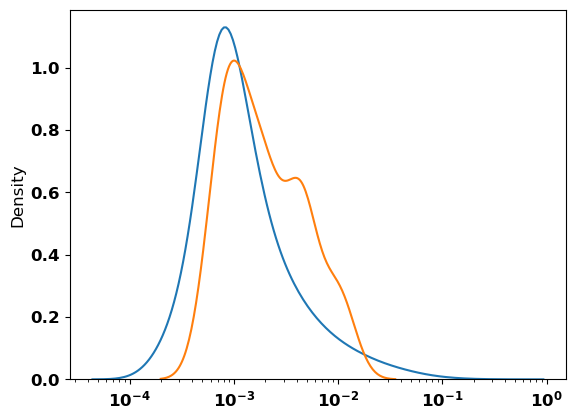

In [172]:
# plt.hist(np.concatenate(probas), log=True, fill=False, bins=500)
# plt.xscale('log')
# plt.yscale('linear')

bw_scal = 0.4

true_labels, probas = ml_utils.concat_labels_and_probas('../results/dementia/neuroimaging/demographics_and_modality/feature_selection/log_loss/')
sns.kdeplot(data=np.concatenate(probas), log_scale=True, bw_method=bw_scal)

true_labels, probas = ml_utils.concat_labels_and_probas('../results/dementia/neuroimaging/age_only/log_loss/')
sns.kdeplot(data=np.concatenate(probas), log_scale=True, bw_method=bw_scal)


# plt.xlim((0.000008,0.8))


# Confusion Matrices

In [4]:
os.chdir('./proteomics/')

In [41]:
modality='proteomics'

res_l = []
for expt in ['age_only', #'age_sex_lancet2024', 'all_demographics',  'modality_only', 
                          #        'demographics_and_lancet2024', 'modality_only/feature_selection', 'demographics_and_modality', 
                           #       'demographics_and_modality/feature_selection', 'demographics_modality_lancet2024',
                                  'demographics_modality_lancet2024/feature_selection']:
    train_results, test_results = ml_utils.probas_to_results(f'../../results/dementia/{modality}/{expt}/log_loss/', youden=True)
    res_l.append(test_results)

age_df = res_l[0]
fs_demo_modal = res_l[-1]

/n/groups/patel/randy/rfb/code/ukb_func/plot_results.py:249: SyntaxWarning: invalid escape sequence '\p'
  label = f'{title}\nAUC: {mean_auc:.3f} $\pm$ {std_auc:.3f}'
/n/groups/patel/randy/rfb/code/ukb_func/plot_results.py:309: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(mean_recall, mean_precision, color='blue', label=f'AP: {mean_ap:.3f} $\pm$ {std_ap:.3f})', lw=2, alpha=0.8)
/n/groups/patel/randy/rfb/code/ukb_func/plot_results.py:352: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(mean_recall, mean_precision, color=colors[i], label=f'{title}\nAP: {mean_ap:.3f} $\pm$ {std_ap:.3f}', lw=2, alpha=0.8)


In [21]:
res_l[0]

auroc  avg_prec  threshold     TP      TN      FP    FN  accuracy  \
0  0.826349  0.224086   0.028665   89.0  3103.0   905.0  32.0  0.773069   
1  0.874100  0.206241   0.029942  122.0  5885.0  1480.0  38.0  0.798272   
2  0.858967  0.191511   0.026107  150.0  4466.0  1621.0  32.0  0.736322   
3  0.860305  0.239307   0.028366  218.0  6169.0  1942.0  55.0  0.761808   
4  0.888643  0.211900   0.026882   83.0  2767.0   848.0  14.0  0.767780   
5  0.855602  0.226656   0.033754   71.0  3231.0   614.0  34.0  0.835949   
6  0.868011  0.192962   0.033400   80.0  3131.0   688.0  26.0  0.818089   
7  0.801177  0.195030   0.025271   34.0  1681.0   441.0  17.0  0.789231   
8  0.881496  0.195710   0.029403   87.0  3405.0  1051.0  17.0  0.765789   
9  0.869367  0.239859   0.032489  203.0  6398.0  1676.0  51.0  0.792627   

    bal_acc    prec_n    prec_p  recall_n  recall_p      f1_n      f1_p  \
0  0.754869  0.989793  0.089537  0.774202  0.735537  0.868823  0.159641   
1  0.780775  0.993584  0.076155  0.799050  0.762500  0.885762  0.138479   
2  0.778935  0.992886  0.084698  0.733695  0.824176  0.843836  0.153610   
3  0.779553  0.991163  0.100926  0.760572  0.798535  0.860691  0.179203   
4  0.810546  0.994966  0.089151  0.765422  0.855670  0.865228  0.161479   
5  0.758251  0.989587  0.103650  0.840312  0.676190  0.908861  0.179747   
6  0.787283  0.991764  0.104167  0.819848  0.754717  0.897649  0.183066   
7  0.729422  0.989988  0.071579  0.792177  0.666667  0.880105  0.129278   
8  0.800338  0.995032  0.076450  0.764138  0.836538  0.864433  0.140097   
9  0.795816  0.992092  0.108036  0.792420  0.799213  0.881085  0.190342   

        mcc  
0  0.201091  
1  0.197894  
2  0.208042  
3  0.226909  
4  0.228571  
5  0.219446  
6  0.234774  
7  0.168077  
8  0.207214  
9  0.243391

In [8]:
# delta = fs_demo_modal - age_df

TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

In [268]:
dff = fs_demo_modal

print(np.mean(dff.TP), np.std(dff.TP))
print(np.mean(dff.FP), np.std(dff.FP))
print(np.mean(dff.TN), np.std(dff.TN))
print(np.mean(dff.FN), np.std(dff.FN))

119.3 54.446395656645635
1126.8 450.5289779803293
4023.4 1711.9476160210043
26.0 15.722595205626837


In [269]:
dff = age_df

print(np.mean(dff.TP), np.std(dff.TP))
print(np.mean(dff.FP), np.std(dff.FP))
print(np.mean(dff.TN), np.std(dff.TN))
print(np.mean(dff.FN), np.std(dff.FN))

113.7 47.70335417976392
1582.3 504.2828670498335
3567.9 1524.2446293164362
31.6 21.721878371816743


In [295]:
755 / (755 + 3253)

0.18837325349301398

In [26]:
fs_demo_modal

auroc  avg_prec  threshold     TP      TN      FP    FN  accuracy  \
0  0.836789  0.233988   0.033319   86.0  3253.0   755.0  35.0  0.808670   
1  0.884220  0.244165   0.034381  130.0  6208.0  1157.0  30.0  0.842259   
2  0.879530  0.234457   0.030007  144.0  4908.0  1179.0  38.0  0.805870   
3  0.859617  0.284742   0.019528  230.0  5820.0  2291.0  43.0  0.721613   
4  0.895453  0.294113   0.031824   83.0  2905.0   710.0  14.0  0.804957   
5  0.860821  0.192651   0.021612   83.0  3029.0   816.0  22.0  0.787848   
6  0.879236  0.284881   0.019517   95.0  2775.0  1044.0  11.0  0.731210   
7  0.856272  0.132047   0.012613   47.0  1402.0   720.0   4.0  0.666820   
8  0.864567  0.172590   0.017018   95.0  3033.0  1423.0   9.0  0.685965   
9  0.891501  0.328976   0.040290  200.0  6901.0  1173.0  54.0  0.852666   

    bal_acc    prec_n    prec_p  recall_n  recall_p      f1_n      f1_p  \
0  0.761185  0.989355  0.102259  0.811627  0.710744  0.891721  0.178794   
1  0.827703  0.995191  0.101010  0.842906  0.812500  0.912740  0.179682   
2  0.798759  0.992317  0.108844  0.806309  0.791209  0.889695  0.191362   
3  0.780017  0.992666  0.091234  0.717544  0.842491  0.832976  0.164639   
4  0.829633  0.995204  0.104666  0.803596  0.855670  0.889195  0.186517   
5  0.789126  0.992789  0.092325  0.787776  0.790476  0.878480  0.165339   
6  0.811428  0.996052  0.083406  0.726630  0.896226  0.840273  0.152610   
7  0.791133  0.997155  0.061278  0.660697  0.921569  0.794785  0.114914   
8  0.797058  0.997041  0.062582  0.680655  0.913462  0.809016  0.117139   
9  0.821060  0.992236  0.145666  0.854719  0.787402  0.918358  0.245851   

        mcc  
0  0.218762  
1  0.251099  
2  0.245856  
3  0.216764  
4  0.256594  
5  0.221850  
6  0.222466  
7  0.184454  
8  0.188211  
9  0.297573

In [20]:
np.mean(fs_demo_modal.prec_p)

0.0953270093760034

In [9]:
def plot_conf_mtx(dff, title, remove_y_ticks=False):

    dff['FPR'] = dff.FP / (dff.FP + dff.TN)
    dff['FNR'] = dff.FN / (dff.FN + dff.TP)

    # print(dff['FPR'])
    # print(dff['FNR'])
    # Define your values and their standard deviations
    TP = np.sum(dff.TP) #np.mean(dff.recall_p)  # True Positives
    FP = np.sum(dff.FP) #np.mean(dff.FPR)  # False Positives
    TN = np.sum(dff.TN) #np.mean(dff.recall_n)  # True Negatives
    FN = np.sum(dff.FN) #np.mean(dff.FNR)   # False Negatives

    TPR = 100 * (TP / (TP + FN))
    FPR = 100 * (FP / (FP + TN))
    TNR = 100 * (TN / (TN + FP))
    FNR = 100 * (FN / (FN + TP))
    # TP_std = np.std(dff.recall_p)  # Standard deviation for True Positives
    # FP_std = np.std(dff.FPR)  # Standard deviation for False Positives
    # TN_std = np.std(dff.recall_n)  # Standard deviation for True Negatives
    # FN_std = np.std(dff.FNR)  # Standard deviation for False Negatives

    # Create the confusion matrix
    confusion_matrix = np.array([[TP, FN],
                                [FP, TN]])

    sub_labels = np.array([['TPR', 'FNR'],
                            ['FPR', 'TNR']])
    sub_label_vals = np.array([[f'{TPR:.2f}', f'{FNR:.2f}'],
                          [f'{FPR:.2f}', f'{TNR:.2f}']])
    # print(confusion_matrix)
    # Calculate the total sum of all values
    total = confusion_matrix.sum()

    # Normalize the confusion matrix to percentages
    confusion_matrix_percentage = confusion_matrix #* 100 #/ total 
                                                

    # Normalize the standard deviations
    # std_matrix_percentage = np.array([[TP_std / TP, FN_std / FN],
    #                                 [FP_std / FP, TN_std / TN]]) * confusion_matrix_percentage

    # Plot the confusion matrix
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    # ax = sns.heatmap(confusion_matrix_percentage, annot=False, fmt=".2f", cmap="RdBu", xticklabels=['Predicted Positive', 'Predicted Negative'], yticklabels=['Actual Positive', 'Actual Negative'])


    # Define a separate set of values for the colormap
    colormap_values = np.array([[TPR, FNR],  # For example, use normalized values
                                [FPR, TNR]])

    # Plot the confusion matrix
    sns.heatmap(colormap_values, annot=False, cmap="RdBu", 
                    vmin=0, vmax=100,
                    xticklabels=['Predicted\nPositive', 'Predicted\nNegative'], 
                    yticklabels=['Actual\nPositive', 'Actual\nNegative'])  # Label for color bar


    # Annotate the matrix with the percentages and the standard deviations
    for i in range(2):
        for j in range(2):
            value = confusion_matrix_percentage[i, j]
            # std_dev = std_matrix_percentage[i, j]
            ax.text(j + 0.5, i + 0.5, f"{int(value)}\n\n{sub_labels[i, j]}\n{sub_label_vals[i,j]}%", #%\n±{std_dev:.2f}%", 
                    ha='center', va='center', color='black', fontsize=30)

    # Make x-tick labels larger
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)  # Optionally, make y-tick labels larger as well
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')

    if remove_y_ticks is True:
        # Remove y-ticks and y-tick labels
        plt.yticks([])

        # Optionally, remove the ticks themselves
        ax.tick_params(left=False)

    plt.title(f'{title}', fontweight='bold', fontsize=24)
    plt.tight_layout()
    # plt.show()
    return fig

/tmp/ipykernel_8661/890091983.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 6))


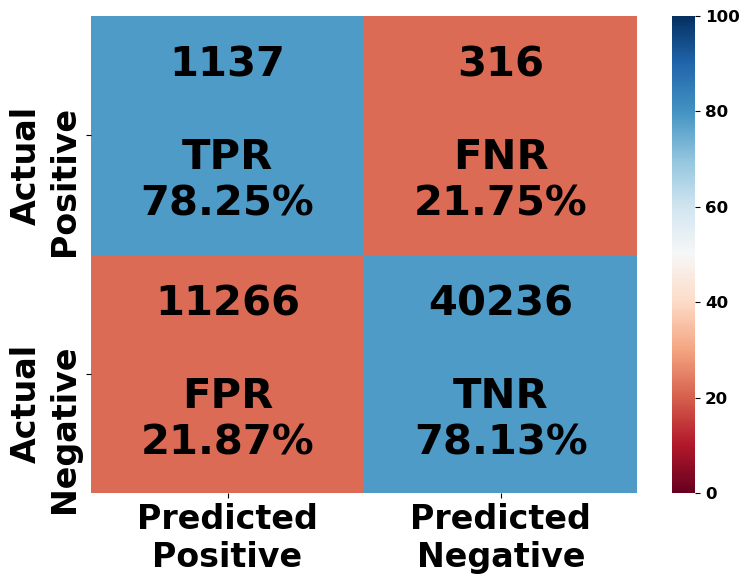

In [46]:
ff = plot_conf_mtx(res_l[4], '')
ff

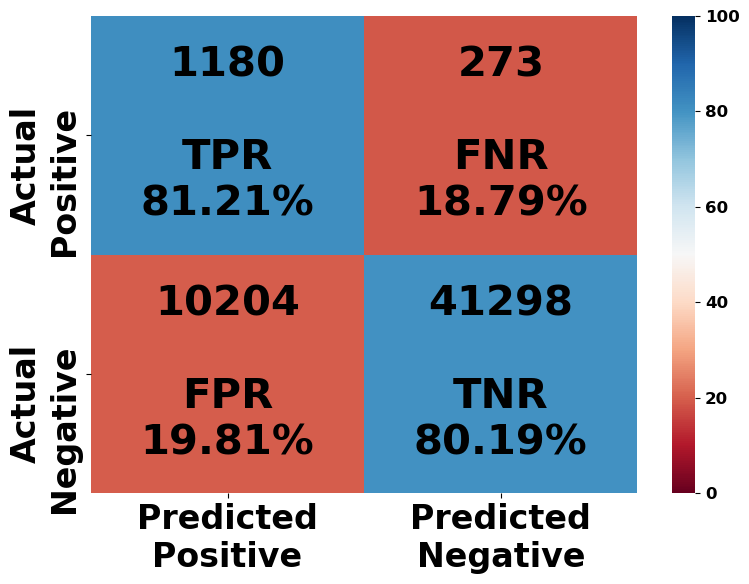

In [47]:
ff = plot_conf_mtx(res_l[-1], '')
ff

In [22]:
ff = plot_conf_mtx(fs_demo_modal, 'Demographics + Cognitive Tests')
# ff.savefig(f'MCI_conf_mtx_{modality}_agecut{age_cutoff}_fsDemoModality.pdf')


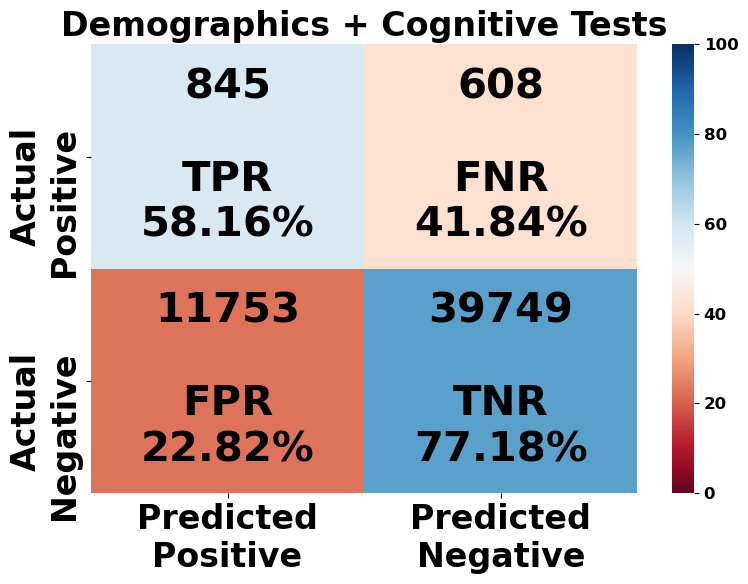

In [23]:
ff

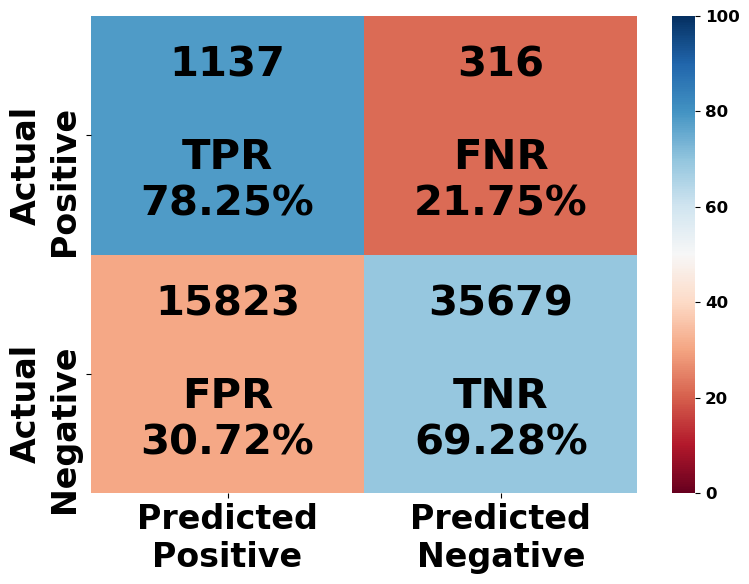

In [11]:
ff = plot_conf_mtx(res_l[0], '')
ff.savefig('conf_mtx_workflow_figure_panel.pdf')
# ff.savefig(f'MCI_conf_mtx_{data_modality}_agecut{age_cutoff}_age_only.pdf')


# Raincloud

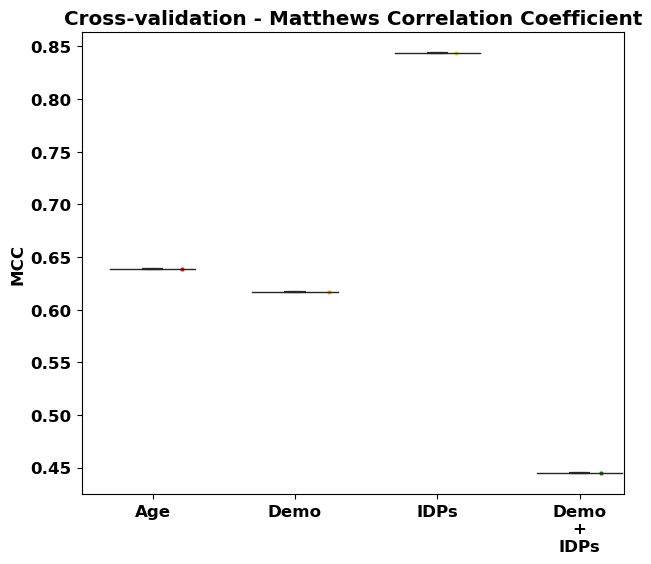

<Figure size 640x480 with 0 Axes>

In [166]:
# Sample data
x = ['Age', 'Demo', 'Proteins', 'Demo\n+\nProteins']#, 'FS\nIDPs', 'FS Demo\n+\nIDPs']


y = [i.mcc for i in res_l]

# Prepare the data for plotting
data = []
for i, category in enumerate(x):
    for value in y[i]:
        # data.append([f'{category} \n STD:{round(std_l[i], 3)}', value])
        data.append([category, value])
data = pd.DataFrame(data, columns=["", "Matthews Correlation Coefficient"])

# Plot
fig, ax = plt.subplots(figsize=(7, 6))

colors = ['red', 'orange', '#FDDA0D', 'green', 'blue', 'purple']

# # Plot using ptitprince
# fig, ax = plt.subplots(figsize=(8, 6))
# ax = pt.RainCloud(x='Category', y='Value', data=data, palette=colors, bw=0.2,
#                   width_viol=0.6, ax=ax, orient='h', alpha=0.65, move=0.2)

pt.RainCloud(x="", y="Matthews Correlation Coefficient", data=data, palette=colors, bw=.2, width_viol=0.6, ax=None, orient="v", alpha=.65, move=.2)
ax.set_ylabel('MCC', fontweight='bold')
plt.title('Cross-validation - Matthews Correlation Coefficient', fontweight='bold')
plt.show()
plt.tight_layout()
fig.savefig(f'mcc_{data_modality}_agecut{age_cutoff}.pdf', dpi=300)

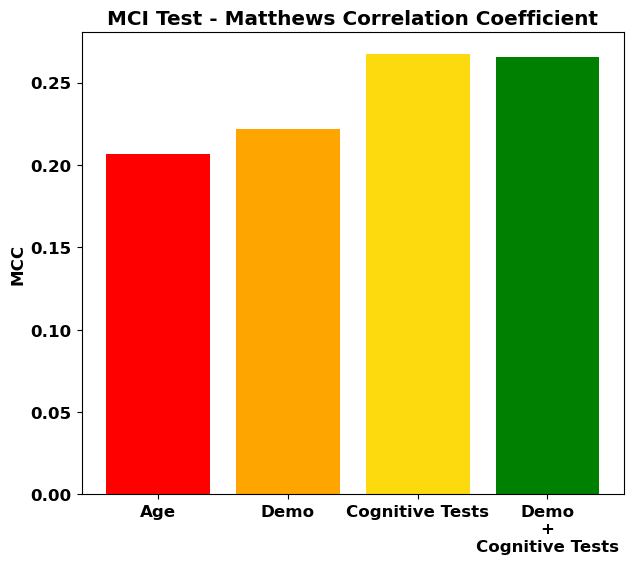

<Figure size 640x480 with 0 Axes>

In [178]:
# Sample data
x = ['Age', 'Demo', 'Cognitive Tests', 'Demo\n+\nCognitive Tests']#, 'FS\nIDPs', 'FS Demo\n+\nIDPs']


y = [i.mcc for i in res_l]

# Prepare the data for plotting
data = []
for i, category in enumerate(x):
    for value in y[i]:
        # data.append([f'{category} \n STD:{round(std_l[i], 3)}', value])
        data.append([category, value])
data = pd.DataFrame(data, columns=["", "Matthews Correlation Coefficient"])

# Plot
fig, ax = plt.subplots(figsize=(7, 6))

colors = ['red', 'orange', '#FDDA0D', 'green', 'blue', 'purple']

# # Plot using ptitprince
# fig, ax = plt.subplots(figsize=(8, 6))
# ax = pt.RainCloud(x='Category', y='Value', data=data, palette=colors, bw=0.2,
#                   width_viol=0.6, ax=ax, orient='h', alpha=0.65, move=0.2)

ax.bar(data[""], height=data["Matthews Correlation Coefficient"], color = colors[:4])#, data=data, bw=.2, width_viol=0.6, orient="v", alpha=.65, move=.2)
ax.set_ylabel('MCC', fontweight='bold')
plt.title('MCI Test - Matthews Correlation Coefficient', fontweight='bold')
plt.show()
plt.tight_layout()
fig.savefig(f'MCI_mcc_{data_modality}_agecut{age_cutoff}.pdf', dpi=300)

In [ ]:
plot_results.plot_pr_curve(true_labels, probas)

In [39]:
len(true_labels[0]), len(probas[1])

(4129, 7525)

In [7]:
import pandas as pd
import numpy as np

res_l = []

res_path = '../../results/dementia/proteomics/demographics_and_modality/feature_selection/log_loss/'
true_labels, probas = ml_utils.concat_labels_and_probas(res_path)

thresholds = np.arange(0, 1.01, 0.01)
for t in thresholds:
    for f in range(10):
        if 'feature_selection' not in res_path:
            res = ml_utils.calc_results(true_labels[0], probas[f], youden=True, beta=1, threshold=t)
        else:
            res = ml_utils.calc_results(true_labels[f], probas[f], youden=True, beta=1, threshold=t)
        res_l.append(res)

df = pd.concat(res_l, axis=1).T

# Function to calculate the mean and standard deviation of every 10 rows
def mean_and_std_of_every_n_rows(df, n=10):
    means = df.groupby(np.arange(len(df)) // n).mean()
    stds = df.groupby(np.arange(len(df)) // n).std()
    
    # Combine means and standard deviations into a single dataframe
    combined = means.copy()
    for column in df.columns:
        combined[f'{column}_std'] = stds[column]
        
    return combined

# Calculate the mean and standard deviation of every 10 rows
result_df = mean_and_std_of_every_n_rows(df, 10)


/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rae330/.conda/envs/pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [9]:
result_df.tail()

auroc  avg_prec  threshold   TP      TN   FP     FN  accuracy  \
96   0.870801  0.240261       0.96  0.0  5150.2  0.0  145.3  0.973134   
97   0.870801  0.240261       0.97  0.0  5150.2  0.0  145.3  0.973134   
98   0.870801  0.240261       0.98  0.0  5150.2  0.0  145.3  0.973134   
99   0.870801  0.240261       0.99  0.0  5150.2  0.0  145.3  0.973134   
100  0.870801  0.240261       1.00  0.0  5150.2  0.0  145.3  0.973134   

     bal_acc    prec_n  ...     FN_std  accuracy_std  bal_acc_std  prec_n_std  \
96       0.5  0.973134  ...  71.783703      0.003595          0.0    0.003595   
97       0.5  0.973134  ...  71.783703      0.003595          0.0    0.003595   
98       0.5  0.973134  ...  71.783703      0.003595          0.0    0.003595   
99       0.5  0.973134  ...  71.783703      0.003595          0.0    0.003595   
100      0.5  0.973134  ...  71.783703      0.003595          0.0    0.003595   

     prec_p_std  recall_n_std  recall_p_std  f1_n_std  f1_p_std  mcc_std  
96          0.0           0.0           0.0  0.001847       0.0      0.0  
97          0.0           0.0           0.0  0.001847       0.0      0.0  
98          0.0           0.0           0.0  0.001847       0.0      0.0  
99          0.0           0.0           0.0  0.001847       0.0      0.0  
100         0.0           0.0           0.0  0.001847       0.0      0.0  

[5 rows x 32 columns]

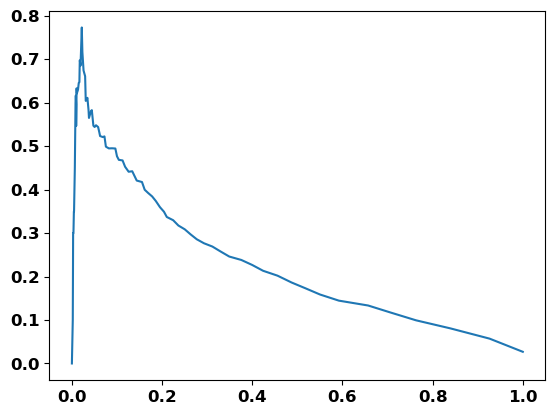

In [41]:
plt.plot(result_df.recall_p, result_df.prec_p)

In [19]:
from sklearn import metrics
metrics.auc(result_df.threshold, result_df.mcc)

0.14227145142897274

In [17]:
result_df.threshold

0      0.00
1      0.01
2      0.02
3      0.03
4      0.04
       ... 
96     0.96
97     0.97
98     0.98
99     0.99
100    1.00
Name: threshold, Length: 101, dtype: float64

0.12


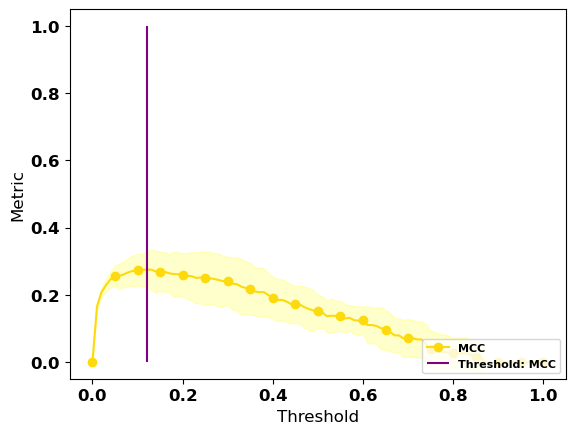

In [15]:
# plt.plot(thresholds, result_df.prec_p, marker='o', color='red', markevery=5, label='PPV')
# plt.fill_between(thresholds, result_df.prec_p - result_df.prec_p_std, result_df.prec_p + result_df.prec_p_std, color='red', alpha=0.2)

# plt.plot(thresholds, result_df.prec_n, marker='o', color='orange', markevery=5, label='NPV')
# plt.fill_between(thresholds, result_df.prec_n - result_df.prec_n_std, result_df.prec_n + result_df.prec_n_std, color='orange', alpha=0.2)

# plt.plot(thresholds, result_df.recall_p, marker='o', color='blue', markevery=5, label='Sensitivity')
# plt.fill_between(thresholds, result_df.recall_p - result_df.recall_p_std, result_df.recall_p + result_df.recall_p_std, color='blue', alpha=0.2)

# plt.plot(thresholds, result_df.recall_n, marker='o', color='green', markevery=5, label='Specificity')
# plt.fill_between(thresholds, result_df.recall_n - result_df.recall_n_std, result_df.recall_n + result_df.recall_n_std, color='green', alpha=0.2)

plt.plot(thresholds, result_df.mcc, marker='o', color='#FDDA0D', markevery=5, label='MCC')
plt.fill_between(thresholds, result_df.mcc - result_df.mcc_std, result_df.mcc + result_df.mcc_std, color='yellow', alpha=0.2)

plt.legend()
sums = result_df.recall_n + result_df.recall_p - 1

# plt.vlines(result_df.threshold.values[np.argmax(result_df.f1_p.values)], color='red', ymin=0, ymax=1, label='Threshold: F1')
plt.vlines(result_df.threshold.values[np.argmax(result_df.mcc.values)], color='purple', ymin=0, ymax=1,  label='Threshold: MCC')
# plt.vlines(result_df.threshold.values[np.argmax(sums)], color='black', ymin=0, ymax=1, label='Threshold: Youden"s J')

print(result_df.threshold.values[np.argmax(result_df.mcc.values)])
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.legend(loc='lower right', fontsize=8)
plt.show()

In [106]:
max(result_df.mcc), np.argmax(result_df.mcc.values)

(0.13581499059767815, 3)

In [44]:
tp = 98
fp = 1000
tn = 900000
fn = 2

rec_p = tp / (tp + fn)
rec_n = tn / (tn + fp)
prec_p = tp / (tp + fp)
prec_n = tn / (tn + fn)
print(rec_p, rec_n, prec_p, prec_n, ml_utils.mcc_from_conf_mtx(tp, fp, tn, fn))

0.98 0.9988901220865705 0.08925318761384335 0.999997777782716 0.29557890387066243


In [109]:
result_df.loc[:,['threshold','mcc']].head()

threshold       mcc
0       0.00  0.000000
1       0.01  0.096872
2       0.02  0.119166
3       0.03  0.135815
4       0.04  0.119005

In [2]:
# from sklearn.cluster import KMeans
modality='neuroimaging'
X = pd.read_parquet(f'../tidy_data/dementia/{modality}/X.parquet')
y = np.load(f'../tidy_data/dementia/{modality}/y.npy')

In [58]:
X.columns[:20]

Index(['eid', '21003-2.0', '54-2.0', '845-0.0', '25000-2.0', '25001-2.0',
       '25002-2.0', '25003-2.0', '25004-2.0', '25005-2.0', '25006-2.0',
       '25007-2.0', '25008-2.0', '25009-2.0', '25010-2.0', '25011-2.0',
       '25012-2.0', '25013-2.0', '25014-2.0', '25015-2.0'],
      dtype='object')

In [63]:
# 26521	Volume of EstimatedTotalIntraCranial (whole brain)

# 26755	Mean thickness of GlobalMeanMean thickness (left hemisphere)
# 26856	Mean thickness of GlobalMeanMean thickness (right hemisphere)

# 26641	Volume of Whole-hippocampus (left hemisphere)	Freesurfer subsegmentation  
# 26663	Volume of Whole-hippocampus (right hemisphere)	Freesurfer subsegmentation  

# 25381	Mean ICVF in cingulum hippocampus on FA skeleton (left)	dMRI skeleton  
# 25380	Mean ICVF in cingulum hippocampus on FA skeleton (right)	dMRI skeleton  

sub = df_utils.pull_columns_by_prefix(X, ['25381', '25380', '26755', '26856', '26521', '26641', '26663', 'apoe', '31-', '21003', '21000-0.0', 'max_educ', '845'])
sub.columns

Index(['21003-2.0', '845-0.0', '25380-2.0', '25381-2.0', '26521-2.0',
       '26641-2.0', '26663-2.0', '26755-2.0', '26856-2.0', '31-0.0_1.0',
       '21000-0.0_-3.0', '21000-0.0_-1.0', '21000-0.0_1.0', '21000-0.0_2.0',
       '21000-0.0_3.0', '21000-0.0_5.0', '21000-0.0_6.0', '21000-0.0_1001.0',
       '21000-0.0_1002.0', '21000-0.0_1003.0', '21000-0.0_2001.0',
       '21000-0.0_2002.0', '21000-0.0_2003.0', '21000-0.0_2004.0',
       '21000-0.0_3001.0', '21000-0.0_3002.0', '21000-0.0_3003.0',
       '21000-0.0_3004.0', '21000-0.0_4001.0', '21000-0.0_4002.0',
       '21000-0.0_4003.0', '21000-0.0_nan', 'apoe_polymorphism_0.0',
       'apoe_polymorphism_1.0', 'apoe_polymorphism_2.0',
       'apoe_polymorphism_nan', 'max_educ_complete_-7.0',
       'max_educ_complete_-3.0', 'max_educ_complete_1.0',
       'max_educ_complete_2.0', 'max_educ_complete_3.0',
       'max_educ_complete_4.0', 'max_educ_complete_5.0',
       'max_educ_complete_6.0', 'max_educ_complete_nan'],
      dtype='object'

In [ ]:
skf = StratifiedKFold(n_splits=10)
train_res_l = []
test_res_l = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    


    current_time = datetime.now().time()
    print(f'{current_time}')

    X_test = sub.iloc[test_index, :]
    y_test = y[test_index]

    X_train = sub.iloc[train_index, :]
    y_train = y[train_index]
    print('made train and test split')

    automl = AutoML()
    # automl.fit(X_train, y_train, task="classification", time_budget=time_budget, metric=metric, n_jobs=-1,
    #                 max_iter=None, early_stop=True, append_log=True, log_file_name=f'{directory_path}/results_log_{i}.json')

    automl.fit(X_train, y_train, task="classification", time_budget=20, metric='log_loss',
            n_jobs=-1, eval_method='cv', n_splits=10, split_type='stratified',
            log_training_metric=True, early_stop=True,
            seed=239875, model_history=True, estimator_list=['lgbm'])

    print('Done fitting model')

   

    train_probas = automl.predict_proba(X_train)[:,1]

    # if metric == 'roc_auc':
    train_res, threshold = ml_utils.calc_results('log_loss', y_train, train_probas, beta=3)
    train_res_l.append(train_res)
    # elif metric == f3.f3_metric or metric == 'ap':
    #     train_res, threshold = ml_utils.calc_results(y_train, train_probas, beta=3)

   
    # train_res_l.append(train_res)
   
    test_probas = automl.predict_proba(X_test)[:,1]

    # if metric == 'roc_auc':
    test_res = ml_utils.calc_results('log_loss', y_test, test_probas, beta=3, threshold=threshold)
    test_res_l.append(test_res)

In [28]:
apoe_age_sex = pd.concat(test_res_l, axis=1).T
print(np.mean(apoe_age_sex.auroc), np.std(apoe_age_sex.auroc))

0.7644337120024294 0.08086510464754543


In [ ]:
apoe_age_sex, eitv_apoe_age_sex, age, global_cortical_thickness_leftandright_apoe_age_sex, global_cortical_thickness_leftandright_apoe_sex,
 bilateral_hipp_vol_apoe_age_sex, eitv_globCortThickLR_bilathippvol_apoe_age_sex, eitv_globCortThickLR_bilathippvol_apoe_sex, all_idp_age_sex_educ_apoe, all_idp_age_sex_educ_apoe_ethnic

In [32]:
eitv_apoe_age_sex = pd.concat(test_res_l, axis=1).T
print(np.mean(eitv_apoe_age_sex.auroc), np.std(eitv_apoe_age_sex.auroc))

0.7648341274307027 0.0792233878561299


In [35]:
age = pd.concat(test_res_l, axis=1).T
print(np.mean(age.auroc), np.std(age.auroc))

0.7424668701355428 0.07724876121090628


In [38]:
global_cortical_thickness_leftandright_apoe_age_sex = pd.concat(test_res_l, axis=1).T
print(np.mean(global_cortical_thickness_leftandright_apoe_age_sex.auroc), np.std(global_cortical_thickness_leftandright_apoe_age_sex.auroc))

0.8136842514284174 0.06575194261369148


In [41]:
global_cortical_thickness_leftandright_apoe_sex = pd.concat(test_res_l, axis=1).T
print(np.mean(global_cortical_thickness_leftandright_apoe_sex.auroc), np.std(global_cortical_thickness_leftandright_apoe_sex.auroc))

0.7605710732702912 0.05504734602501119


In [47]:
bilateral_hipp_vol_apoe_age_sex = pd.concat(test_res_l, axis=1).T
print(np.mean(bilateral_hipp_vol_apoe_age_sex.auroc), np.std(bilateral_hipp_vol_apoe_age_sex.auroc))

0.8154418258175375 0.09005071445452492


In [50]:
eitv_globCortThickLR_bilathippvol_apoe_age_sex = pd.concat(test_res_l, axis=1).T
print(np.mean(eitv_globCortThickLR_bilathippvol_apoe_age_sex.auroc), np.std(eitv_globCortThickLR_bilathippvol_apoe_age_sex.auroc))

0.8439033478366372 0.07397384181276676


In [53]:
eitv_globCortThickLR_bilathippvol_apoe_sex = pd.concat(test_res_l, axis=1).T
print(np.mean(eitv_globCortThickLR_bilathippvol_apoe_sex.auroc), np.std(eitv_globCortThickLR_bilathippvol_apoe_sex.auroc))

0.8311939453323836 0.07759440524573508


In [61]:
all_idp_age_sex_educ_apoe = pd.concat(test_res_l, axis=1).T
print(np.mean(all_idp_age_sex_educ_apoe.auroc), np.std(all_idp_age_sex_educ_apoe.auroc))

0.8466746809875854 0.05479900219323482


In [65]:
all_idp_age_sex_educ_apoe_ethnic = pd.concat(test_res_l, axis=1).T
print(np.mean(all_idp_age_sex_educ_apoe_ethnic.auroc), np.std(all_idp_age_sex_educ_apoe_ethnic.auroc))

0.850605951947705 0.05327168508158296


In [69]:
df_test_res = []

for i in range(10):
    df = pd.read_csv(f'../results/dementia/proteomics/demographics_and_modality/roc_auc/test_results_region_{i}.csv')
    df_test_res.append(df)

df_test_res = pd.concat(df_test_res)

In [75]:
df_test_res['perc_cases'] = 100 * ((df_test_res.TP + df_test_res.FN) / (df_test_res.TP + df_test_res.FN + df_test_res.FP + df_test_res.TN))
df_test_res['mcc'] = (df_test_res.TP * df_test_res.TN - df_test_res.FP * df_test_res.FN) / np.sqrt( (df_test_res.TP + df_test_res.FP) * (df_test_res.TP + df_test_res.FN) * (df_test_res.TN + df_test_res.FP) * (df_test_res.TN + df_test_res.FN) )

In [76]:
df_test_res

Unnamed: 0           model  \
0           0            lgbm   
0           0            lgbm   
0           0            lgbm   
0           0            lgbm   
0           0            lgbm   
0           0  xgb_limitdepth   
0           0         xgboost   
0           0            lgbm   
0           0         xgboost   
0           0            lgbm   

                                         hyperparams     auroc  avg_prec  \
0  {'n_estimators': 571, 'num_leaves': 4, 'min_ch...  0.836851  0.265481   
0  {'n_estimators': 1028, 'num_leaves': 21, 'min_...  0.873136  0.203876   
0  {'n_estimators': 519, 'num_leaves': 4, 'min_ch...  0.876209  0.205806   
0  {'n_estimators': 1979, 'num_leaves': 76, 'min_...  0.865400  0.289837   
0  {'n_estimators': 481, 'num_leaves': 4, 'min_ch...  0.899000  0.278582   
0  {'n_estimators': 266, 'max_depth': 9, 'min_chi...  0.857512  0.205579   
0  {'n_estimators': 259, 'max_leaves': 11, 'min_c...  0.879994  0.276743   
0  {'n_estimators': 14559, 'num_leaves': 19, 'min...  0.848007  0.183830   
0  {'n_estimators': 924, 'max_leaves': 498, 'min_...  0.870697  0.207955   
0  {'n_estimators': 233, 'num_leaves': 4, 'min_ch...  0.884953  0.323267   

   threshold     TP      TN      FP     FN  accuracy   bal_acc    prec_n  \
0   0.048327   74.0  3519.0   489.0   47.0  0.870186  0.744782  0.986820   
0   0.996693    0.0  7365.0     0.0  160.0  0.978738  0.500000  0.978738   
0   0.053353  114.0  5418.0   669.0   68.0  0.882437  0.758234  0.987605   
0   0.999446    0.0  8111.0     0.0  273.0  0.967438  0.500000  0.967438   
0   0.041429   73.0  3094.0   521.0   24.0  0.853179  0.804228  0.992303   
0   0.031957   72.0  3224.0   621.0   33.0  0.834430  0.762103  0.989868   
0   0.065799   54.0  3572.0   247.0   52.0  0.923822  0.722379  0.985651   
0   0.992384    0.0  2122.0     0.0   51.0  0.976530  0.500000  0.976530   
0   0.767804    0.0  4456.0     0.0  104.0  0.977193  0.500000  0.977193   
0   0.031516  207.0  6318.0  1756.0   47.0  0.783501  0.798736  0.992616   

     prec_p  recall_n  recall_p      f3_n      f3_p  perc_cases       mcc  
0  0.131439  0.877994  0.611570  0.887784  0.447942    2.930492  0.240614  
0  0.000000  1.000000  0.000000  0.997832  0.000000    2.126246       NaN  
0  0.145594  0.890094  0.626374  0.898970  0.470880    2.903174  0.262284  
0  0.000000  1.000000  0.000000  0.996645  0.000000    3.256202       NaN  
0  0.122896  0.855878  0.752577  0.867809  0.497614    2.613147  0.264751  
0  0.103896  0.838492  0.685714  0.851513  0.439560    2.658228  0.221702  
0  0.179402  0.935323  0.509434  0.940124  0.430279    2.700637  0.270940  
0  0.000000  1.000000  0.000000  0.997602  0.000000    2.346986       NaN  
0  0.000000  1.000000  0.000000  0.997672  0.000000    2.280702       NaN  
0  0.105451  0.782512  0.814961  0.799433  0.487173    3.049952  0.242058

In [40]:
np.mean(df_test_res.recall_n), np.mean(df_test_res.recall_p)

(0.6870327144547914, 0.7646652494619199)

In [84]:
res_d = {}

std_l = []

filepath='../results/dementia/cognitive_tests/'
age65_cutoff=True
# for i,expt, in enumerate(['age_only', 'all_demographics', 'modality_only/feature_selection', 'demographics_and_modality/feature_selection', 'modality_only', 'demographics_and_modality', ]):

for i,expt, in enumerate(['age_only', 'all_demographics',  'modality_only', 'demographics_and_modality', ]):
        if age65_cutoff==False:
            dirpath = f'{filepath}/{expt}/log_loss/'
        else:
            dirpath = f'{filepath}/{expt}/log_loss/agecutoff_65/'

        res_l = []
        for j in range(10):
            # print(i)
        
            df = pd.read_csv(f'{dirpath}/test_results_region_{j}.csv')

            test_labels = pickle.load(open(f'{dirpath}/test_true_labels_region_{j}.pkl', 'rb'))
            test_probas = pickle.load(open(f'{dirpath}/test_probas_region_{j}.pkl', 'rb'))
            test_pred = [int(x >= df.threshold[0]) for x in test_probas[0]]

            mcc = matthews_corrcoef(test_labels[0], test_pred)
            res_l.append(mcc)
        
        std_l.append(np.std(res_l)) 

        res_d[f'{expt}'] = res_l

FileNotFoundError: [Errno 2] No such file or directory: '../results/dementia/cognitive_tests//demographics_and_modality/log_loss/agecutoff_65//test_results_region_4.csv'

In [77]:
res_d

{'age_only': [0.1497745553241104,
  0.15929026900608367,
  0.14921906040278468,
  0.16463681535813546,
  0.17077655528919583,
  0.14777595605343452,
  0.16029609948615675,
  0.14246071163413512,
  0.14775103635014994,
  0.16798720824877078],
 'all_demographics': [0.17149021891437005,
  0.16924937439991625,
  0.16930228767177963,
  0.18196028005594242,
  0.1747704227428423,
  0.1574112665665784,
  0.16678312222127883,
  0.15358040894087807,
  0.16495923624158967,
  0.19433438743921716],
 'modality_only/feature_selection': [0.14007030662582373,
  0.12000248605812976,
  0.11664184074642305,
  0.10409428608039999,
  0.11956478171723671,
  0.10813066767399865,
  0.11054616631184527,
  0.10857491521608827,
  0.09554875738715121,
  0.1332238020321382],
 'demographics_and_modality/feature_selection': [0.13156407090061129,
  0.1047026828236211,
  0.10085071897271336,
  0.145055129682229,
  0.1327719520952786,
  0.14777595605343452,
  0.09719347017111532,
  0.10206219189680164,
  0.1477510363501

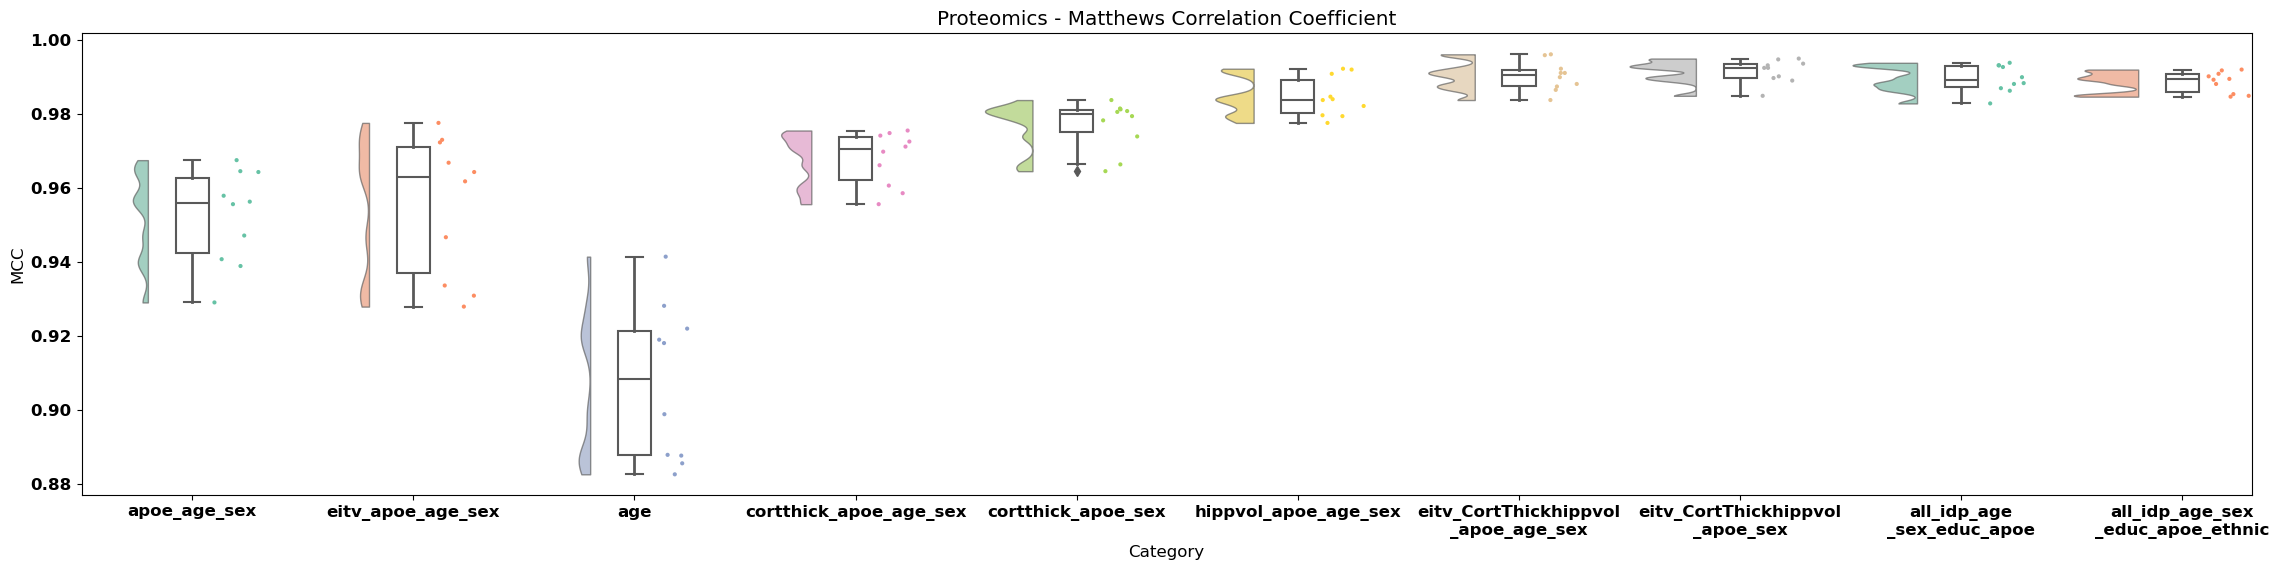

In [80]:
# Sample data
x = ['apoe_age_sex', 'eitv_apoe_age_sex', 'age', 'cortthick_apoe_age_sex', 'cortthick_apoe_sex',
 'hippvol_apoe_age_sex', 'eitv_CortThickhippvol\n_apoe_age_sex', 'eitv_CortThickhippvol\n_apoe_sex', 'all_idp_age\n_sex_educ_apoe', 'all_idp_age_sex\n_educ_apoe_ethnic']


y = [i.recall_n for i in [apoe_age_sex, eitv_apoe_age_sex, age, global_cortical_thickness_leftandright_apoe_age_sex, global_cortical_thickness_leftandright_apoe_sex,
 bilateral_hipp_vol_apoe_age_sex, eitv_globCortThickLR_bilathippvol_apoe_age_sex, eitv_globCortThickLR_bilathippvol_apoe_sex, all_idp_age_sex_educ_apoe, all_idp_age_sex_educ_apoe_ethnic]]

# Prepare the data for plotting
data = []
for i, category in enumerate(x):
    for value in y[i]:
        # data.append([f'{category} \n STD:{round(std_l[i], 3)}', value])
        data.append([category, value])
data = pd.DataFrame(data, columns=["Category", "MCC"])

# Plot
plt.figure(figsize=(28, 6))
ax = pt.RainCloud(x="Category", y="MCC", data=data, palette="Set2", bw=.2, width_viol=0.6, ax=None, orient="v", alpha=.65, move=.2)
plt.title('Proteomics - Matthews Correlation Coefficient')
plt.show()


In [30]:
res_l = []
for expt in ['age_only', 'all_demographics', 'modality_only', 'demographics_and_modality', 'modality_only/feature_selection', 'demographics_and_modality/feature_selection']:
    res = ml_utils.probas_to_results(f'../results/dementia/neuroimaging/{expt}/log_loss/', youden=True)
    res_l.append(res)

AUROC: 0.6861, AP: 0.0056, 
Accuracy: 0.8876, Bal. Acc.: 0.6528, 
Best threshold: 0.0062
Precision/Recall/Fscore: (array([0.99820236, 0.0101833 ]), array([0.88886348, 0.41666667]), array([0.94036531, 0.01988072]), array([4373,   12]))


AUROC: 0.7813, AP: 0.0083, 
Accuracy: 0.6919, Bal. Acc.: 0.7624, 
Best threshold: 0.0041
Precision/Recall/Fscore: (array([0.99933906, 0.00735835]), array([0.69151612, 0.83333333]), array([0.81740776, 0.01458789]), array([4373,   12]))


AUROC: 0.5958, AP: 0.0046, 
Accuracy: 0.6826, Bal. Acc.: 0.6331, 
Best threshold: 0.0041
Precision/Recall/Fscore: (array([0.99832832, 0.00502152]), array([0.68282643, 0.58333333]), array([0.8109723 , 0.00995733]), array([4373,   12]))


AUROC: 0.7792, AP: 0.0091, 
Accuracy: 0.8869, Bal. Acc.: 0.7132, 
Best threshold: 0.009
Precision/Recall/Fscore: (array([0.99845679, 0.01408451]), array([0.88792315, 0.53846154]), array([0.93995157, 0.02745098]), array([4372,   13]))


AUROC: 0.814, AP: 0.0091, 
Accuracy: 0.688, Bal. Acc.

In [39]:
val = 'mcc'

for i,df in enumerate(res_l):
    print(np.median(df[val]), np.std(df[val]))

0.05616211746291443 0.020320862337011778
0.06233908187214446 0.019069884613511567
0.09512743390753503 0.029109951861430634
0.09850390278647242 0.04684399086763234
0.11726571377708164 0.03456512761564687
0.11823915548328927 0.047703324553067895


0.7371794871794871 0.17167044862841535
0.7307692307692307 0.16715903603083715
0.8711538461538462 0.11324403315568062
0.8487179487179487 0.06028368177183975
0.8724358974358974 0.09148718308037249
0.8641025641025643 0.08532145195884533


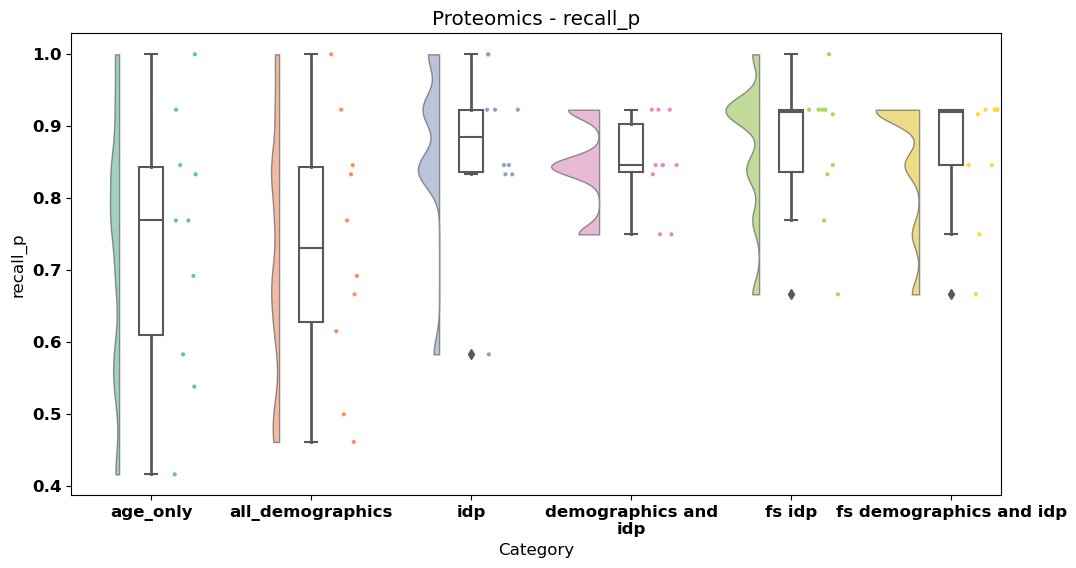

In [45]:
# Sample data
x = ['age_only', 'all_demographics', 'idp', 'demographics and\nidp', 'fs idp', 'fs demographics and idp']

val = 'recall_p'
y = [i[val] for i in res_l]

for i,df in enumerate(res_l):
    print(np.mean(df[val]), np.std(df[val]))

# Prepare the data for plotting
data = []
for i, category in enumerate(x):
    for value in y[i]:
        # data.append([f'{category} \n STD:{round(std_l[i], 3)}', value])
        data.append([category, value])
data = pd.DataFrame(data, columns=["Category", val])

# Plot
plt.figure(figsize=(12, 6))
ax = pt.RainCloud(x="Category", y=val, data=data, palette="Set2", bw=.2, width_viol=0.6, ax=None, orient="v", alpha=.65, move=.2)
plt.title(f'Proteomics - {val}')
plt.show()


In [19]:
plt.show()

In [17]:
ages = X['21003-0.0'].values.tolist()

In [28]:
unique_ages = list(set(ages))
youden_j = []
p_recall = []
n_recall = []

for age in unique_ages:
    pred = [int(a >= age) for a in ages]
    pos_recall = recall_score(y, pred)
    p_recall.append(pos_recall)

    neg_recall = recall_score(y, pred, pos_label=0)
    n_recall.append(neg_recall)

    youden_j.append(pos_recall + neg_recall - 1)


In [29]:
youden_j[np.argmax(youden_j)], unique_ages[np.argmax(youden_j)], p_recall[np.argmax(youden_j)], n_recall[np.argmax(youden_j)]

(0.46697279785444823, 63.0, 0.7543014452856159, 0.7126713525688323)

In [34]:
pred = [int(a >= 58) for a in ages]
print(classification_report(y, pred))

              precision    recall  f1-score   support

           0       1.00      0.49      0.65     51502
           1       0.05      0.91      0.09      1453

    accuracy                           0.50     52955
   macro avg       0.52      0.70      0.37     52955
weighted avg       0.97      0.50      0.64     52955



In [29]:
from sklearn.metrics import confusion_matrix, roc_auc_score, \
     precision_recall_fscore_support

import scipy.stats as st 



res_d = {}

n_bootstrap = 1000
n_cases = []
ci_l = []
for i in range(10):
    # print(i)
    res_l = []
    test_labels = pickle.load(open(f'../results/dementia/{modality}/demographics_and_modality/roc_auc/test_true_labels_region_{i}.pkl', 'rb'))[0]
    n_cases.append(sum(test_labels))

    # test_probas = pickle.load(open(f'../results/dementia/{modality}/demographics_and_modality/roc_auc/test_probas_region_{i}.pkl', 'rb'))[0]

    # bootstraps = np.array([np.random.choice(range(len(test_labels)),
    #                        len(test_labels), replace=True)
    #                        for _ in range(n_bootstrap)])
    # for j, bs_index in enumerate(bootstraps):
        # if j % 100 == 0:
        #     print(j)
        # yhat = test_probas[bs_index]
        # y_bs = test_labels[bs_index]

    auroc = roc_auc_score(test_labels,
                            np.random.normal(loc=0.2, scale=0.1, size=len(test_labels)))
    print(auroc)

    #     res_l.append(auroc)

    # ci_l.append(st.norm.interval(confidence=0.95, 
    #           loc=np.mean(res_l), 
    #           scale=st.sem(res_l))) 

    # res_d[f'region_{i}'] = res_l

0.5203869121261608
0.4726103190767142
0.491617877768691
0.48607214098522206
0.5061584748542014
0.4950052634838071
0.4633263671710959
0.4667350446304817
0.55955669106477
0.5252579973824798


<Figure size 640x480 with 0 Axes>

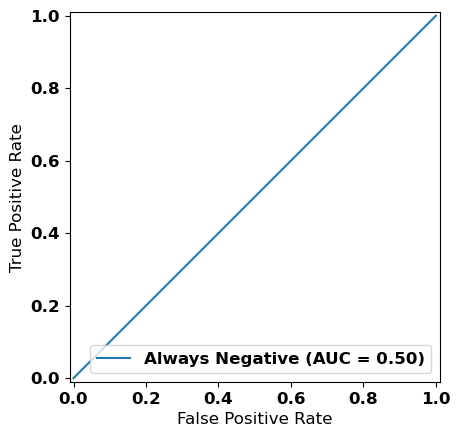

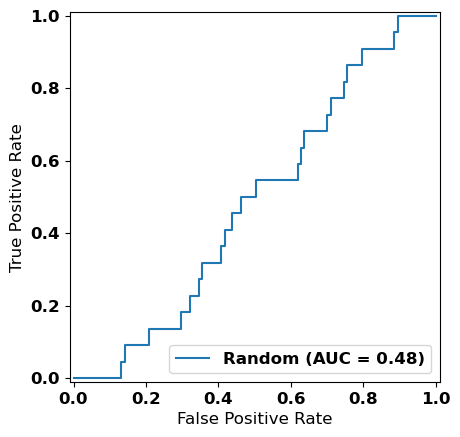

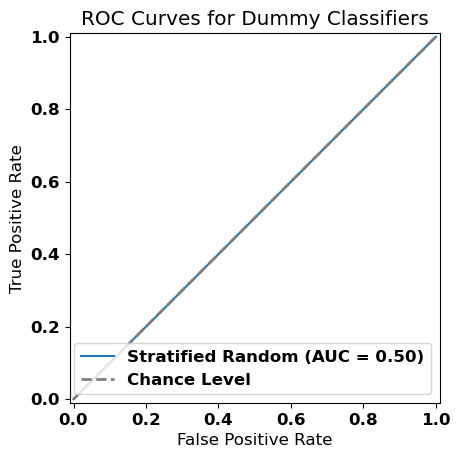

In [30]:
import numpy as np
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# Step 1: Generate true labels with high class imbalance
np.random.seed(42)  # For reproducibility
n_samples = 1000
positive_rate = 0.03
true_labels = np.random.choice([0, 1], size=n_samples, p=[1 - positive_rate, positive_rate])

# Step 2: Generate probabilities for each dummy classifier

# Always Negative Classifier
always_negative_prob = np.zeros(n_samples)

# Random Classifier
random_probabilities = np.random.rand(n_samples)

# Stratified Random Classifier
stratified_probabilities = np.full(n_samples, positive_rate)

# Step 3: Compute ROC curves and AUCs
def compute_roc_auc(true_labels, probabilities, label):
    fpr, tpr, _ = roc_curve(true_labels, probabilities)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=label).plot()

plt.figure()
compute_roc_auc(true_labels, always_negative_prob, 'Always Negative')
compute_roc_auc(true_labels, random_probabilities, 'Random')
compute_roc_auc(true_labels, stratified_probabilities, 'Stratified Random')

# Plot the chance line
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--', label='Chance Level')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Dummy Classifiers')
plt.legend(loc='lower right')
plt.show()


(array([   5.,   57.,  323., 1209., 2612., 2967., 1978.,  682.,  156.,
          11.]),
 array([0.70526798, 0.72897732, 0.75268666, 0.776396  , 0.80010534,
        0.82381468, 0.84752402, 0.87123336, 0.8949427 , 0.91865204,
        0.94236138]),
 <BarContainer object of 10 artists>)

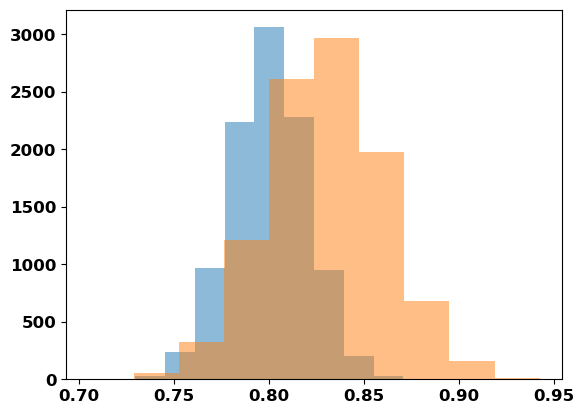

In [42]:
plt.hist(np.random.normal(loc=0.8, scale=0.02, size=10000), alpha=0.5)
plt.hist(np.random.normal(loc=0.83, scale=0.03, size=10000), alpha=0.5)

In [42]:
cv_res = []

for i in range(10):
    test_res = pd.read_csv(f'../results/dementia/{modality}/demographics_and_modality/roc_auc/test_results_region_{i}.csv')
    cv_res.append(test_res.auroc[0])

ci_l.append(st.norm.interval(confidence=0.95, 
              loc=np.mean(cv_res), 
              scale=st.sem(cv_res))) 
res_d['cv'] = cv_res

In [16]:
cv_res

[0.8368510912060177,
 0.8731356076035302,
 0.8762088905016456,
 0.8653996313964257,
 0.8990004420299155,
 0.8575119202427395,
 0.879994268972911,
 0.848006874757443,
 0.870697244855683,
 0.8849534522205038]

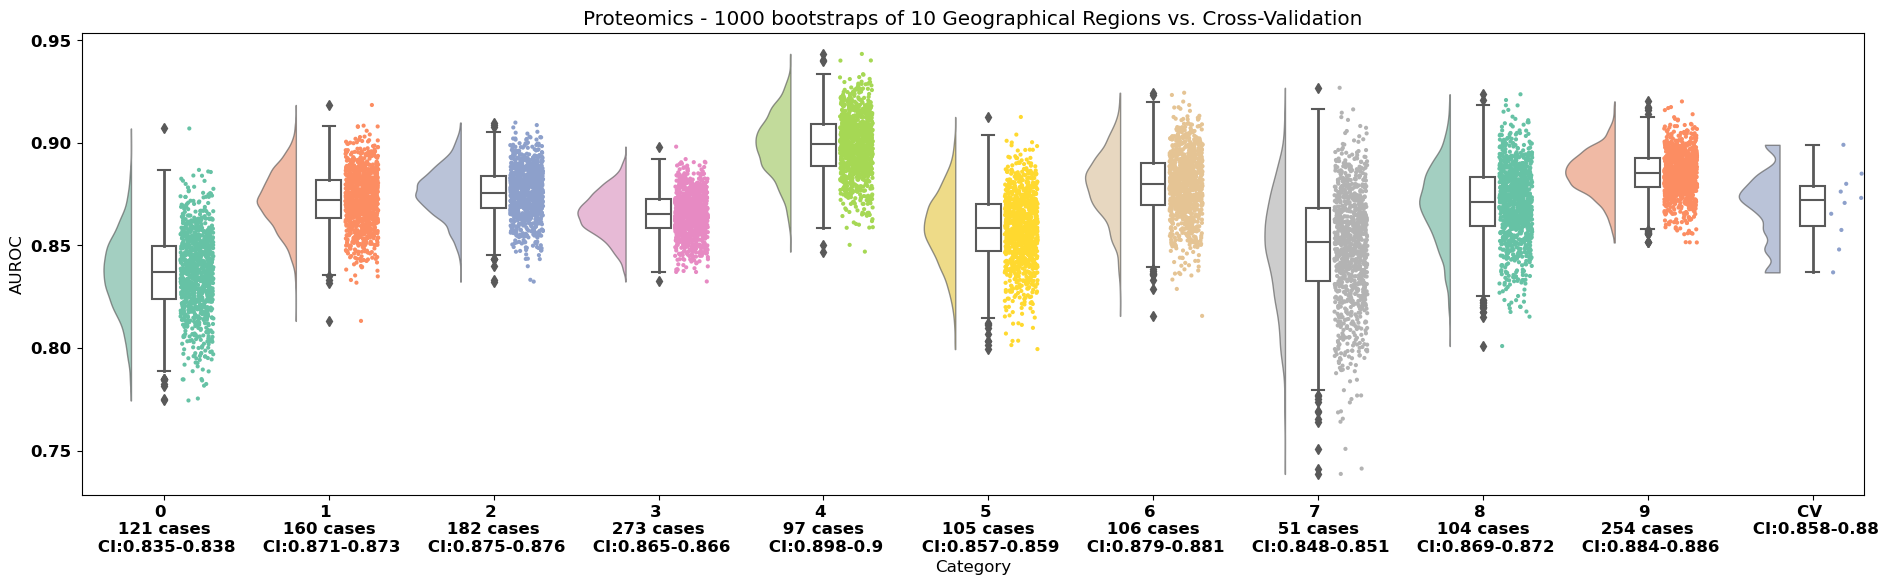

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt

# Sample data
x = list(range(10)) + ['CV']
y = [res_d[f'region_{i}'] for i in range(10)] + [res_d['cv']]

# Prepare the data for plotting
data = []
for i, category in enumerate(x):
    for value in y[i]:
        if category != 'CV':
            data.append([f'{category} \n {n_cases[i]} cases \n CI:{round(ci_l[i][0], 3)}-{round(ci_l[i][1], 3)}', value])
        else:
            data.append([f'{category} \n CI:{round(ci_l[i][0], 3)}-{round(ci_l[i][1], 3)}', value])
data = pd.DataFrame(data, columns=["Category", "AUROC"])

# Plot
plt.figure(figsize=(23, 6))
ax = pt.RainCloud(x="Category", y="AUROC", data=data, palette="Set2", bw=.2, width_viol=0.6, ax=None, orient="v", alpha=.65, move=.2)
plt.title('Proteomics - 1000 bootstraps of 10 Geographical Regions vs. Cross-Validation')
plt.show()


In [39]:
ci_l[0]

(0.8352690625396644, 0.8376190336177964)

In [5]:
data_instance = 0
#  X = X.drop(columns=['eid'])
sixtyfive_and_older_X = X[X[f'21003-{data_instance}.0'] >= 65]
sixtyfive_and_older_y = y[X[f'21003-{data_instance}.0'] >= 65]

X_train, X_test, y_train, y_test = train_test_split(
sixtyfive_and_older_X, sixtyfive_and_older_y, stratify=sixtyfive_and_older_y, test_size=0.3, random_state=10000)

under_sixtyfive_X = X[X[f'21003-{data_instance}.0'] < 65]
under_sixtyfive_y = y[X[f'21003-{data_instance}.0'] < 65]

X_train = np.concatenate((under_sixtyfive_X, X_train), axis=0)
y_train = np.concatenate((under_sixtyfive_y, y_train))

In [11]:
automl = AutoML()
time_budget=600
metric='roc_auc'
automl.fit(X_train, y_train, task="classification", time_budget=time_budget, metric=metric, n_jobs=-1,
                    max_iter=None, early_stop=True)

[flaml.automl.logger: 07-16 15:21:59] {1680} INFO - task = classification
[flaml.automl.logger: 07-16 15:21:59] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 07-16 15:22:09] {1789} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 07-16 15:22:09] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-16 15:22:09] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-16 15:22:25] {2345} INFO - Estimated sufficient time budget=691434s. Estimated necessary time budget=16975s.
[flaml.automl.logger: 07-16 15:22:25] {2392} INFO -  at 25.4s,	estimator lgbm's best error=0.2028,	best estimator lgbm's best error=0.2028
[flaml.automl.logger: 07-16 15:22:25] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-16 15:22:41] {2392} INFO -  at 42.4s,	estimator lgbm's best error=0.1658,	best estimator lgbm's best error=0.1658
[flaml.auto

ValueError: Input X contains NaN.
ExtraTreesClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [8]:
y2 = y[X['21003-0.0'] >= 65]

In [10]:
sum(y2), sum(y), len(y2), len(y), (sum(y)/len(y)), (sum(y2)/len(y2))

(917, 1453, 11090, 52955, 0.027438391086771787, 0.08268710550045086)

In [16]:
num_cases = []
for i in range(10000):
    t = np.random.choice(y2, replace=False, size=int(0.1*len(y2)))
    num_cases.append(sum(t))

(array([  36.,  248.,  924., 1995., 2680., 2357., 1213.,  424.,  105.,
          18.]),
 array([ 64.,  70.,  76.,  82.,  88.,  94., 100., 106., 112., 118., 124.]),
 <BarContainer object of 10 artists>)

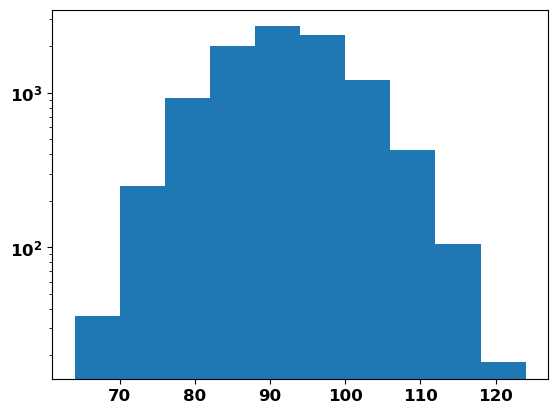

In [17]:
plt.hist(num_cases, log=True)

In [5]:
# Example usage with two vectors
vector1 = list(range(0,25))
vector2 = list(range(0,40))

unique_values = []
for i in range(len(vector1)):
    for j in range(len(vector2)):
        unique_value = i * len(vector2) + j
        unique_values.append(unique_value)

print(unique_values)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [18]:
X = X.drop(columns=['eid', '54-0.0'])
X = X.iloc[:,:-36]

In [4]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)
Xnew = imputer.fit_transform(X)

In [6]:
import numpy as np
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X2 = imp.fit_transform(X)

In [5]:
Xcomplete = X.dropna(axis = 0, how = 'any')


In [6]:
X.shape, Xcomplete.shape

((43850, 3947), (17561, 3947))

In [7]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(X2)

In [9]:
kmeans.

array([2, 0, 3, ..., 1, 4, 3], dtype=int32)

In [23]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

ad_X = X.iloc[y==1,:]

# Handle NaN values
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(ad_X)

# Standardize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(data_pca)


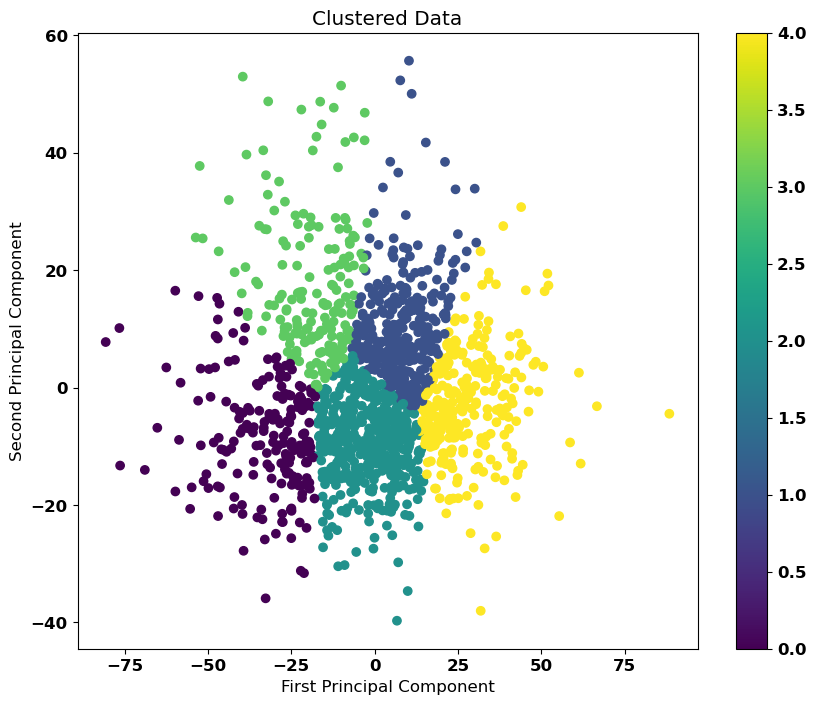

In [24]:

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='viridis')
plt.title('Clustered Data')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)
plt.show()

In [4]:
import plotly.io as pio
pio.renderers.default = 'notebook'  # or 'notebook_connected'


In [33]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

# Ensure Plotly displays in Jupyter
pio.renderers.default = 'notebook'

# Define the function
def my_function(sensitivity, specificity, prevalence):
    return (sensitivity * prevalence) / ((sensitivity * prevalence) + ((1-specificity) * (1-prevalence)))

# Define ranges for sensitivity, specificity, prevalence
sensitivity = np.linspace(0.7, 1, 20)
specificity = np.linspace(0.7, 1, 20)
prevalence = np.linspace(0, 0.2, 20)

# Create a meshgrid
se, sp, pr = np.meshgrid(sensitivity, specificity, prevalence)

# Flatten the grid arrays
x_flat = se.flatten()
y_flat = sp.flatten()
z_flat = pr.flatten()

# Compute the output of the function for each point in the grid
output = my_function(x_flat, y_flat, z_flat)

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x_flat,
    y=y_flat,
    z=z_flat,
    mode='markers',
    marker=dict(
        size=5,
        color=output,  # set color to the output values
        colorscale='RdBu',  # choose a colorscale
        colorbar=dict(title='PPV')
    )
)])

fig.update_layout(scene=dict(
                    xaxis_title='Sensitivity',
                    yaxis_title='Specificity',
                    zaxis_title='Prevalence'),
                    width=800,
                    margin=dict(r=20, b=10, l=10, t=10)
                  )

fig.show()


/tmp/ipykernel_12904/4170552850.py:10: RuntimeWarning:

invalid value encountered in divide



In [4]:
fig.show()

KeyboardInterrupt: 

In [2]:
import plotly.graph_objects as go

# Create the isosurface plot
fig = go.Figure(data=go.Isosurface(
    x=x_flat,
    y=y_flat,
    z=z_flat,
    value=output,
    isomin=0,
    isomax=np.max(output),
    caps=dict(x_show=False, y_show=False)
))

fig.update_layout(scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                    width=800,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()


/tmp/ipykernel_12904/1597225074.py:2: RuntimeWarning:

invalid value encountered in divide



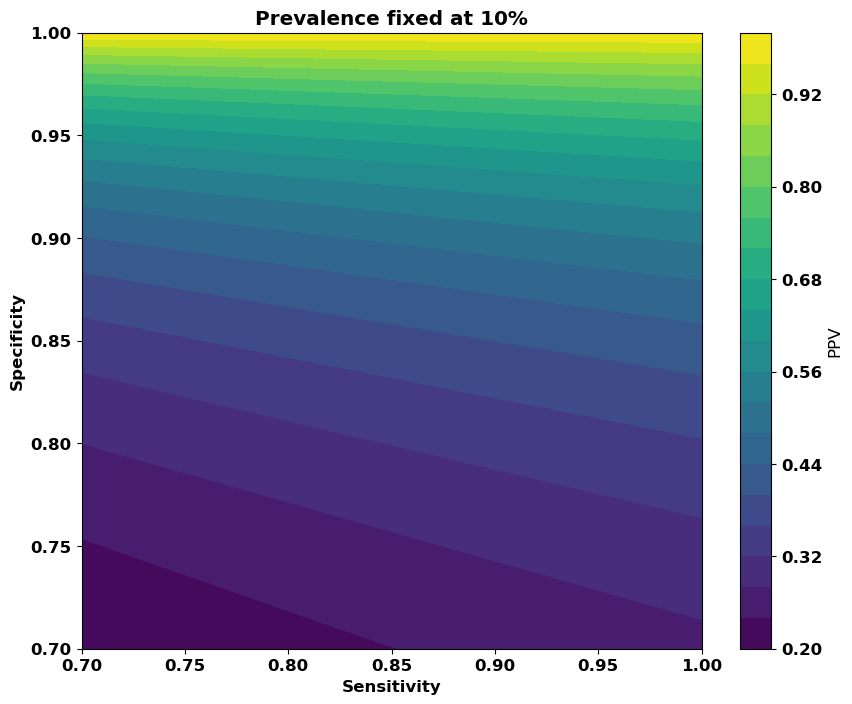

In [31]:
def my_function(sensitivity, specificity, prevalence):
    return (sensitivity * prevalence) / ((sensitivity * prevalence) + ((1-specificity) * (1-prevalence)))
import numpy as np

# Define ranges for x, y, z
sensitivity = np.linspace(0.7, 1, 100)
specificity = np.linspace(0.7, 1, 100)
prevalence = np.linspace(0, 0.5, 100)

# Create a meshgrid
se, sp, pr = np.meshgrid(sensitivity, specificity, prevalence)
# Compute the output of the function for each point in the grid
output = my_function(se, sp, pr)
import matplotlib.pyplot as plt

# Fix z at a specific value (e.g., z = 0)
z_fixed = 0.1
output_slice = my_function(se[:, :, 0], sp[:, :, 0], z_fixed)

# Plot the contour plot for z = 0
plt.figure(figsize=(10, 8))
cp = plt.contourf(se[:, :, 0], sp[:, :, 0], output_slice, levels=20, cmap='viridis')
plt.colorbar(cp, label='PPV')
plt.title(f'Prevalence fixed at {int(100*z_fixed)}%', fontweight='bold')
plt.xlabel('Sensitivity', fontweight='bold')
plt.ylabel('Specificity', fontweight='bold')
plt.show()


In [81]:
def plot_calibration_curve(lab, prob, n_bins, strategy='uniform'):
    y_true = np.concatenate(lab)
    y_prob = np.concatenate(prob)

    # Compute Brier score
    brier_score = brier_score_loss(y_true, y_prob)
    print(f'Brier Score: {brier_score}')

    # Compute Log Loss
    log_loss_score = log_loss(y_true, y_prob)
    print(f'Log Loss: {log_loss_score}')

    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy=strategy)
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
    plt.plot([0, 0.1], [0, 0.1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Predicted probability')
    plt.ylabel('True probability')
    plt.title('Calibration Curve')
    plt.legend()
    plt.show()

    # Expected Calibration Error (ECE)
    ece = np.sum(np.abs(prob_true - prob_pred) * len(y_true) / len(y_prob))
    print(f'Expected Calibration Error (ECE): {ece}')

    # Maximum Calibration Error (MCE)
    mce = np.max(np.abs(prob_true - prob_pred))
    print(f'Maximum Calibration Error (MCE): {mce}')

In [23]:
path = '../../results/dementia/proteomics/'
experiment = 'proteins_only'
df1 = pd.read_csv(f'{path}/{experiment}/roc_auc/test_results.csv')
df2 = pd.read_csv(f'{path}/{experiment}/f3/test_results.csv')
df3 = pd.read_csv(f'{path}/{experiment}/ap/test_results.csv')

In [19]:
df1

Unnamed: 0       model                                        hyperparams  \
0           0    catboost  {'early_stopping_rounds': 11, 'learning_rate':...   
1           1  extra_tree  {'n_estimators': 16, 'max_features': 0.8307823...   
2           2    catboost  {'early_stopping_rounds': 12, 'learning_rate':...   
3           3  extra_tree  {'n_estimators': 24, 'max_features': 0.7503837...   
4           4  extra_tree  {'n_estimators': 7, 'max_features': 0.60351688...   
5           5  extra_tree  {'n_estimators': 18, 'max_features': 0.6972910...   
6           6    catboost  {'early_stopping_rounds': 10, 'learning_rate':...   
7           7  extra_tree  {'n_estimators': 18, 'max_features': 0.9314015...   
8           8        lrl1                                         {'C': 1.0}   
9           9  extra_tree  {'n_estimators': 7, 'max_features': 0.86865410...   

      auroc  avg_prec  threshold     TP      TN      FP    FN  accuracy  \
0  0.773463  0.085920   0.041275   96.0  2552.0  1456.0  25.0  0.641318   
1  0.801252  0.072837   0.035309  121.0  5423.0  1942.0  39.0  0.736744   
2  0.782186  0.091551   0.055110  142.0  3942.0  2145.0  40.0  0.651460   
3  0.794149  0.098513   0.026021  203.0  5753.0  2358.0  70.0  0.710401   
4  0.834742  0.107752   0.035341   75.0  2588.0  1027.0  22.0  0.717403   
5  0.786456  0.075271   0.032519   73.0  2774.0  1071.0  32.0  0.720759   
6  0.809956  0.094137   0.046378   86.0  2524.0  1295.0  20.0  0.664968   
7  0.801177  0.081046   0.029310   35.0  1558.0   564.0  16.0  0.733088   
8  0.796074  0.077050   0.038494   77.0  3174.0  1282.0  27.0  0.712939   
9  0.808730  0.110632   0.028324  209.0  5231.0  2843.0  45.0  0.653218   

    bal_acc    prec_n    prec_p  recall_n  recall_p      f1_n      f1_p  
0  0.715057  0.990299  0.061856  0.636727  0.793388  0.775095  0.114764  
1  0.746285  0.992860  0.058652  0.736320  0.756250  0.845560  0.108862  
2  0.713915  0.989955  0.062090  0.647610  0.780220  0.782997  0.115026  
3  0.726437  0.987979  0.079266  0.709284  0.743590  0.825750  0.143260  
4  0.744551  0.991571  0.068058  0.715906  0.773196  0.831486  0.125104  
5  0.708347  0.988596  0.063811  0.721456  0.695238  0.834160  0.116894  
6  0.736113  0.992138  0.062274  0.660906  0.811321  0.793336  0.115669  
7  0.710244  0.989835  0.058431  0.734213  0.686275  0.843074  0.107692  
8  0.726341  0.991565  0.056659  0.712298  0.740385  0.829045  0.105263  
9  0.735358  0.991471  0.068480  0.647882  0.822835  0.783670  0.126437

In [9]:
df2

Unnamed: 0       model                                        hyperparams  \
0           0        lgbm  {'n_estimators': 4, 'num_leaves': 329, 'min_ch...   
1           1        lgbm  {'n_estimators': 4, 'num_leaves': 8, 'min_chil...   
2           2        lgbm  {'n_estimators': 14, 'num_leaves': 4, 'min_chi...   
3           3        lgbm  {'n_estimators': 4, 'num_leaves': 4, 'min_chil...   
4           4        lgbm  {'n_estimators': 19, 'num_leaves': 4, 'min_chi...   
5           5  extra_tree  {'n_estimators': 4, 'max_leaves': 34, 'max_fea...   
6           6        lgbm  {'n_estimators': 4, 'num_leaves': 25, 'min_chi...   
7           7        lgbm  {'n_estimators': 4, 'num_leaves': 71, 'min_chi...   
8           8        lgbm  {'n_estimators': 16, 'num_leaves': 5, 'min_chi...   
9           9        lgbm  {'n_estimators': 4, 'num_leaves': 11, 'min_chi...   

      auroc  avg_prec  threshold    TP       TN      FP     FN  accuracy  \
0  0.539509  0.014439   0.128225   9.0  13887.0   234.0   73.0  0.978385   
1  0.817987  0.035087   0.010764  65.0  31473.0  1588.0  129.0  0.948369   
2  0.543308  0.008436   0.006562  39.0  19351.0  4125.0   59.0  0.822516   
3  0.782125  0.039854   0.010051  66.0  28110.0  1258.0  110.0  0.953696   
4  0.863106  0.050077   0.015941  24.0  13832.0   549.0   26.0  0.960155   
5  0.818636  0.038096   0.015842  31.0  20851.0   544.0   95.0  0.970308   
6  0.848030  0.058072   0.018222  30.0  19605.0   640.0   62.0  0.965482   
7  0.769896  0.069006   0.016303   6.0   8137.0   114.0   23.0  0.983454   
8  0.647914  0.017362   0.048745  10.0  16348.0   371.0   70.0  0.973748   
9  0.842637  0.055270   0.012030  71.0  29284.0  1708.0   99.0  0.942013   

    bal_acc    prec_n    prec_p  recall_n  recall_p      f3_n      f3_p  
0  0.546593  0.994771  0.037037  0.983429  0.109756  0.984551  0.091743  
1  0.643510  0.995918  0.039322  0.951968  0.335052  0.956187  0.191233  
2  0.611124  0.996960  0.009366  0.824289  0.397959  0.838817  0.077289  
3  0.666082  0.996102  0.049849  0.957164  0.375000  0.960921  0.226960  
4  0.720912  0.998124  0.041885  0.961825  0.480000  0.965335  0.234604  
5  0.610303  0.995465  0.053913  0.974573  0.246032  0.976623  0.181393  
6  0.647237  0.996848  0.044776  0.968387  0.326087  0.971160  0.200267  
7  0.596540  0.997181  0.050000  0.986183  0.206897  0.987272  0.157480  
8  0.551405  0.995736  0.026247  0.977810  0.125000  0.979573  0.090827  
9  0.681268  0.996631  0.039910  0.944889  0.417647  0.949820  0.214566

In [8]:
df3

Unnamed: 0           model  \
0           0  xgb_limitdepth   
1           1  xgb_limitdepth   
2           2         xgboost   
3           3            lgbm   
4           4            lgbm   
5           5            lgbm   
6           6         xgboost   
7           7         xgboost   
8           8  xgb_limitdepth   
9           9         xgboost   

                                         hyperparams     auroc  avg_prec  \
0  {'n_estimators': 253, 'max_depth': 8, 'min_chi...  0.832026  0.041974   
1  {'n_estimators': 8, 'max_depth': 5, 'min_child...  0.826626  0.041069   
2  {'n_estimators': 100, 'max_leaves': 27, 'min_c...  0.857590  0.046435   
3  {'n_estimators': 14, 'num_leaves': 4, 'min_chi...  0.844497  0.054922   
4  {'n_estimators': 309, 'num_leaves': 7, 'min_ch...  0.890565  0.056878   
5  {'n_estimators': 177, 'num_leaves': 10, 'min_c...  0.869496  0.078214   
6  {'n_estimators': 27, 'max_leaves': 4, 'min_chi...  0.865651  0.082451   
7  {'n_estimators': 160, 'max_leaves': 9, 'min_ch...  0.830296  0.113741   
8  {'n_estimators': 89, 'max_depth': 1, 'min_chil...  0.880110  0.053709   
9  {'n_estimators': 732, 'max_leaves': 972, 'min_...  0.851777  0.064978   

   threshold    TP       TN      FP     FN  accuracy   bal_acc    prec_n  \
0   0.034074  17.0  13809.0   312.0   65.0  0.973456  0.592611  0.995315   
1   0.038035  44.0  32420.0   641.0  150.0  0.976214  0.603708  0.995395   
2   0.026675  38.0  22622.0   854.0   60.0  0.961228  0.675689  0.997355   
3   0.023073  69.0  28189.0  1179.0  107.0  0.956472  0.675950  0.996219   
4   0.030608  21.0  14057.0   324.0   29.0  0.975539  0.698735  0.997941   
5   0.027955  34.0  20898.0   497.0   92.0  0.972631  0.623306  0.995617   
6   0.025713  38.0  19698.0   547.0   54.0  0.970448  0.693012  0.997266   
7   0.025377  11.0   8044.0   207.0   18.0  0.972826  0.677111  0.997767   
8   0.020664  36.0  15952.0   767.0   44.0  0.951723  0.702062  0.997249   
9   0.023386  63.0  29742.0  1250.0  107.0  0.956453  0.665128  0.996415   

     prec_p  recall_n  recall_p      f3_n      f3_p  
0  0.051672  0.977905  0.207317  0.979619  0.159325  
1  0.064234  0.980612  0.226804  0.982070  0.180995  
2  0.042601  0.963622  0.387755  0.966893  0.214205  
3  0.055288  0.959854  0.392045  0.963371  0.243644  
4  0.060870  0.977470  0.420000  0.979479  0.264151  
5  0.064030  0.976770  0.269841  0.978623  0.204204  
6  0.064957  0.972981  0.413043  0.975356  0.268931  
7  0.050459  0.974912  0.379310  0.977150  0.229645  
8  0.044832  0.954124  0.450000  0.958268  0.236376  
9  0.047982  0.959667  0.370588  0.963219  0.221597

In [73]:
lab, prob = plot_results.concat_labels_and_probas('../results/dementia/proteomics/age_only/roc_auc/')

y_true = np.concatenate(lab)
y_prob = np.concatenate(prob)
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)

plot_calibration_curve(lab, prob, n_bins=9, strategy='uniform')

Brier Score: 0.025798285668851517
Log Loss: 0.11196349142762048
Expected Calibration Error (ECE): 0.013524821518755288
Maximum Calibration Error (MCE): 0.009547983661373174


In [72]:
lab, prob = plot_results.concat_labels_and_probas('../results/dementia/proteomics/age_only/roc_auc/')

y_true = np.concatenate(lab)
y_prob = np.concatenate(prob)
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)

plot_calibration_curve(lab, prob, n_bins=9, strategy='quantile')

Brier Score: 0.025798285668851517
Log Loss: 0.11196349142762048
Expected Calibration Error (ECE): 0.03740556555839051
Maximum Calibration Error (MCE): 0.011263010002519818


0.0020917126385142483 0.18446601941747573


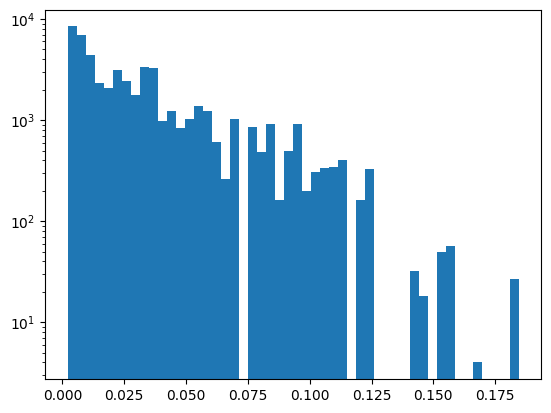

In [54]:
print(min(y_prob), max(y_prob))
plt.hist(y_prob, bins=50, log=True);

Brier Score: 0.02437325273292414
Log Loss: 0.13345213625866967


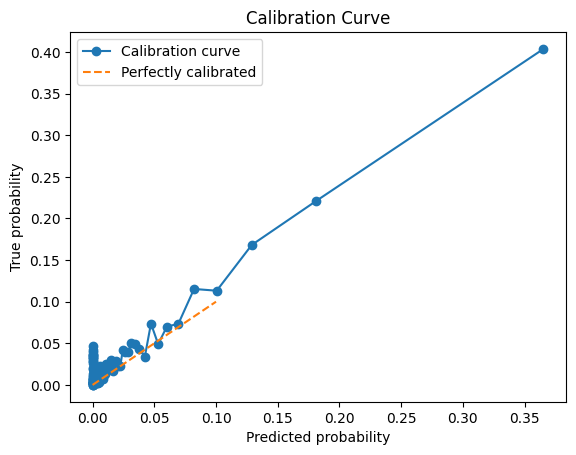

Expected Calibration Error (ECE): 1.1215197860279689
Maximum Calibration Error (MCE): 0.04705156417832943
Brier Score: 0.025798285668851517
Log Loss: 0.11196349142762048


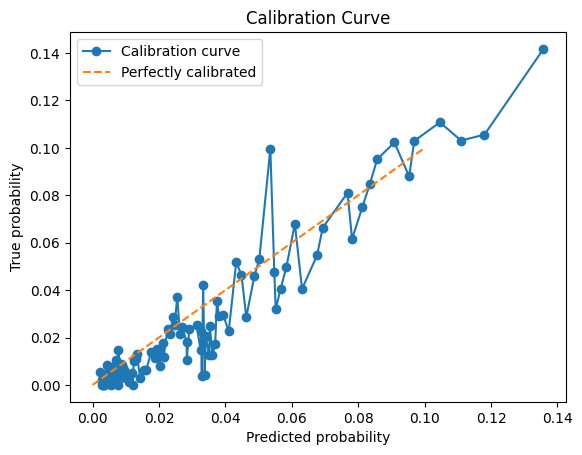

Expected Calibration Error (ECE): 0.7768901735619004
Maximum Calibration Error (MCE): 0.04611662118791565


In [86]:
lab, prob = plot_results.concat_labels_and_probas('../results/dementia/proteomics/demographics_and_modality/roc_auc/')

y_true = np.concatenate(lab)
y_prob = np.concatenate(prob)
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)

plot_calibration_curve(lab, prob, n_bins=100, strategy='quantile')

lab, prob = plot_results.concat_labels_and_probas('../results/dementia/proteomics/age_only/roc_auc/')

y_true = np.concatenate(lab)
y_prob = np.concatenate(prob)
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)

plot_calibration_curve(lab, prob, n_bins=100, strategy='quantile')

Brier Score: 0.02437325273292414
Log Loss: 0.13345213625866967


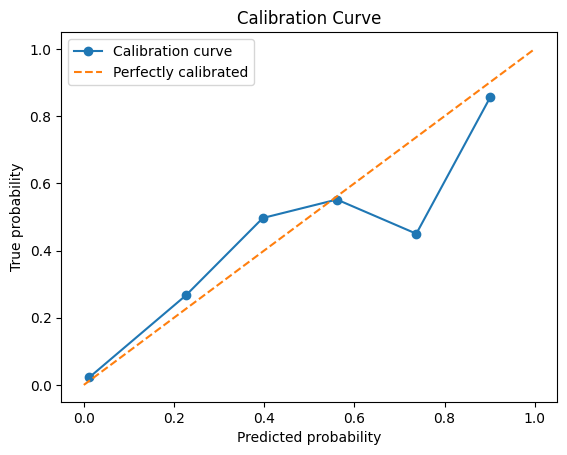

Expected Calibration Error (ECE): 0.49164768520269586
Maximum Calibration Error (MCE): 0.28738921607688855


In [77]:
lab, prob = plot_results.concat_labels_and_probas('../results/dementia/proteomics/demographics_and_modality/roc_auc/')

y_true = np.concatenate(lab)
y_prob = np.concatenate(prob)
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)

plot_calibration_curve(lab, prob, n_bins=6, strategy='uniform')

1.3516467087659648e-10 0.9770848700928781


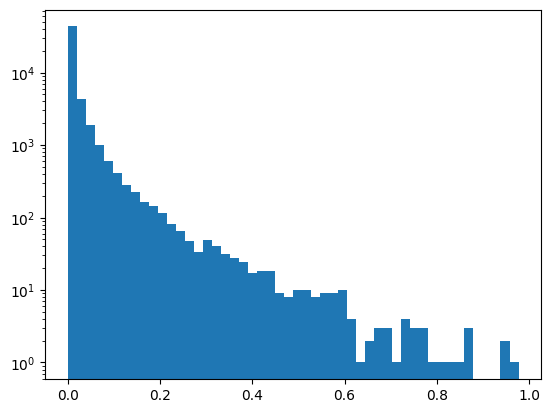

In [48]:
print(min(y_prob), max(y_prob))
plt.hist(y_prob, bins=50, log=True);

Brier Score: 0.005929919051838324
Log Loss: 0.03844125026023717


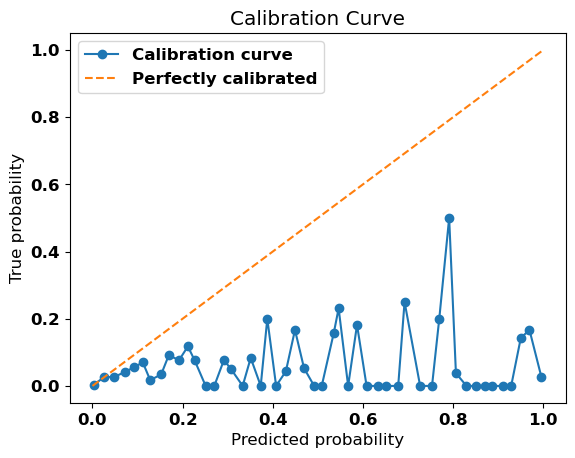

Expected Calibration Error (ECE): 21.0844598854981
Maximum Calibration Error (MCE): 0.9676478441724546


In [16]:
lab = pickle.load(open(f'{path}/{experiment}/f3/test_true_labels.pkl', 'rb'))
prob = pickle.load(open(f'{path}/{experiment}/f3/test_probas.pkl', 'rb'))
# for i,t in enumerate(df2.threshold):
#     pred = (prob[i] >= t).astype(int)
#     # print(f1_score(lab[i], pred))
#     # print(recall_score(lab[i], pred))
#     print(fbeta_score(lab[i], pred, beta=3))
plot_calibration_curve(lab, prob)

Brier Score: 0.0050144770615057664
Log Loss: 0.027655348897054823


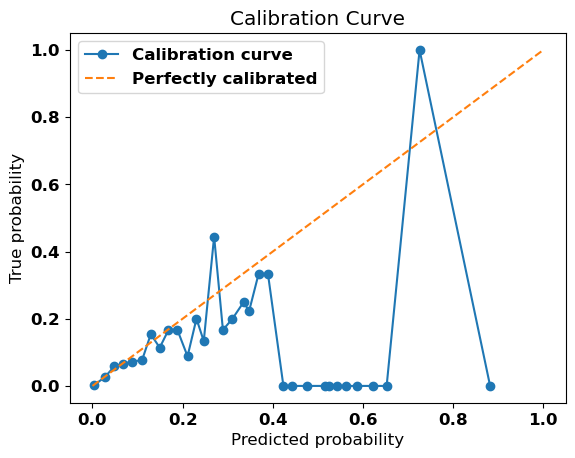

Expected Calibration Error (ECE): 7.630619870137153
Maximum Calibration Error (MCE): 0.8819171190261841


In [17]:
lab = pickle.load(open(f'{path}/{experiment}/ap/test_true_labels.pkl', 'rb'))
prob = pickle.load(open(f'{path}/{experiment}/ap/test_probas.pkl', 'rb'))
# for i,t in enumerate(df2.threshold):
#     pred = (prob[i] >= t).astype(int)
#     # print(f1_score(lab[i], pred))
#     # print(recall_score(lab[i], pred))
#     print(fbeta_score(lab[i], pred, beta=3))
plot_calibration_curve(lab, prob)

(array([[1.934e+03, 6.430e+02, 4.070e+02, 4.220e+02, 1.940e+02, 1.470e+02,
         3.550e+02, 0.000e+00, 0.000e+00, 2.700e+01],
        [3.626e+03, 1.836e+03, 9.820e+02, 2.810e+02, 4.960e+02, 3.040e+02,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 1.228e+03, 2.754e+03, 6.300e+02, 8.090e+02, 0.000e+00,
         5.210e+02, 2.770e+02, 0.000e+00, 5.000e+01],
        [4.960e+03, 1.249e+03, 7.520e+02, 3.710e+02, 3.300e+02, 3.100e+02,
         3.620e+02, 0.000e+00, 0.000e+00, 5.000e+01],
        [2.121e+03, 4.890e+02, 3.020e+02, 2.930e+02, 1.580e+02, 1.700e+02,
         1.610e+02, 0.000e+00, 1.800e+01, 0.000e+00],
        [1.781e+03, 1.361e+03, 1.820e+02, 1.600e+02, 2.790e+02, 1.620e+02,
         2.500e+01, 0.000e+00, 0.000e+00, 0.000e+00],
        [1.929e+03, 4.310e+02, 3.880e+02, 3.720e+02, 1.750e+02, 3.080e+02,
         1.270e+02, 1.630e+02, 3.200e+01, 0.000e+00],
        [1.258e+03, 4.340e+02, 8.400e+01, 1.770e+02, 9.000e+01, 7.200e+01,
         5.400e+01, 0.

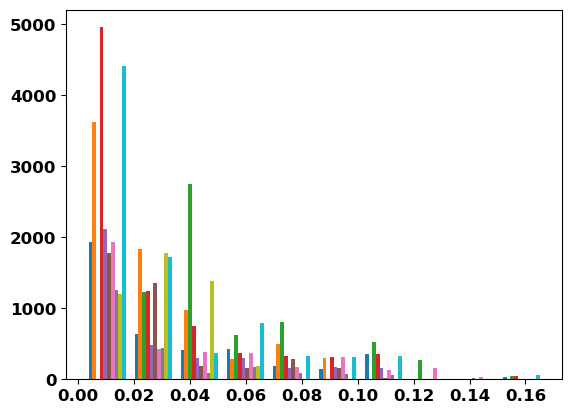

In [53]:
plt.hist(prob)

In [1]:
import os
os.chdir('./cognitive_tests/')

In [68]:
os.getcwd()

'/n/groups/patel/randy/rfb/code/cognitive_tests'

In [ ]:
# Strings to search for
search_strings = ['42019-0', '42021-0', '42023-0', '42025-0', '131037-0', '130837-0', '130839-0', '130841-0', '130843-0']#, '41280']

# Identify column names that start with any of the search strings
matching_columns = [col for col in acd.columns if any(col.startswith(s) for s in search_strings)]

# Filter rows where at least one value in the subset of columns is not NA
source_report_df = acd[acd[matching_columns].isin([1,2,11,12,21,22]).any(axis=1)]

In [ ]:
import pandas as pd

# Step 2: Define the prefixes
prefixes = ['S720', 'S721', 'S722']

# Step 3: Define a function that checks if a cell starts with any of the prefixes
def starts_with_prefixes(cell):
    return any(str(cell).startswith(prefix) for prefix in prefixes)

# Step 4: Apply the function to each cell in the DataFrame
result = icd10_df.applymap(starts_with_prefixes)

# Step 5: Get the row, column indices where the condition is True
# indices = result.stack()[result.stack()].index.tolist()
indices = [(row, icd10_df.columns.get_loc(col)) for row, col in result.stack()[result.stack()].index.tolist()]

# Step 6: Retrieve the values corresponding to the indices
values = [icd10_df.iat[row, col] for row, col in indices]

# values = [icd10_df.iat[row, icd10_df.columns.get_loc(col)] for row, col in indices]
dates = [icd10_date_df.iat[row, col] for row, col in indices] 
# Display the result
# print("DataFrame:\n", df)
# print("\nBoolean DataFrame:\n", result)
# print("\nRow, Column Indices where condition is True:\n", indices)


/tmp/ipykernel_29462/519185724.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result = icd10_df.applymap(starts_with_prefixes)


In [ ]:
proteins = pd.read_csv('../tidy_data/proteomics/protein_colnames.txt', header=None)
proteins = proteins[0].tolist()
proteins[:10]

['2738-0',
 '2737-0',
 '2736-0',
 '2735-0',
 '2734-0',
 '2733-0',
 '2732-0',
 '2731-0',
 '2739-0',
 '2740-0']

In [ ]:
prot_annot = pd.read_csv('../tidy_data/proteomics/coding143.tsv',
                                          sep='\t')
prot_annot[['protein_id', 'meaning']] = prot_annot['meaning'].str.split(';', expand=True)

In [ ]:
# NEFL, GFAP, GDF15, BCAN, LTBP2, NPTXR, EDA2R, NTproBNP, EGFR, HPGDS and CST5


prot_annot[prot_annot.protein_id.str.contains('GFAP|NEFL|GDF15|BCAN|LTBP2|NPTXR|EDA2R|NTproBNP|EGFR|HPGDS|CST5')].coding.tolist()

[242, 711, 883, 902, 1137, 1141, 1288, 1631, 1840, 1896, 1912]

In [ ]:
death_icd_df.shape

(2317, 537)

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st

round_num = 3
paths = ['demographics/dementia/test_noAge_bootstrap_results.parquet', 'demographics/dementia/test_bootstrap_results.parquet', 'proteomics/dementia/wo_demo/', 'proteomics/dementia/with_demo/']
names = ['Demo, No Age', 'Demographics', 'Proteins', 'Proteins+Demo', ]

final_rows = []
for p, name in zip(paths, names):
    if 'demographics' not in p:
        rows = []
        res_path = f'../tidy_data/{p}/test/'
        res = [file for file in os.listdir(res_path) if 'results' in file]
        for f in res:
            df = pd.read_parquet(f'{res_path}/{f}')
            df = df.sort_values(by='auroc', ascending=False)
            # rows.append(df.iloc[0, :])
            # rows.append(df)
            rows.append(df.iloc[:(int(df.shape[0] / 20)), :])
        # res_df = pd.concat(rows, axis=1).T
        df = pd.concat(rows, axis=0)

    else:
        df = pd.read_parquet(f'../tidy_data/{p}')
        df = df.sort_values(by='auroc', ascending=False)
        df = df.iloc[:(int(df.shape[0] / 20)), :]

    metric_cols = ['auroc', 'balanced_acc', 'prec_neg', 'prec_pos', 'rec_neg', 'rec_pos', 'f1_neg', 'f1_pos']
    row = []
    row.append(name)
    for i,mc in enumerate(metric_cols):
        mean = np.mean(df[mc])
        low_bound, up_bound = st.t.interval(confidence=0.95, df=len(df)-1, loc=np.mean(df[mc]), scale=np.std(df[mc]))
        row.extend([f'{round(mean,round_num)} ({round(low_bound,round_num)}-{round(up_bound,round_num)})'])

    final_rows.append(pd.Series(row))

guo_row1 = pd.Series(['Guo (P)', '0.841 (0.823-0.86)', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A'])
guo_row2 = pd.Series(['Guo (P+D)', '0.908 (0.889-0.927)', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A'])
# guo_row2 = pd.Series(['Guo (P+D+C)', '0.913 (0.911-0.915)', 'NA', 'NA', '0.117 (0.101-0.133)', 'NA', '0.827 (0.758-0.896)', 'NA', '0.205 (0.179-0.231)'])
final_rows.extend([guo_row1, guo_row2])
res_df = pd.concat(final_rows, axis=1).T

In [ ]:
res_df.columns = ['Features', 'AUROC', 'Balanced Acc.', 'Precision Neg.', 'Precision', 'Recall Neg.', 'Recall', 'F1 Neg.', 'F1']
res_df.loc[:, ['Features', 'AUROC', 'Precision', 'Recall', 'F1']].to_latex('dementia.tex', index=False, index_names=False)

In [ ]:
'../tidy_data/proteomics/hip_fracture/wo_demo/test/'

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import os

round_num = 3
paths = ['demographics/hip_fracture/test_0_bootstrap_results.parquet', 
         'proteomics/hip_fracture/wo_demo/', 'proteomics/hip_fracture/with_demo/']
names = ['Demographics',
         'Proteins', 'Proteins+Demo', ]

final_rows = []
for p, name in zip(paths, names):
    if 'demographics' not in p:
        rows = []
        res_path = f'../tidy_data/{p}/test/'
        res = [file for file in os.listdir(res_path) if 'results' in file]
        for f in res:
            df = pd.read_parquet(f'{res_path}/{f}')
            df = df.sort_values(by='auroc', ascending=False)
            # rows.append(df.iloc[0, :])
            # rows.append(df)
            rows.append(df.iloc[:(int(df.shape[0] / 20)), :])
        # res_df = pd.concat(rows, axis=1).T
        df = pd.concat(rows, axis=0)

    else:
        df = pd.read_parquet(f'../tidy_data/{p}')
        df = df.sort_values(by='auroc', ascending=False)
        df = df.iloc[:(int(df.shape[0] / 20)), :]

    metric_cols = ['auroc', 'balanced_acc', 'prec_neg', 'prec_pos', 'rec_neg', 'rec_pos', 'f1_neg', 'f1_pos']
    row = []
    row.append(name)
    for i,mc in enumerate(metric_cols):
        mean = np.mean(df[mc])
        low_bound, up_bound = st.t.interval(confidence=0.95, df=len(df)-1, loc=np.mean(df[mc]), scale=np.std(df[mc]))
        row.extend([f'{round(mean,round_num)} ({round(low_bound,round_num)}-{round(up_bound,round_num)})'])

    final_rows.append(pd.Series(row))

austin_row = pd.Series(['Austin', '0.765', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A'])
final_rows.extend([austin_row])
res_df = pd.concat(final_rows, axis=1).T

FileNotFoundError: [Errno 2] No such file or directory: '../tidy_data/demographics/hip_fracture/test_0_bootstrap_results.parquet'

In [ ]:
res_df.columns = ['Features', 'AUROC', 'Balanced Acc.', 'Precision Neg.', 'Precision', 'Recall Neg.', 'Recall', 'F1 Neg.', 'F1']
res_df

Features                AUROC        Balanced Acc.  \
0   Demographics   0.597 (0.58-0.613)  0.513 (0.497-0.529)   
1       Proteins  0.672 (0.595-0.749)   0.62 (0.547-0.694)   
2  Proteins+Demo   0.64 (0.576-0.703)  0.597 (0.534-0.659)   
3         Austin                0.765                  N/A   

        Precision Neg.            Precision          Recall Neg.  \
0   0.987 (0.985-0.99)  0.039 (0.007-0.071)   0.988 (0.985-0.99)   
1  0.992 (0.988-0.996)  0.022 (0.012-0.031)  0.652 (0.441-0.863)   
2  0.991 (0.988-0.994)  0.022 (0.012-0.032)  0.697 (0.472-0.922)   
3                  N/A                  N/A                  N/A   

                Recall              F1 Neg.                   F1  
0   0.038 (0.007-0.07)  0.988 (0.986-0.989)   0.039 (0.008-0.07)  
1  0.589 (0.287-0.891)  0.782 (0.635-0.929)  0.042 (0.024-0.059)  
2   0.496 (0.21-0.783)  0.813 (0.654-0.971)  0.041 (0.026-0.057)  
3                  N/A                  N/A                  N/A

In [ ]:
res_df.loc[:, ['Features', 'AUROC', 'Precision', 'Recall', 'F1']].to_latex('hip_fracture.tex', index=False, index_names=False)

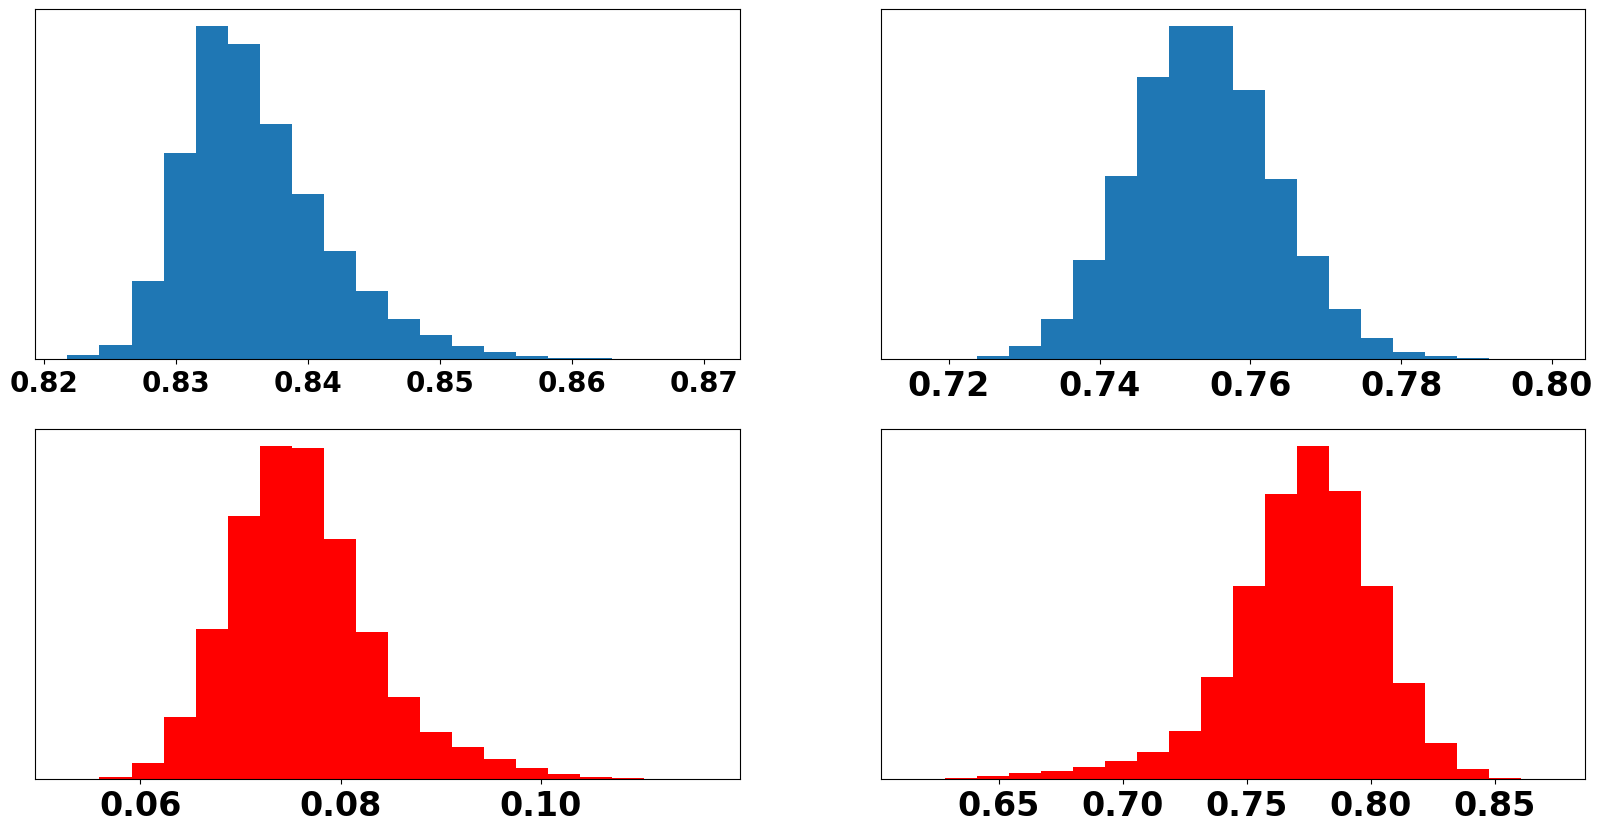

In [ ]:


# Set font properties
plt.rcParams.update({
    'font.size': 24,       # Set font size
    'font.weight': 'bold'  # Set font weight to bold
})

topleft = 'auroc'
topright = 'balanced_acc'
botleft = 'prec_pos'
botright = 'rec_pos'
num_bins = 20

# using tuple unpacking for multiple Axes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

ax1.hist(df[topleft], density=True, bins=num_bins)
ax1.tick_params(axis='x', labelsize=20) 
ax2.hist(df[topright], density=True, bins=num_bins)
ax3.hist(df[botleft], density=True, bins=num_bins, color='red')
ax4.hist(df[botright], density=True, bins=num_bins, color='red')

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_yticks([])

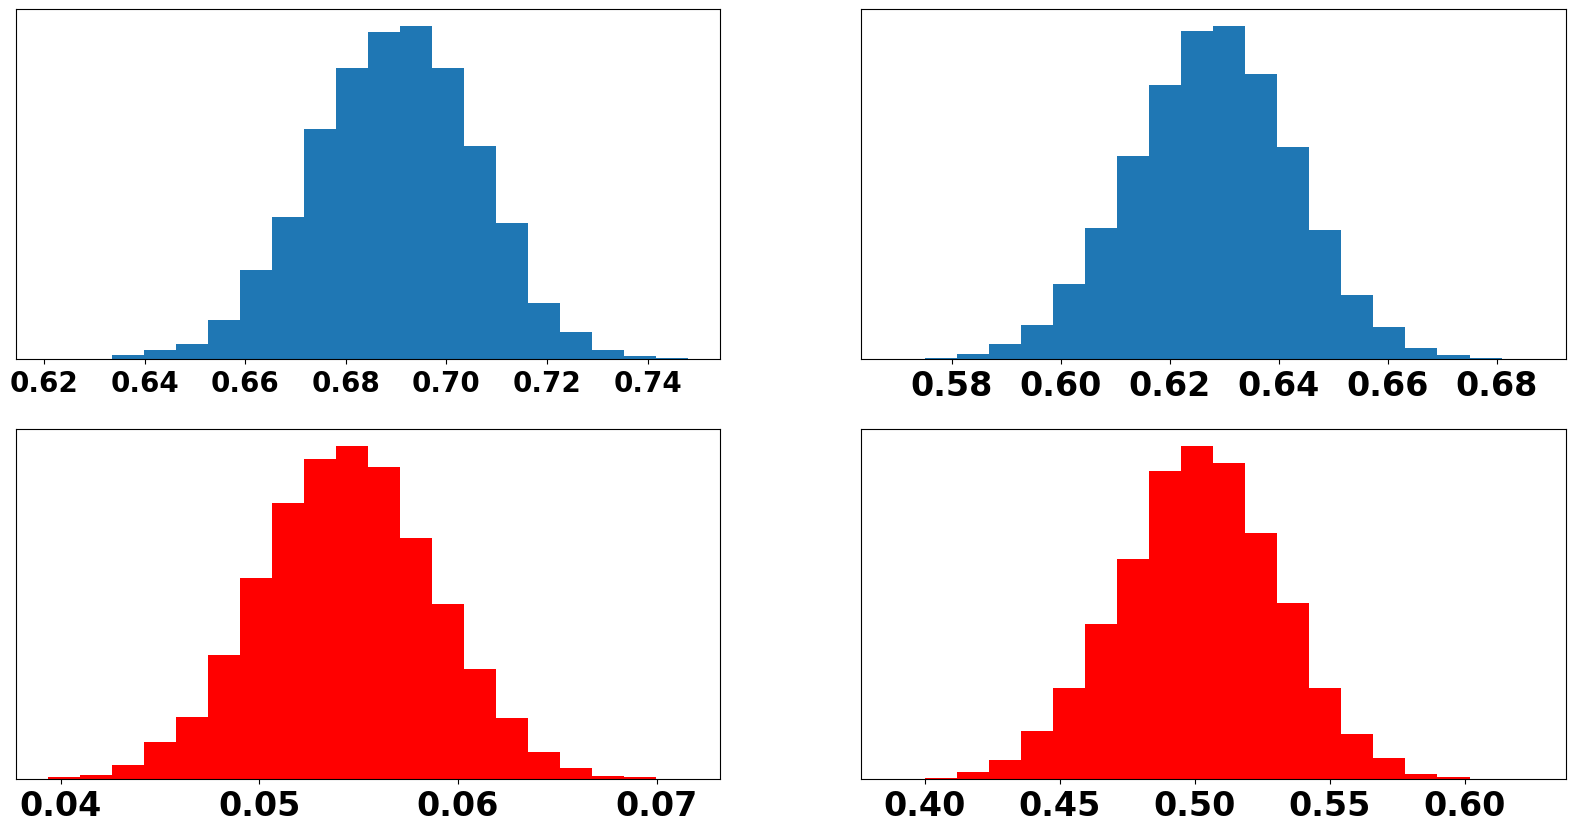

In [ ]:
df = pd.read_parquet('../tidy_data/demographics/test_noAge_bootstrap_results.parquet')

# Set font properties
plt.rcParams.update({
    'font.size': 24,       # Set font size
    'font.weight': 'bold'  # Set font weight to bold
})

topleft = 'auroc'
topright = 'balanced_acc'
botleft = 'prec_pos'
botright = 'rec_pos'
num_bins = 20

# using tuple unpacking for multiple Axes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

ax1.hist(df[topleft], density=True, bins=num_bins)
ax1.tick_params(axis='x', labelsize=20) 
ax2.hist(df[topright], density=True, bins=num_bins)
ax3.hist(df[botleft], density=True, bins=num_bins, color='red')
ax4.hist(df[botright], density=True, bins=num_bins, color='red')

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_yticks([])

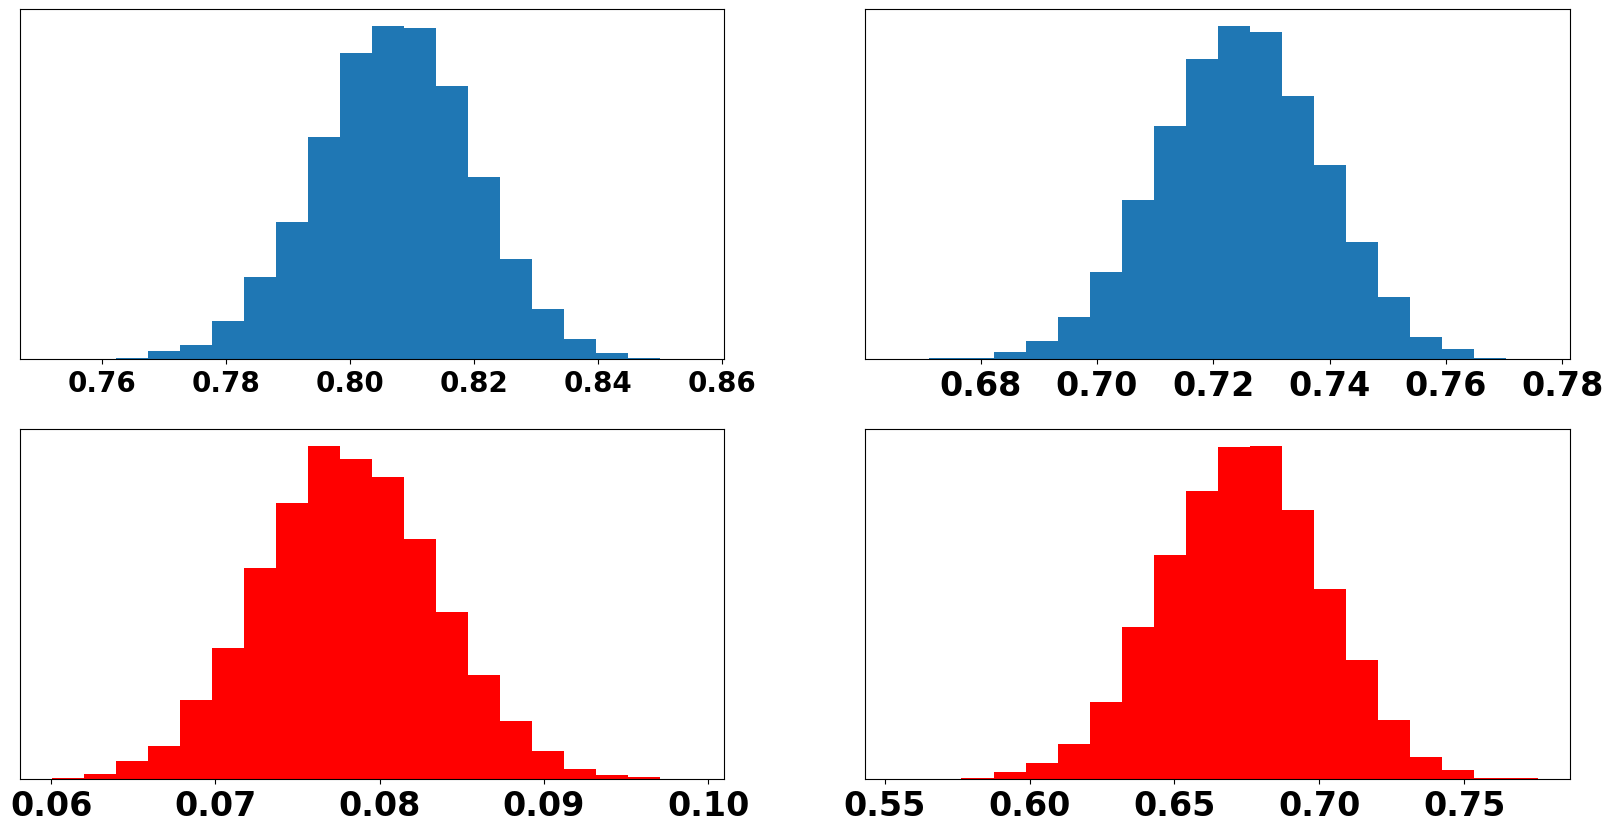

In [ ]:
df = pd.read_parquet('../tidy_data/demographics/test_bootstrap_results.parquet')

# Set font properties
plt.rcParams.update({
    'font.size': 24,       # Set font size
    'font.weight': 'bold'  # Set font weight to bold
})

topleft = 'auroc'
topright = 'balanced_acc'
botleft = 'prec_pos'
botright = 'rec_pos'
num_bins = 20

# using tuple unpacking for multiple Axes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

ax1.hist(df[topleft], density=True, bins=num_bins)
ax1.tick_params(axis='x', labelsize=20) 
ax2.hist(df[topright], density=True, bins=num_bins)
ax3.hist(df[botleft], density=True, bins=num_bins, color='red')
ax4.hist(df[botright], density=True, bins=num_bins, color='red')

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_yticks([])